# WESAD - Kompletna analiza danych

## Hipoteza badawcza
W warunkach stresu (w porównaniu do baseline i amusement) obserwujemy:
- **Wzrost**: przewodnictwo skóry (EDA), tętno (HR), tempo oddychania
- **Spadek**: zmienność rytmu serca (HRV/RMSSD)
- **Korelacje**: sygnały z nadgarstka (Empatica E4) i klatki piersiowej (RespiBAN) są silnie skorelowane

## Plan analizy
1. Parsowanie i synchronizacja danych (wrist + chest)
2. Agregacja do okien czasowych i ekstrakcja cech
3. Korelacje (wrist, chest, cross, per klasa)
4. Uczenie maszynowe (RF, XGBoost, porównanie modeli)
5. Analiza SHAP i ważności cech
6. Podsumowanie wyników


## 1. Konfiguracja i importy


In [159]:
from pathlib import Path
import numpy as np
import pandas as pd
import pickle
import math
from functools import lru_cache
from scipy.signal import resample
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import GroupKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder

PROJECT_ROOT = Path("/Users/turfian/Downloads/archive (4)/WESAD/wesad-prep")
RAW_ROOT = Path("/Users/turfian/Downloads/archive (4)/WESAD")
MAX_DURATION = pd.Timedelta(minutes=40)
TARGET_FS = 32.0
TARGET_CHEST_FS = 32.0

DEFAULT_SUBJECTS = ["S2", "S3", "S4", "S5", "S6", "S7"]

SENSOR_SCHEMAS = {
    "ACC": ["acc_x", "acc_y", "acc_z"],
    "EDA": ["eda"],
    "BVP": ["bvp"],
    "TEMP": ["temp"],
    "HR": ["hr"],
}

CHEST_COLUMNS = {
    "ACC": ["chest_acc_x", "chest_acc_y", "chest_acc_z"],
    "ECG": ["chest_ecg"],
    "EMG": ["chest_emg"],
    "EDA": ["chest_eda"],
    "Temp": ["chest_temp"],
    "Resp": ["chest_resp"],
}
CHEST_FS = {key: 700.0 for key in CHEST_COLUMNS}

PHASE_TO_CLASS = {
    "Base": "baseline",
    "Medi 1": "baseline",
    "Medi 2": "baseline",
    "TSST": "stress",
    "sRead": "stress",
    "fRead": "stress",
    "Fun": "amusement",
}

print("Konfiguracja załadowana ✓")


Konfiguracja załadowana ✓


## 2. Funkcje parsowania i synchronizacji


In [160]:
def build_time_index(length: int, start_ts: float, fs: float) -> pd.Series:
    start = pd.to_datetime(start_ts, unit="s", utc=True)
    offsets = pd.to_timedelta(np.arange(length) / fs, unit="s")
    return start + offsets


def load_sensor_for_subject(subject_path: Path, sensor_name: str) -> pd.DataFrame:
    file_path = subject_path / f"{sensor_name}.csv"
    column_names = SENSOR_SCHEMAS.get(sensor_name, [sensor_name.lower()])
    header = pd.read_csv(file_path, nrows=2, header=None)
    start_ts = float(header.iloc[0, 0])
    fs = float(header.iloc[1, 0])
    data = pd.read_csv(file_path, skiprows=2, header=None, names=column_names)
    data.insert(0, "timestamp", build_time_index(len(data), start_ts, fs))
    data.attrs.update({"start_ts": start_ts, "fs": fs})
    return data


def load_ibi_for_subject(subject_path: Path) -> pd.DataFrame:
    path = subject_path / "IBI.csv"
    with path.open() as f:
        first_line = f.readline()
    start_ts = float(first_line.split(",")[0])
    data = pd.read_csv(path, skiprows=1, header=None, names=["seconds", "ibi"])
    timestamps = pd.to_datetime(start_ts + data["seconds"], unit="s", utc=True)
    data.insert(0, "timestamp", timestamps)
    return data


def load_tags_for_subject(subject_path: Path) -> pd.DataFrame:
    path = subject_path / "tags.csv"
    if not path.exists() or path.stat().st_size == 0:
        return pd.DataFrame(columns=["timestamp", "tag"])
    tags = pd.read_csv(path, header=None, names=["timestamp"])
    tags["timestamp"] = pd.to_datetime(tags["timestamp"], unit="s", utc=True)
    tags["tag"] = 1
    return tags


def _extract_values(lines, prefix):
    for line in lines:
        if line.startswith(prefix):
            return [token for token in line.split(";")[1:] if token]
    return []


def build_phase_protocol_for_subject(subject: str, session_start: pd.Timestamp, raw_root: Path = RAW_ROOT) -> pd.DataFrame:
    quest_path = raw_root / subject / f"{subject}_quest.csv"
    if not quest_path.exists():
        return pd.DataFrame(columns=["phase", "start", "end", "duration_s"])
    lines = [line.strip() for line in quest_path.read_text().splitlines() if line.strip()]
    names = _extract_values(lines, "# ORDER")
    starts = _extract_values(lines, "# START")
    ends = _extract_values(lines, "# END")
    phases = []
    limit = min(len(names), len(starts), len(ends))
    for idx in range(limit):
        try:
            start_offset = float(starts[idx])
            end_offset = float(ends[idx])
        except ValueError:
            continue
        if math.isnan(start_offset) or math.isnan(end_offset):
            continue
        start_ts = session_start + pd.to_timedelta(start_offset, unit="m")
        end_ts = session_start + pd.to_timedelta(end_offset, unit="m")
        phases.append({
            "phase": names[idx],
            "start": start_ts,
            "end": end_ts,
            "duration_s": (end_ts - start_ts).total_seconds(),
        })
    return pd.DataFrame(phases)


def resample_uniform(df: pd.DataFrame, target_fs: float) -> pd.DataFrame:
    if df.empty:
        return df
    start = df["timestamp"].iloc[0]
    end = df["timestamp"].iloc[-1]
    freq = pd.to_timedelta(1 / target_fs, unit="s")
    target_index = pd.date_range(start=start, end=end, freq=freq, inclusive="left")
    value_cols = [c for c in df.columns if c != "timestamp"]
    aligned = (
        df.set_index("timestamp")[value_cols]
        .reindex(target_index)
        .interpolate(method="time")
        .ffill()
    )
    aligned.index.name = "timestamp"
    return aligned.reset_index()


def prefix_columns(df: pd.DataFrame, prefix: str) -> pd.DataFrame:
    rename_map = {}
    base = prefix.lower()
    for col in df.columns:
        if col == "timestamp":
            continue
        if col.lower().startswith(base):
            continue
        rename_map[col] = f"{base}_{col}"
    return df.rename(columns=rename_map)


def assign_phase_labels(timestamps: pd.Series, phases: pd.DataFrame) -> pd.Series:
    if phases.empty:
        return pd.Series(["unknown"] * len(timestamps), index=timestamps.index)
    intervals = pd.IntervalIndex.from_arrays(phases["start"], phases["end"], closed="left")
    labels = phases["phase"].to_list()
    idx = intervals.get_indexer(timestamps)
    label_array = np.array(labels, dtype=object)
    mapped = np.where(idx >= 0, label_array[idx], "unknown")
    return pd.Series(mapped, index=timestamps.index)


def load_wesad_pickle(subject: str, raw_root: Path = RAW_ROOT) -> dict:
    pkl_path = raw_root / subject / f"{subject}.pkl"
    if not pkl_path.exists():
        raise FileNotFoundError(f"Brak pliku {pkl_path}")
    with pkl_path.open("rb") as handle:
        return pickle.load(handle, encoding="latin1")


def resample_chest_signal(array, src_fs: float, target_len: int) -> np.ndarray:
    if array.ndim == 1:
        array = array[:, None]
    expected_len = int(src_fs * MAX_DURATION.total_seconds())
    trimmed = array[:expected_len]
    if len(trimmed) == 0:
        return np.full((target_len, array.shape[1]), np.nan)
    return resample(trimmed, target_len, axis=0)


def build_chest_dataframe(subject: str, session_start: pd.Timestamp) -> pd.DataFrame:
    data = load_wesad_pickle(subject)
    chest_signals = data["signal"].get("chest", {})
    duration_seconds = MAX_DURATION.total_seconds()
    target_len = int(duration_seconds * TARGET_CHEST_FS)
    timestamps = session_start + pd.to_timedelta(
        np.arange(target_len) / TARGET_CHEST_FS, unit="s"
    )
    df = pd.DataFrame({"timestamp": timestamps})
    for sensor_name, columns in CHEST_COLUMNS.items():
        if sensor_name not in chest_signals:
            for col in columns:
                df[col] = np.nan
            continue
        src_array = chest_signals[sensor_name]
        src_fs = CHEST_FS.get(sensor_name, 700.0)
        resampled = resample_chest_signal(src_array, src_fs, target_len)
        for idx, col in enumerate(columns):
            df[col] = resampled[:, idx]
    return df


@lru_cache(maxsize=None)
def load_empatica_session(subject: str, raw_root: Path = RAW_ROOT) -> tuple[pd.DataFrame, pd.DataFrame]:
    subject_path = raw_root / subject / f"{subject}_E4_Data"
    if not subject_path.exists():
        raise FileNotFoundError(f"Brak katalogu z danymi dla {subject}: {subject_path}")

    frames = {name: load_sensor_for_subject(subject_path, name) for name in SENSOR_SCHEMAS}
    frames["IBI"] = load_ibi_for_subject(subject_path)
    frames["TAGS"] = load_tags_for_subject(subject_path)

    resampled = {name: resample_uniform(df, TARGET_FS) for name, df in frames.items() if name not in {"IBI", "TAGS"}}
    if not frames["IBI"].empty:
        resampled["IBI"] = resample_uniform(frames["IBI"], TARGET_FS)
    if not frames["TAGS"].empty:
        resampled["TAGS"] = resample_uniform(frames["TAGS"], TARGET_FS)

    aligned = None
    for name, df in resampled.items():
        if df.empty:
            continue
        prepared = prefix_columns(df, name)
        aligned = prepared if aligned is None else aligned.merge(prepared, on="timestamp", how="outer")

    aligned = aligned.sort_values("timestamp").ffill().bfill().reset_index(drop=True)
    session_start = aligned["timestamp"].iloc[0]
    session_end = session_start + MAX_DURATION
    aligned = aligned[aligned["timestamp"] < session_end]

    phase_df = build_phase_protocol_for_subject(subject, session_start, raw_root=raw_root)
    if not phase_df.empty:
        phase_df = phase_df[phase_df["start"] < session_end].reset_index(drop=True)

    return aligned, phase_df

print("Funkcje pomocnicze załadowane ✓")


Funkcje pomocnicze załadowane ✓


## 3. Funkcje ekstrakcji cech


In [161]:
def compute_rmssd(series: pd.Series) -> float:
    values = series.dropna().to_numpy()
    if len(values) < 2:
        return np.nan
    diffs = np.diff(values)
    return float(np.sqrt(np.mean(diffs ** 2))) if len(diffs) else np.nan


def compute_range(series: pd.Series) -> float:
    if series.empty:
        return np.nan
    return float(series.max() - series.min())


def compute_respiration_rate(series: pd.Series) -> float:
    values = series.dropna().to_numpy()
    if len(values) < 2:
        return np.nan
    centered = values - np.nanmedian(values)
    zero_crossings = np.where(np.diff(np.signbit(centered)))[0]
    duration = (series.index[-1] - series.index[0]).total_seconds() if len(series) > 1 else 1.0
    breaths_per_second = len(zero_crossings) / 2.0 / duration if duration > 0 else 0.0
    return float(breaths_per_second * 60.0)


def compute_slope(series: pd.Series) -> float:
    if len(series) < 2:
        return np.nan
    times = (series.index - series.index[0]).total_seconds()
    values = series.to_numpy()
    A = np.vstack([times, np.ones(len(times))]).T
    slope, _ = np.linalg.lstsq(A, values, rcond=None)[0]
    return float(slope)

print("Funkcje ekstrakcji cech załadowane ✓")


Funkcje ekstrakcji cech załadowane ✓


## 4. Przetwarzanie wszystkich uczestników (wrist + chest)


In [162]:
subjects = DEFAULT_SUBJECTS
full_features = []
skipped_subjects = []

FEATURE_AGG = {
    "eda": ["mean", "std"],
    "hr": ["mean", "std"],
    "temp": ["mean"],
    "acc_mag": ["mean", "std"],
    "chest_eda": ["mean"],
    "chest_temp": ["mean"],
    "chest_resp": ["mean", "std"],
    "chest_ecg": ["mean"],
}

for subject in subjects:
    try:
        aligned_subj, phases_subj = load_empatica_session(subject)
    except FileNotFoundError as exc:
        print(f"[WARN] Pomijam {subject}: {exc}")
        skipped_subjects.append(subject)
        continue

    session_start = aligned_subj["timestamp"].iloc[0]
    try:
        chest_df = build_chest_dataframe(subject, session_start)
        combined = aligned_subj.merge(chest_df, on="timestamp", how="left")
    except FileNotFoundError as exc:
        print(f"[WARN] Brak danych RespiBAN dla {subject}: {exc}")
        combined = aligned_subj.copy()

    aligned_copy = combined.copy()
    if {"acc_x", "acc_y", "acc_z"}.issubset(aligned_copy.columns):
        aligned_copy["acc_mag"] = np.sqrt(
            aligned_copy[["acc_x", "acc_y", "acc_z"]].pow(2).sum(axis=1)
        )
    else:
        aligned_copy["acc_mag"] = np.nan

    aligned_copy["phase"] = assign_phase_labels(aligned_copy["timestamp"], phases_subj)
    resampled = aligned_copy.set_index("timestamp").resample(
        "60s", label="left", closed="left"
    )

    agg_targets = {
        "eda": ["mean", "std"],
        "hr": ["mean", "std"],
        "temp": ["mean"],
        "acc_mag": ["mean", "std"],
        "chest_eda": ["mean"],
        "chest_temp": ["mean"],
        "chest_resp": ["mean", "std"],
        "chest_ecg": ["mean"],
    }
    available_columns = set(combined.columns)
    agg_spec = {
        name: funcs for name, funcs in agg_targets.items() if name in available_columns
    }
    if not agg_spec:
        print(f"[WARN] Brak kolumn do agregacji dla {subject} – pomijam.")
        continue

    agg = resampled.agg(agg_spec)
    agg.columns = ["_".join(filter(None, col)).strip("_") for col in agg.columns]

    agg["phase"] = resampled["phase"].first().values
    agg["label"] = agg["phase"].map(lambda p: PHASE_TO_CLASS.get(p))
    agg["subject"] = subject
    agg = agg.dropna(subset=["label"]).reset_index()

    def safe_apply(resampler, column, func):
        if column not in combined.columns:
            return np.full(len(agg), np.nan)
        values = resampler[column].apply(func)
        if len(values) != len(agg):
            values = values.reindex(agg.index, fill_value=np.nan)
        return values.to_numpy()

    agg["hr_rmssd"] = safe_apply(resampled, "hr", compute_rmssd)
    agg["hr_range"] = safe_apply(resampled, "hr", compute_range)
    agg["eda_range"] = safe_apply(resampled, "eda", compute_range)
    agg["eda_slope"] = safe_apply(resampled, "eda", compute_slope)
    agg["resp_rate"] = safe_apply(resampled, "chest_resp", compute_respiration_rate)

    full_features.append(agg)

if not full_features:
    raise RuntimeError("Brak danych po integracji klatki piersiowej.")

multi_dataset_full = pd.concat(full_features, ignore_index=True)
print(
    f"✓ Zbiór gotowy: {len(multi_dataset_full)} próbek, {multi_dataset_full['subject'].nunique()} uczestników"
)

processed_path = PROJECT_ROOT / "data" / "processed"
processed_path.mkdir(parents=True, exist_ok=True)
multi_dataset_full.to_parquet(processed_path / "multi_subject_wrist_chest.parquet")

multi_dataset_full.head()


✓ Zbiór gotowy: 142 próbek, 6 uczestników


,timestamp,eda_mean,eda_std,hr_mean,hr_std,temp_mean,chest_eda_mean,chest_temp_mean,chest_resp_mean,chest_resp_std,chest_ecg_mean,phase,label,subject,hr_rmssd,hr_range,eda_range,eda_slope,resp_rate
0,2017-05-22 07:23:00+00:00,0.580605,0.042706,78.418135,0.728108,35.591062,3.275758,28.788637,0.022755,1.899406,0.000881,Base,baseline,S2,NaN,NaN,NaN,NaN,NaN
1,2017-05-22 07:24:00+00:00,0.492415,0.024832,76.853721,1.223666,35.864740,2.793226,28.631914,0.088932,1.416516,0.001183,Base,baseline,S2,NaN,NaN,NaN,NaN,NaN
2,2017-05-22 07:25:00+00:00,0.536259,0.176700,80.398635,1.193212,35.921406,2.425497,28.573347,0.053710,1.493809,0.001383,Base,baseline,S2,NaN,NaN,NaN,NaN,NaN
3,2017-05-22 07:26:00+00:00,1.266897,0.095477,76.635201,0.406315,35.797411,2.165060,28.447908,0.039159,1.466377,0.001094,Base,baseline,S2,NaN,NaN,NaN,NaN,NaN
4,2017-05-22 07:27:00+00:00,1.120767,0.086282,78.257729,0.531944,35.766333,1.953250,28.458138,0.066773,1.432395,0.001647,Base,baseline,S2,NaN,NaN,NaN,NaN,NaN


## 5. Korelacje: wrist, chest, cross, per klasa


In [163]:
wrist_cols = [col for col in multi_dataset_full.columns if not col.startswith("chest_") and col not in {"timestamp", "phase", "label", "subject"}]
chest_cols = [col for col in multi_dataset_full.columns if col.startswith("chest_")]

wrist_data = multi_dataset_full[wrist_cols]
chest_data = multi_dataset_full[chest_cols]

corr_wrist = wrist_data.corr(min_periods=5)
corr_chest = chest_data.corr(min_periods=5)

print(f"Kolumny wrist: {len(wrist_cols)}")
print(f"Kolumny chest: {len(chest_cols)}")
print(f"\nMacierz korelacji wrist: {corr_wrist.shape}")
print(f"Macierz korelacji chest: {corr_chest.shape}")

print("\n=== KORELACJE WRIST (top 5 najsilniejszych) ===")
wrist_upper = corr_wrist.where(np.triu(np.ones(corr_wrist.shape), k=1).astype(bool))
wrist_pairs = wrist_upper.stack().abs().sort_values(ascending=False).head(5)
display(wrist_pairs)

print("\n=== KORELACJE CHEST (top 5 najsilniejszych) ===")
chest_upper = corr_chest.where(np.triu(np.ones(corr_chest.shape), k=1).astype(bool))
chest_pairs = chest_upper.stack().abs().sort_values(ascending=False).head(5)
display(chest_pairs)


Kolumny wrist: 10
Kolumny chest: 5

Macierz korelacji wrist: (10, 10)
Macierz korelacji chest: (5, 5)

=== KORELACJE WRIST (top 5 najsilniejszych) ===


hr_mean   hr_std       0.468989
eda_mean  eda_std      0.402070
eda_std   temp_mean    0.391358
eda_mean  temp_mean    0.148353
hr_std    temp_mean    0.146871
dtype: float64


=== KORELACJE CHEST (top 5 najsilniejszych) ===


chest_eda_mean   chest_temp_mean    0.478897
chest_resp_std   chest_ecg_mean     0.261713
chest_resp_mean  chest_ecg_mean     0.257261
chest_temp_mean  chest_resp_std     0.254345
chest_eda_mean   chest_resp_std     0.248157
dtype: float64

In [164]:
corr_cross_long = []
for w_col in wrist_cols:
    for c_col in chest_cols:
        pair = multi_dataset_full[[w_col, c_col]].dropna()
        if len(pair) < 5:
            continue
        corr_val = pair.corr().iloc[0, 1]
        if not np.isnan(corr_val):
            corr_cross_long.append({"wrist": w_col, "chest": c_col, "correlation": corr_val})

if corr_cross_long:
    corr_cross_long_df = pd.DataFrame(corr_cross_long)
    corr_cross_long_df["abs_corr"] = corr_cross_long_df["correlation"].abs()
    corr_cross_long_df = corr_cross_long_df.sort_values("abs_corr", ascending=False).drop(columns=["abs_corr"])
else:
    corr_cross_long_df = pd.DataFrame(columns=["wrist", "chest", "correlation"])

print(f"=== KORELACJE CROSS (wrist vs chest) ===")
print(f"Liczba par: {len(corr_cross_long_df)}")
print("\nTop 10 najsilniejszych korelacji:")
display(corr_cross_long_df.head(10).round(3))


=== KORELACJE CROSS (wrist vs chest) ===
Liczba par: 25

Top 10 najsilniejszych korelacji:


,wrist,chest,correlation
0,eda_mean,chest_eda_mean,0.832
21,temp_mean,chest_temp_mean,-0.298
6,eda_std,chest_temp_mean,-0.207
1,eda_mean,chest_temp_mean,0.181
5,eda_std,chest_eda_mean,0.171
11,hr_mean,chest_temp_mean,-0.158
20,temp_mean,chest_eda_mean,-0.132
9,eda_std,chest_ecg_mean,-0.129
14,hr_mean,chest_ecg_mean,0.123
13,hr_mean,chest_resp_std,-0.103


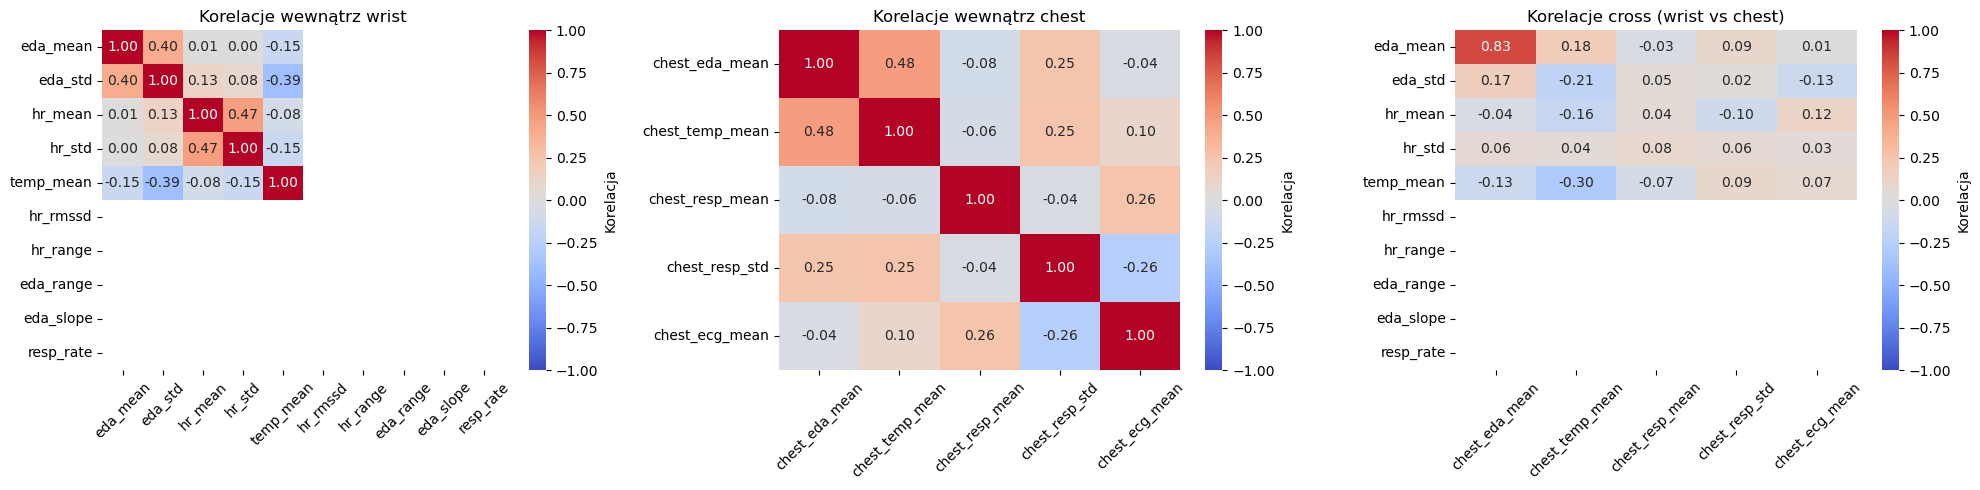

In [165]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

sns.heatmap(corr_wrist, annot=True, fmt=".2f", cmap="coolwarm", center=0, vmin=-1, vmax=1, ax=axes[0], cbar_kws={"label": "Korelacja"})
axes[0].set_title("Korelacje wewnątrz wrist")
axes[0].tick_params(axis="x", rotation=45)
axes[0].tick_params(axis="y", rotation=0)

sns.heatmap(corr_chest, annot=True, fmt=".2f", cmap="coolwarm", center=0, vmin=-1, vmax=1, ax=axes[1], cbar_kws={"label": "Korelacja"})
axes[1].set_title("Korelacje wewnątrz chest")
axes[1].tick_params(axis="x", rotation=45)
axes[1].tick_params(axis="y", rotation=0)

corr_cross_matrix = pd.DataFrame(index=wrist_cols, columns=chest_cols, dtype=float)
for w_col in wrist_cols:
    for c_col in chest_cols:
        pair = multi_dataset_full[[w_col, c_col]].dropna()
        if len(pair) < 5:
            corr_cross_matrix.loc[w_col, c_col] = np.nan
        else:
            corr_cross_matrix.loc[w_col, c_col] = pair.corr().iloc[0, 1]

sns.heatmap(corr_cross_matrix.astype(float), annot=True, fmt=".2f", cmap="coolwarm", center=0, vmin=-1, vmax=1, ax=axes[2], cbar_kws={"label": "Korelacja"})
axes[2].set_title("Korelacje cross (wrist vs chest)")
axes[2].tick_params(axis="x", rotation=45)
axes[2].tick_params(axis="y", rotation=0)

plt.tight_layout()
plt.show()


In [166]:
phase_corrs = {}
labels_order = ["baseline", "stress", "amusement"]

for label in labels_order:
    subset = multi_dataset_full[multi_dataset_full["label"] == label]
    if subset.empty:
        print(f"Brak danych dla klasy {label}")
        continue
    wrist_corr_phase = subset[wrist_cols].corr(min_periods=5)
    chest_corr_phase = subset[chest_cols].corr(min_periods=5)

    cross_phase = []
    for w_col in wrist_cols:
        for c_col in chest_cols:
            pair = subset[[w_col, c_col]].dropna()
            if len(pair) < 5:
                continue
            corr_val = pair.corr().iloc[0, 1]
            if not np.isnan(corr_val):
                cross_phase.append({"wrist": w_col, "chest": c_col, "correlation": corr_val})

    if cross_phase:
        cross_phase_df = pd.DataFrame(cross_phase)
        cross_phase_df["abs_corr"] = cross_phase_df["correlation"].abs()
        cross_phase_df = cross_phase_df.sort_values("abs_corr", ascending=False).drop(columns=["abs_corr"])
    else:
        cross_phase_df = pd.DataFrame(columns=["wrist", "chest", "correlation"])

    phase_corrs[label] = {
        "wrist": wrist_corr_phase,
        "chest": chest_corr_phase,
        "cross": cross_phase_df,
    }

    print(f"\n=== KLASA: {label.upper()} ===")
    print(f"Liczba próbek: {len(subset)}")
    print(f"\nTop 5 korelacji cross:")
    display(cross_phase_df.head(5).round(3))

# zapis do Parquet per klasa
for label, data in phase_corrs.items():
    data["wrist"].to_parquet(processed_path / f"corr_{label}_wrist.parquet")
    data["chest"].to_parquet(processed_path / f"corr_{label}_chest.parquet")
    data["cross"].to_parquet(processed_path / f"corr_{label}_cross.parquet")

print("\n✓ Zapisano korelacje per klasa do `data/processed/`.")



=== KLASA: BASELINE ===
Liczba próbek: 120

Top 5 korelacji cross:


,wrist,chest,correlation
0,eda_mean,chest_eda_mean,0.873
21,temp_mean,chest_temp_mean,-0.453
20,temp_mean,chest_eda_mean,-0.227
5,eda_std,chest_eda_mean,0.216
1,eda_mean,chest_temp_mean,0.204



=== KLASA: STRESS ===
Liczba próbek: 4

Top 5 korelacji cross:


,wrist,chest,correlation



=== KLASA: AMUSEMENT ===
Liczba próbek: 18

Top 5 korelacji cross:


,wrist,chest,correlation
0,eda_mean,chest_eda_mean,0.952
21,temp_mean,chest_temp_mean,0.934
5,eda_std,chest_eda_mean,0.827
10,hr_mean,chest_eda_mean,0.765
23,temp_mean,chest_resp_std,0.451



✓ Zapisano korelacje per klasa do `data/processed/`.


## 6. Wykresy porównawcze: baseline vs stress vs amusement


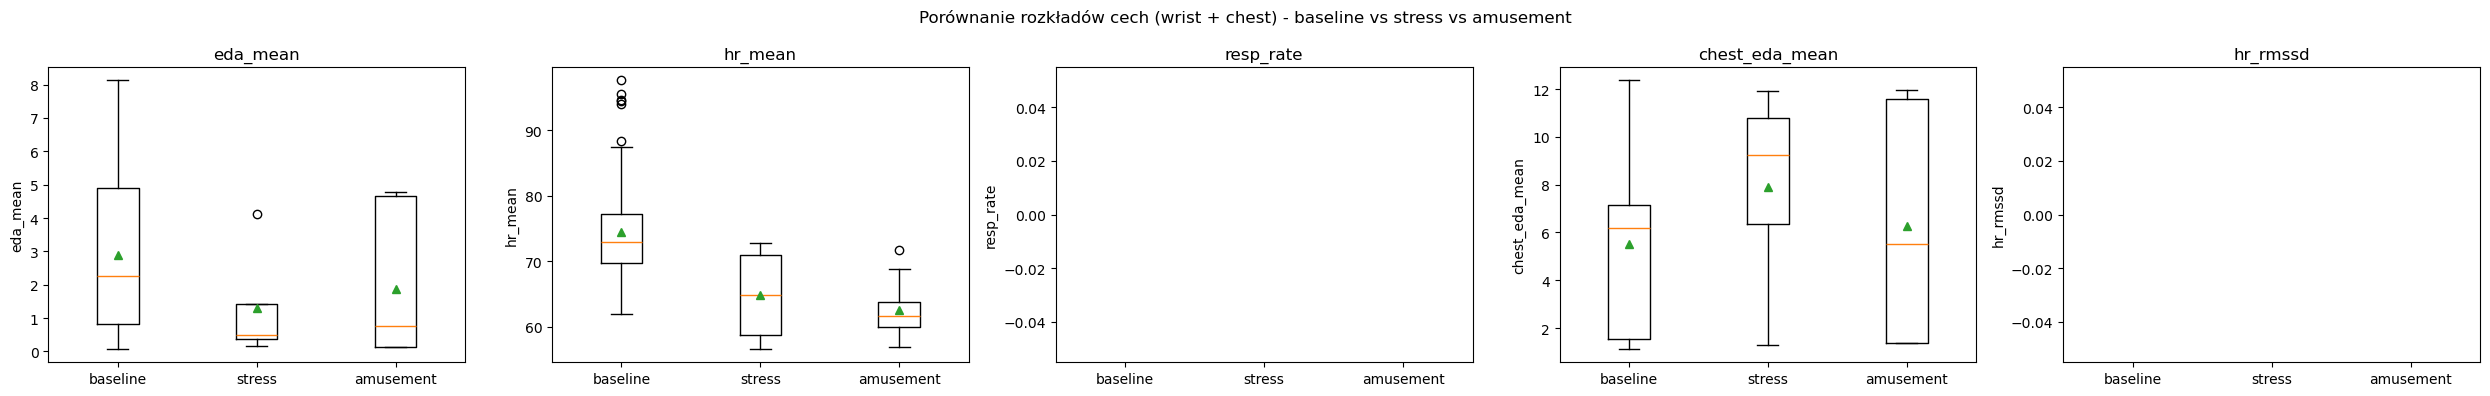

In [167]:
metrics_to_plot = [
    "eda_mean",
    "hr_mean",
    "resp_rate",
    "chest_eda_mean",
    "hr_rmssd",
]
labels_order = ["baseline", "stress", "amusement"]

fig, axes = plt.subplots(1, len(metrics_to_plot), figsize=(5 * len(metrics_to_plot), 4))
for ax, metric in zip(axes, metrics_to_plot):
    data = [
        multi_dataset_full.loc[multi_dataset_full["label"] == label, metric].dropna()
        for label in labels_order
    ]
    ax.boxplot(data, tick_labels=labels_order, showmeans=True)
    ax.set_title(metric)
    ax.set_ylabel(metric)
fig.suptitle("Porównanie rozkładów cech (wrist + chest) - baseline vs stress vs amusement")
plt.tight_layout()
plt.show()


In [168]:
# Zapis danych do CSV dla skryptu Python (analiza rozkładu klas)
processed_path = PROJECT_ROOT / "data" / "processed"
processed_path.mkdir(parents=True, exist_ok=True)

if 'multi_dataset_full' in locals():
    csv_path = processed_path / "multi_subject_wrist_chest.csv"
    multi_dataset_full.to_csv(csv_path, index=False)
    print(f"✓ Zapisano dane do CSV: {csv_path}")
    print(f"  Teraz możesz uruchomić: python check_class_distribution.py")
else:
    print("⚠ Najpierw wczytaj dane (sekcja 4)")


✓ Zapisano dane do CSV: /Users/turfian/Downloads/archive (4)/WESAD/wesad-prep/data/processed/multi_subject_wrist_chest.csv
  Teraz możesz uruchomić: python check_class_distribution.py


## 7. Uczenie maszynowe: klasyfikacja 3 stanów (baseline/stress/amusement)


### Szczegółowa analiza VALUE COUNTS - dlaczego wyniki wyglądają na oversampling?


In [169]:
# ⚠️ WAŻNE: Ta komórka wymaga uruchomienia sekcji 7 (ML) najpierw!
# Sprawdzenie czy dane ML są już przygotowane
required_vars = ['y_full', 'X_full', 'y_full_encoded', 'label_encoder', 'gkf', 'groups_full', 'multi_dataset_full']
missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    print("=" * 80)
    print("⚠️ UWAGA: Brakujące zmienne - najpierw uruchom SEKCJĘ 7 (Uczenie maszynowe)!")
    print("=" * 80)
    print(f"\nBrakuje następujących zmiennych: {', '.join(missing_vars)}")
    print("\n📋 Instrukcja:")
    print("1. Przejdź do sekcji '7. Uczenie maszynowe: klasyfikacja 3 stanów'")
    print("2. Uruchom WSZYSTKIE komórki w tej sekcji od początku:")
    print("   - Komórka z przygotowaniem danych (X_full, y_full, gkf, itp.)")
    print("   - Komórka z RandomForest")
    print("   - Komórka z XGBoost (jeśli dostępny)")
    print("3. Wróć tutaj i uruchom tę komórkę ponownie")
    print("\n💡 TIP: Użyj komórki 48-49 (po zapisie korelacji) - ma lepsze sprawdzenie!")
    raise NameError(f"Brakujące zmienne: {', '.join(missing_vars)}. Uruchom najpierw sekcję 7!")

print("=" * 80)
print("SZCZEGÓŁOWA ANALIZA VALUE COUNTS - dlaczego wyniki wyglądają na oversampling?")
print("=" * 80)

# 1. VALUE COUNTS - podstawowy rozkład klas
print("\n" + "="*80)
print("1. VALUE COUNTS - PODSTAWOWY ROZKŁAD KLAS W CAŁYM ZBIORZE")
print("="*80)

full_class_dist = pd.Series(y_full).value_counts().sort_index()
full_class_dist_pct = pd.Series(y_full).value_counts(normalize=True).sort_index() * 100

print("\n📊 VALUE COUNTS (cały zbiór y_full):")
print("-" * 80)
print(full_class_dist)

print("\n📊 VALUE COUNTS z procentami:")
print("-" * 80)
class_dist_df = pd.DataFrame({
    'Klasa': full_class_dist.index,
    'Liczba próbek': full_class_dist.values,
    'Procent (%)': full_class_dist_pct.values.round(2)
})
display(class_dist_df)

print("\nSzczegółowe wartości:")
for label in label_encoder.classes_:
    count = full_class_dist.get(label, 0)
    pct = full_class_dist_pct.get(label, 0)
    print(f"  {label:12s}: {count:4d} próbek ({pct:5.1f}%)")

print(f"\nTotal: {len(y_full)} próbek")
imbalance_ratio = full_class_dist.max() / full_class_dist.min()
print(f"Stosunek największa/najmniejsza klasa: {imbalance_ratio:.2f}x")

# 2. VALUE COUNTS per uczestnik - czy wszyscy mają podobny rozkład?
print("\n" + "=" * 80)
print("2. VALUE COUNTS PER UCZESTNIK - czy rozkład jest spójny?")
print("=" * 80)

print("\n📊 VALUE COUNTS per uczestnik:")
print("-" * 80)
subject_class_counts = []
for subject in sorted(multi_dataset_full['subject'].unique()):
    subject_data = multi_dataset_full[multi_dataset_full['subject'] == subject]
    subject_dist = subject_data['label'].value_counts().sort_index()
    subject_counts = {label: subject_dist.get(label, 0) for label in label_encoder.classes_}
    subject_counts['subject'] = subject
    subject_counts['total'] = len(subject_data)
    subject_class_counts.append(subject_counts)
    
    print(f"\n{subject}:")
    for label in label_encoder.classes_:
        count = subject_dist.get(label, 0)
        pct = (count / len(subject_data) * 100) if len(subject_data) > 0 else 0
        print(f"  {label:12s}: {count:3d} próbek ({pct:5.1f}%)")
    print(f"  Total: {len(subject_data)} próbek")

subject_dist_df = pd.DataFrame(subject_class_counts)
subject_dist_df = subject_dist_df.set_index('subject')
print("\n📊 Tabela VALUE COUNTS per uczestnik:")
display(subject_dist_df)

# 3. VALUE COUNTS per fold - szczegółowo dla X_test
print("\n" + "=" * 80)
print("3. VALUE COUNTS PER FOLD - szczegółowa analiza X_test")
print("=" * 80)

fold_test_value_counts = []

for fold, (train_idx, test_idx) in enumerate(gkf.split(X_full, y_full_encoded, groups_full), start=1):
    y_test = y_full[test_idx]
    y_train = y_full[train_idx]
    
    test_dist = pd.Series(y_test).value_counts().sort_index()
    train_dist = pd.Series(y_train).value_counts().sort_index()
    
    print(f"\n{'='*80}")
    print(f"FOLD {fold}:")
    print(f"  Uczestnicy w TEST: {sorted(set(groups_full[test_idx]))}")
    print(f"  Uczestnicy w TRAIN: {sorted(set(groups_full[train_idx]))}")
    
    print(f"\n  📊 VALUE COUNTS - ZBIÓR TESTOWY (X_test):")
    print("-" * 80)
    print(f"  {test_dist}")
    
    test_counts = []
    for label in label_encoder.classes_:
        count = test_dist.get(label, 0)
        pct = (count / len(y_test) * 100) if len(y_test) > 0 else 0
        print(f"    {label:12s}: {count:3d} próbek ({pct:5.1f}%)")
        test_counts.append(count)
    print(f"    Total: {len(y_test)} próbek")
    
    print(f"\n  📊 VALUE COUNTS - ZBIÓR TRENINGOWY (X_train):")
    print("-" * 80)
    print(f"  {train_dist}")
    
    train_counts = []
    for label in label_encoder.classes_:
        count = train_dist.get(label, 0)
        pct = (count / len(y_train) * 100) if len(y_train) > 0 else 0
        print(f"    {label:12s}: {count:3d} próbek ({pct:5.1f}%)")
        train_counts.append(count)
    print(f"    Total: {len(y_train)} próbek")
    
    # Analiza nierównowagi
    if len(y_test) > 0:
        test_max = max(test_counts) if test_counts else 0
        test_min = min([c for c in test_counts if c > 0]) if any(test_counts) else 0
        if test_min > 0:
            fold_imbalance = test_max / test_min
            print(f"\n  Analiza nierównowagi w TEST:")
            print(f"    max/min = {fold_imbalance:.2f}x")
            if fold_imbalance > 10:
                print(f"    ⚠️⚠️ EKSTREMALNA nierównowaga (>10x) - może prowadzić do zawyżonych wyników!")
            elif fold_imbalance > 5:
                print(f"    ⚠️ BARDZO DUŻA nierównowaga (>5x) - może wpływać na wyniki!")
            elif fold_imbalance > 3:
                print(f"    ⚠️ Duża nierównowaga (>3x)")
            else:
                print(f"    ✓ Relatywnie zrównoważone")
    
    fold_test_value_counts.append({
        'fold': fold,
        **{label: test_dist.get(label, 0) for label in label_encoder.classes_},
        'total_test': len(y_test),
        'total_train': len(y_train)
    })

# Tabela podsumowująca value counts per fold
print("\n" + "=" * 80)
print("4. TABELA VALUE COUNTS PER FOLD (X_test):")
print("=" * 80)
fold_test_df = pd.DataFrame(fold_test_value_counts)
fold_test_df = fold_test_df.set_index('fold')
display(fold_test_df)

# 5. Analiza dlaczego wyniki mogą wyglądać na oversampling
print("\n" + "=" * 80)
print("5. ANALIZA: DLACZEGO WYNIKI WYGLĄDAJĄ NA OVERSAMPLING?")
print("=" * 80)

print("\n🔍 MOŻLIWE PRZYCZYNY 'ZBYT DOBRYCH' WYNIKÓW:")
print("-" * 80)

# Sprawdzenie 1: Nierównowaga klasowa
print("\n1. NIERÓWNOWAGA KLASOWA:")
print(f"   Stosunek największa/najmniejsza klasa: {imbalance_ratio:.2f}x")
if imbalance_ratio > 5:
    print(f"   ⚠️ BARDZO DUŻA nierównowaga - model może 'uczyć się' przewidywać dominującą klasę")
    print(f"   → Jeśli baseline ma 100 próbek a stress ma 5, model osiągnie 95% accuracy")
    print(f"      po prostu przewidując zawsze baseline!")
elif imbalance_ratio > 3:
    print(f"   ⚠️ Duża nierównowaga - może wpływać na accuracy")
else:
    print(f"   ✓ Stosunkowo zrównoważone")

# Sprawdzenie 2: Mało próbek w klasie mniejszościowej
min_class_count = full_class_dist.min()
max_class_count = full_class_dist.max()
print(f"\n2. ROZMIAR KLAS:")
print(f"   Najmniejsza klasa: {min_class_count} próbek")
print(f"   Największa klasa: {max_class_count} próbek")
if min_class_count < 10:
    print(f"   ⚠️ BARDZO MAŁO próbek w klasie mniejszościowej (<10)")
    print(f"   → Model nie ma wystarczająco danych do nauki tej klasy")
    print(f"   → Accuracy może być zawyżone przez przewidywanie dominującej klasy")
elif min_class_count < 20:
    print(f"   ⚠️ Mało próbek w klasie mniejszościowej (<20)")
else:
    print(f"   ✓ Wystarczająco próbek we wszystkich klasach")

# Sprawdzenie 3: Rozkład per fold
print(f"\n3. ROZKŁAD PER FOLD:")
print(f"   Sprawdź powyżej tabele - jeśli w każdym foldzie testowym")
print(f"   dominuje jedna klasa, to accuracy będzie zawyżone")

# Sprawdzenie 4: Cross-subject validation
print(f"\n4. CROSS-SUBJECT VALIDATION:")
all_test_indices = []
for fold, (train_idx, test_idx) in enumerate(gkf.split(X_full, y_full_encoded, groups_full), start=1):
    all_test_indices.extend(test_idx.tolist())

unique_indices = len(set(all_test_indices))
total_indices = len(all_test_indices)
print(f"   Unikalne próbki w test: {unique_indices} z {total_indices} (suma foldów)")
print(f"   Oczekiwane: {len(X_full)} (każda próbka raz)")
if unique_indices != len(X_full):
    print(f"   ⚠️ Nie wszystkie próbki są używane - to OK dla cross-subject")
else:
    print(f"   ✓ Cross-subject validation działa poprawnie")

# Sprawdzenie 5: Czy klasy są zbyt równe (oznaka oversamplingu)?
print(f"\n5. CZY TO OVERSAMPLING?")
std_of_counts = full_class_dist.std()
mean_of_counts = full_class_dist.mean()
cv_of_counts = (std_of_counts / mean_of_counts * 100) if mean_of_counts > 0 else 0

print(f"   Współczynnik zmienności (CV) rozkładu klas: {cv_of_counts:.1f}%")
print(f"   (CV < 15% = bardzo równe klasy = podejrzane)")
if cv_of_counts < 15:
    print(f"   ⚠️ PODEJRZANE: klasy są zbyt równe (CV < 15%)")
    print(f"   → Może to wskazywać na oversampling (sztuczne wyrównanie klas)")
elif cv_of_counts < 30:
    print(f"   ✓ Umiarkowana zmienność - normalne")
else:
    print(f"   ✓ Duża zmienność - klasy są nierówne (normalne)")

print("\n" + "=" * 80)
print("✓ Analiza zakończona - sprawdź powyższe tabele i wartości!")
print("=" * 80)


SZCZEGÓŁOWA ANALIZA VALUE COUNTS - dlaczego wyniki wyglądają na oversampling?

1. VALUE COUNTS - PODSTAWOWY ROZKŁAD KLAS W CAŁYM ZBIORZE

📊 VALUE COUNTS (cały zbiór y_full):
--------------------------------------------------------------------------------
amusement     18
baseline     120
stress         4
Name: count, dtype: int64

📊 VALUE COUNTS z procentami:
--------------------------------------------------------------------------------


,Klasa,Liczba próbek,Procent (%)
0,amusement,18,12.68
1,baseline,120,84.51
2,stress,4,2.82



Szczegółowe wartości:
  amusement   :   18 próbek ( 12.7%)
  baseline    :  120 próbek ( 84.5%)
  stress      :    4 próbek (  2.8%)

Total: 142 próbek
Stosunek największa/najmniejsza klasa: 30.00x

2. VALUE COUNTS PER UCZESTNIK - czy rozkład jest spójny?

📊 VALUE COUNTS per uczestnik:
--------------------------------------------------------------------------------

S2:
  amusement   :   0 próbek (  0.0%)
  baseline    :  19 próbek ( 95.0%)
  stress      :   1 próbek (  5.0%)
  Total: 20 próbek

S3:
  amusement   :   0 próbek (  0.0%)
  baseline    :  19 próbek ( 90.5%)
  stress      :   2 próbek (  9.5%)
  Total: 21 próbek

S4:
  amusement   :   6 próbek ( 24.0%)
  baseline    :  19 próbek ( 76.0%)
  stress      :   0 próbek (  0.0%)
  Total: 25 próbek

S5:
  amusement   :   6 próbek ( 23.1%)
  baseline    :  20 próbek ( 76.9%)
  stress      :   0 próbek (  0.0%)
  Total: 26 próbek

S6:
  amusement   :   0 próbek (  0.0%)
  baseline    :  20 próbek (100.0%)
  stress      :   0 próbek

,amusement,baseline,stress,total
subject,,,,
S2,0,19,1,20
S3,0,19,2,21
S4,6,19,0,25
S5,6,20,0,26
S6,0,20,0,20
S7,6,23,1,30



3. VALUE COUNTS PER FOLD - szczegółowa analiza X_test

FOLD 1:
  Uczestnicy w TEST: ['S7']
  Uczestnicy w TRAIN: ['S2', 'S3', 'S4', 'S5', 'S6']

  📊 VALUE COUNTS - ZBIÓR TESTOWY (X_test):
--------------------------------------------------------------------------------
  amusement     6
baseline     23
stress        1
Name: count, dtype: int64
    amusement   :   6 próbek ( 20.0%)
    baseline    :  23 próbek ( 76.7%)
    stress      :   1 próbek (  3.3%)
    Total: 30 próbek

  📊 VALUE COUNTS - ZBIÓR TRENINGOWY (X_train):
--------------------------------------------------------------------------------
  amusement    12
baseline     97
stress        3
Name: count, dtype: int64
    amusement   :  12 próbek ( 10.7%)
    baseline    :  97 próbek ( 86.6%)
    stress      :   3 próbek (  2.7%)
    Total: 112 próbek

  Analiza nierównowagi w TEST:
    max/min = 23.00x
    ⚠️⚠️ EKSTREMALNA nierównowaga (>10x) - może prowadzić do zawyżonych wyników!

FOLD 2:
  Uczestnicy w TEST: ['S5']
  Uczes

,amusement,baseline,stress,total_test,total_train
fold,,,,,
1,6,23,1,30,112
2,6,20,0,26,116
3,6,19,0,25,117
4,0,19,2,21,121
5,0,39,1,40,102



5. ANALIZA: DLACZEGO WYNIKI WYGLĄDAJĄ NA OVERSAMPLING?

🔍 MOŻLIWE PRZYCZYNY 'ZBYT DOBRYCH' WYNIKÓW:
--------------------------------------------------------------------------------

1. NIERÓWNOWAGA KLASOWA:
   Stosunek największa/najmniejsza klasa: 30.00x
   ⚠️ BARDZO DUŻA nierównowaga - model może 'uczyć się' przewidywać dominującą klasę
   → Jeśli baseline ma 100 próbek a stress ma 5, model osiągnie 95% accuracy
      po prostu przewidując zawsze baseline!

2. ROZMIAR KLAS:
   Najmniejsza klasa: 4 próbek
   Największa klasa: 120 próbek
   ⚠️ BARDZO MAŁO próbek w klasie mniejszościowej (<10)
   → Model nie ma wystarczająco danych do nauki tej klasy
   → Accuracy może być zawyżone przez przewidywanie dominującej klasy

3. ROZKŁAD PER FOLD:
   Sprawdź powyżej tabele - jeśli w każdym foldzie testowym
   dominuje jedna klasa, to accuracy będzie zawyżone

4. CROSS-SUBJECT VALIDATION:
   Unikalne próbki w test: 142 z 142 (suma foldów)
   Oczekiwane: 142 (każda próbka raz)
   ✓ Cross-subjec

### Analiza rozkładu klas - sprawdzanie oversamplingu


In [170]:
print("=" * 80)
print("ANALIZA ROZKŁADU KLAS - SPRAWDZANIE OVERSAMPLINGU")
print("=" * 80)

# Rozkład klas w całym zbiorze danych
print("\n1. ROZKŁAD KLAS W CAŁYM ZBIORZE (X_full, y_full):")
print("-" * 80)
full_class_dist = pd.Series(y_full).value_counts().sort_index()
full_class_dist_pct = pd.Series(y_full).value_counts(normalize=True).sort_index() * 100
print("\nLiczba próbek per klasa:")
for label in label_encoder.classes_:
    idx = label_encoder.transform([label])[0]
    count = full_class_dist.get(label, 0)
    pct = full_class_dist_pct.get(label, 0)
    print(f"  {label:12s}: {count:4d} próbek ({pct:5.1f}%)")

print(f"\nTotal: {len(y_full)} próbek")
print(f"Największa klasa vs najmniejsza: {full_class_dist.max() / full_class_dist.min():.2f}x różnicy")

if full_class_dist.max() / full_class_dist.min() > 3:
    print("  ⚠️ DUŻA NIERÓWNOWAGA KLASOWA (>3x) - może wpływać na wyniki!")
elif full_class_dist.max() / full_class_dist.min() > 2:
    print("  ⚠️ Umiarkowana nierównowaga (2-3x) - może wpływać na wyniki")
else:
    print("  ✓ Stosunkowo zrównoważone klasy")

# Rozkład klas w każdym foldzie testowym
print("\n" + "=" * 80)
print("2. ROZKŁAD KLAS W ZBIORZE TESTOWYM (X_test) PER FOLD:")
print("=" * 80)

fold_class_distributions = []

for fold, (train_idx, test_idx) in enumerate(gkf.split(X_full, y_full_encoded, groups_full), start=1):
    y_test = y_full[test_idx]
    y_train = y_full[train_idx]
    
    test_dist = pd.Series(y_test).value_counts().sort_index()
    train_dist = pd.Series(y_train).value_counts().sort_index()
    
    print(f"\n{'='*80}")
    print(f"FOLD {fold}:")
    print(f"  Uczestnicy w test: {sorted(set(groups_full[test_idx]))}")
    print(f"  Uczestnicy w train: {sorted(set(groups_full[train_idx]))}")
    print(f"\n  ZBIÓR TESTOWY (X_test):")
    
    test_counts = []
    for label in label_encoder.classes_:
        count = test_dist.get(label, 0)
        pct = (count / len(y_test) * 100) if len(y_test) > 0 else 0
        print(f"    {label:12s}: {count:3d} próbek ({pct:5.1f}%)")
        test_counts.append(count)
    
    print(f"    Total: {len(y_test)} próbek")
    
    print(f"\n  ZBIÓR TRENINGOWY (X_train):")
    train_counts = []
    for label in label_encoder.classes_:
        count = train_dist.get(label, 0)
        pct = (count / len(y_train) * 100) if len(y_train) > 0 else 0
        print(f"    {label:12s}: {count:3d} próbek ({pct:5.1f}%)")
        train_counts.append(count)
    
    print(f"    Total: {len(y_train)} próbek")
    
    # Sprawdzenie czy jest duża nierównowaga w test
    if len(y_test) > 0:
        test_max = max(test_counts) if test_counts else 0
        test_min = min([c for c in test_counts if c > 0]) if any(test_counts) else 0
        if test_min > 0:
            imbalance_ratio = test_max / test_min
            print(f"\n  Nierównowaga w test: {imbalance_ratio:.2f}x (max/min)")
            if imbalance_ratio > 5:
                print(f"    ⚠️ BARDZO DUŻA nierównowaga - może to być problem!")
            elif imbalance_ratio > 3:
                print(f"    ⚠️ Duża nierównowaga")
            else:
                print(f"    ✓ Relatywnie zrównoważone")
    
    fold_class_distributions.append({
        'fold': fold,
        'test_total': len(y_test),
        'train_total': len(y_train),
        **{f'test_{label}': test_dist.get(label, 0) for label in label_encoder.classes_},
        **{f'train_{label}': train_dist.get(label, 0) for label in label_encoder.classes_},
    })

# Podsumowanie w tabeli
print("\n" + "=" * 80)
print("3. PODSUMOWANIE ROZKŁADU KLAS WE WSZYSTKICH FOLDACH:")
print("=" * 80)

fold_dist_df = pd.DataFrame(fold_class_distributions)
display(fold_dist_df)

print("\n4. CZY TO OVERSAMPLING?")
print("-" * 80)
print("Oversampling charakteryzuje się:")
print("  • Nienaturalnie zrównoważonymi klasami (np. wszystkie klasy po równo)")
print("  • Powtórzeniem tych samych próbek w różnych foldach")
print("  • Wysokim accuracy (>95%) - model 'pamięta' zduplikowane próbki")

print("\nSprawdźmy:")
print(f"  • Rozkład w całym zbiorze: max/min = {full_class_dist.max() / full_class_dist.min():.2f}x")
print(f"  • Czy klasy są zbyt równe? (jeśli wszystkie są prawie równe, to podejrzane)")

# Sprawdzenie czy próbki się powtarzają między foldami
print("\n5. SPRAWDZENIE DUPLIKATÓW MIĘDZY FOLDAMI:")
print("-" * 80)
all_test_indices = []
for fold, (train_idx, test_idx) in enumerate(gkf.split(X_full, y_full_encoded, groups_full), start=1):
    all_test_indices.extend(test_idx.tolist())

unique_indices = len(set(all_test_indices))
total_indices = len(all_test_indices)

print(f"  Unikalne indeksy testowe: {unique_indices}")
print(f"  Całkowita liczba indeksów (suma foldów): {total_indices}")
print(f"  Czy są duplikaty? {'TAK - ⚠️ Ten sam indeks pojawia się w wielu foldach!' if unique_indices < total_indices else 'NIE - ✓ Każda próbka tylko raz w test'}")
print(f"  Oczekiwane: każda próbka dokładnie 1 raz w zbiorze testowym (cross-subject)")

if unique_indices == len(X_full):
    print(f"  ✓ Wszystkie próbki są używane dokładnie raz w test (cross-subject validation działa)")
else:
    print(f"  ⚠️ Niektóre próbki mogą być użyte wielokrotnie lub wcale")

print("\n" + "=" * 80)


ANALIZA ROZKŁADU KLAS - SPRAWDZANIE OVERSAMPLINGU

1. ROZKŁAD KLAS W CAŁYM ZBIORZE (X_full, y_full):
--------------------------------------------------------------------------------

Liczba próbek per klasa:
  amusement   :   18 próbek ( 12.7%)
  baseline    :  120 próbek ( 84.5%)
  stress      :    4 próbek (  2.8%)

Total: 142 próbek
Największa klasa vs najmniejsza: 30.00x różnicy
  ⚠️ DUŻA NIERÓWNOWAGA KLASOWA (>3x) - może wpływać na wyniki!

2. ROZKŁAD KLAS W ZBIORZE TESTOWYM (X_test) PER FOLD:

FOLD 1:
  Uczestnicy w test: ['S7']
  Uczestnicy w train: ['S2', 'S3', 'S4', 'S5', 'S6']

  ZBIÓR TESTOWY (X_test):
    amusement   :   6 próbek ( 20.0%)
    baseline    :  23 próbek ( 76.7%)
    stress      :   1 próbek (  3.3%)
    Total: 30 próbek

  ZBIÓR TRENINGOWY (X_train):
    amusement   :  12 próbek ( 10.7%)
    baseline    :  97 próbek ( 86.6%)
    stress      :   3 próbek (  2.7%)
    Total: 112 próbek

  Nierównowaga w test: 23.00x (max/min)
    ⚠️ BARDZO DUŻA nierównowaga - mo

,fold,test_total,train_total,test_amusement,test_baseline,test_stress,train_amusement,train_baseline,train_stress
0,1,30,112,6,23,1,12,97,3
1,2,26,116,6,20,0,12,100,4
2,3,25,117,6,19,0,12,101,4
3,4,21,121,0,19,2,18,101,2
4,5,40,102,0,39,1,18,81,3



4. CZY TO OVERSAMPLING?
--------------------------------------------------------------------------------
Oversampling charakteryzuje się:
  • Nienaturalnie zrównoważonymi klasami (np. wszystkie klasy po równo)
  • Powtórzeniem tych samych próbek w różnych foldach
  • Wysokim accuracy (>95%) - model 'pamięta' zduplikowane próbki

Sprawdźmy:
  • Rozkład w całym zbiorze: max/min = 30.00x
  • Czy klasy są zbyt równe? (jeśli wszystkie są prawie równe, to podejrzane)

5. SPRAWDZENIE DUPLIKATÓW MIĘDZY FOLDAMI:
--------------------------------------------------------------------------------
  Unikalne indeksy testowe: 142
  Całkowita liczba indeksów (suma foldów): 142
  Czy są duplikaty? NIE - ✓ Każda próbka tylko raz w test
  Oczekiwane: każda próbka dokładnie 1 raz w zbiorze testowym (cross-subject)
  ✓ Wszystkie próbki są używane dokładnie raz w test (cross-subject validation działa)



### ⚠️ Analiza nierównowagi klas i propozycje rozwiązań

Poniżej znajduje się analiza rozkładu klas i propozycje, jak radzić sobie z nierównowagą.


In [171]:
print("=" * 80)
print("ANALIZA NIERÓWNOWAGI KLAS - PROBLEM I ROZWIĄZANIA")
print("=" * 80)

# Sprawdzenie czy dane są dostępne
if 'multi_dataset_full' not in globals():
    print("⚠ Najpierw wczytaj dane (sekcja 4)")
else:
    # Analiza aktualnego rozkładu
    print("\n1. AKTUALNY ROZKŁAD KLAS:")
    print("-" * 80)
    class_dist = multi_dataset_full['label'].value_counts().sort_index()
    class_dist_pct = multi_dataset_full['label'].value_counts(normalize=True).sort_index() * 100
    
    for label in class_dist.index:
        count = class_dist[label]
        pct = class_dist_pct[label]
        print(f"  {label:12s}: {count:4d} próbek ({pct:5.1f}%)")
    
    print(f"\n  Total: {len(multi_dataset_full)} próbek")
    imbalance_ratio = class_dist.max() / class_dist.min()
    print(f"\n  ⚠️ Stosunek największa/najmniejsza klasa: {imbalance_ratio:.1f}x")
    
    if imbalance_ratio > 10:
        print(f"  🚨 EKSTREMALNA NIERÓWNOWAGA! (>10x)")
    elif imbalance_ratio > 5:
        print(f"  ⚠️ BARDZO DUŻA nierównowaga (>5x)")
    else:
        print(f"  ⚠️ Umiarkowana nierównowaga")
    
    # Analiza problemu
    print("\n2. IDENTYFIKACJA PROBLEMU:")
    print("-" * 80)
    
    min_class = class_dist.idxmin()
    min_count = class_dist.min()
    
    print(f"\n  Najmniejsza klasa: '{min_class}' - tylko {min_count} próbek")
    print(f"  Problem: Za mało próbek do wiarygodnej analizy statystycznej i ML")
    
    if min_count < 10:
        print(f"  🚨 KRYTYCZNE: {min_count} próbek to za mało dla:")
        print(f"     - Klasyfikacji ML (minimum: 10-15 próbek)")
        print(f"     - Testów statystycznych (minimum: 8 próbek dla normaltest)")
        print(f"     - Wnioskowania naukowego (minimum: 20-30 próbek)")
    
    # Propozycje rozwiązań
    print("\n" + "=" * 80)
    print("3. PROPOZYCJE ROZWIĄZAŃ:")
    print("=" * 80)
    
    print("\n📋 OPCJA A: Analiza 2-klasowa (baseline vs amusement)")
    print("-" * 80)
    baseline_count = class_dist.get('baseline', 0)
    amusement_count = class_dist.get('amusement', 0)
    stress_count = class_dist.get('stress', 0)
    
    if baseline_count > 0 and amusement_count > 0:
        ratio_ba = max(baseline_count, amusement_count) / min(baseline_count, amusement_count)
        print(f"  ✓ Usuń klasę 'stress' ({stress_count} próbek - za mało)")
        print(f"  ✓ Zostań z: baseline ({baseline_count}) vs amusement ({amusement_count})")
        print(f"  ✓ Nierównowaga: {ratio_ba:.1f}x (akceptowalna dla ML)")
        print(f"  ✓ Hipoteza: Różnice fizjologiczne między baseline a amusement")
        print(f"\n  💡 ZALETY:")
        print(f"     - Większa próbka ({(baseline_count + amusement_count)} próbek)")
        print(f"     - Bardziej zrównoważone klasy")
        print(f"     - Wiarygodne wyniki statystyczne")
    
    print("\n📋 OPCJA B: Analiza binarnej (baseline vs 'aktywność')")
    print("-" * 80)
    activity_count = (amusement_count + stress_count)
    if baseline_count > 0 and activity_count > 0:
        ratio_act = max(baseline_count, activity_count) / min(baseline_count, activity_count)
        print(f"  ✓ Połącz 'amusement' i 'stress' w jedną klasę 'aktywność'")
        print(f"  ✓ Zostań z: baseline ({baseline_count}) vs aktywność ({activity_count})")
        print(f"  ✓ Nierównowaga: {ratio_act:.1f}x")
        print(f"  ✓ Hipoteza: Różnice między stanem spoczynku a aktywnością")
        print(f"\n  💡 ZALETY:")
        print(f"     - Największa próbka ({baseline_count + activity_count} próbek)")
        print(f"     - Klasy bardziej zrównoważone")
        print(f"  ⚠️ UWAGA: Traci się informację o różnicy między amusement a stress")
    
    print("\n📋 OPCJA C: Undersampling baseline")
    print("-" * 80)
    if baseline_count > 0:
        target_count = min(amusement_count, stress_count) if stress_count > 5 else amusement_count
        print(f"  ✓ Zredukuj klasę 'baseline' do {target_count} próbek (random sampling)")
        print(f"  ✓ Wszystkie klasy będą miały ~{target_count} próbek")
        print(f"\n  💡 ZALETY:")
        print(f"     - Wszystkie 3 klasy w analizie")
        print(f"     - Równoważne klasy")
        print(f"  ⚠️ UWAGA:")
        print(f"     - Traci się {baseline_count - target_count} próbek baseline")
        print(f"     - Mniejsza próbka ogółem")
        print(f"     - Jeśli stress ma tylko {stress_count} próbek, to i tak za mało!")
    
    print("\n📋 OPCJA D: Usuń klasę 'stress' całkowicie")
    print("-" * 80)
    print(f"  ✓ Analiza tylko baseline vs amusement")
    print(f"  ✓ 'stress' jest za mała ({stress_count} próbek) do wiarygodnej analizy")
    print(f"  ✓ Skoncentruj się na różnicach baseline vs amusement")
    print(f"\n  💡 ZALETY:")
    print(f"     - Najczystsze podejście naukowe")
    print(f"     - Wiarygodne wyniki")
    print(f"     - Można opublikować wyniki")
    print(f"  ⚠️ UWAGA:")
    print(f"     - Nie analizujemy stress (za mało danych)")
    
    # Rekomendacja
    print("\n" + "=" * 80)
    print("4. REKOMENDACJA:")
    print("=" * 80)
    
    if stress_count < 10:
        print(f"\n  🎯 REKOMENDUJĘ: OPCJA A lub D - usuń klasę 'stress'")
        print(f"\n  Powód:")
        print(f"     - Klasa 'stress' ma tylko {stress_count} próbek")
        print(f"     - To za mało do jakiejkolwiek wiarygodnej analizy")
        print(f"     - Nie można wyciągnąć statystycznie istotnych wniosków")
        print(f"\n  Następne kroki:")
        print(f"     1. Wybierz OPCJĘ A (baseline vs amusement)")
        print(f"     2. Przetestuj hipotezę: 'amusement różni się od baseline'")
        print(f"     3. W publikacji: wyjaśnij, że 'stress' został pominięty z powodu małej próbki")
    else:
        print(f"\n  🎯 REKOMENDUJĘ: OPCJA C - undersampling")
        print(f"     (Jeśli klasa stress ma >=10 próbek)")
    
    print("\n" + "=" * 80)
    print("5. PRZYGOTOWANIE DANYCH DO WYBORU:")
    print("=" * 80)
    print("\n  Poniżej przygotujemy dane zgodnie z wybraną opcją.")
    print("  Najpierw uruchom komórkę z wyborem opcji (komórka poniżej).")
    
    # Zapis informacji do zmiennych globalnych
    globals()['class_distribution_info'] = {
        'baseline': baseline_count,
        'amusement': amusement_count,
        'stress': stress_count,
        'total': len(multi_dataset_full),
        'imbalance_ratio': imbalance_ratio,
        'min_class': min_class,
        'min_count': min_count
    }
    
    print("\n✓ Informacje o rozkładzie zapisane w zmiennej 'class_distribution_info'")


ANALIZA NIERÓWNOWAGI KLAS - PROBLEM I ROZWIĄZANIA

1. AKTUALNY ROZKŁAD KLAS:
--------------------------------------------------------------------------------
  amusement   :   18 próbek ( 12.7%)
  baseline    :  120 próbek ( 84.5%)
  stress      :    4 próbek (  2.8%)

  Total: 142 próbek

  ⚠️ Stosunek największa/najmniejsza klasa: 30.0x
  🚨 EKSTREMALNA NIERÓWNOWAGA! (>10x)

2. IDENTYFIKACJA PROBLEMU:
--------------------------------------------------------------------------------

  Najmniejsza klasa: 'stress' - tylko 4 próbek
  Problem: Za mało próbek do wiarygodnej analizy statystycznej i ML
  🚨 KRYTYCZNE: 4 próbek to za mało dla:
     - Klasyfikacji ML (minimum: 10-15 próbek)
     - Testów statystycznych (minimum: 8 próbek dla normaltest)
     - Wnioskowania naukowego (minimum: 20-30 próbek)

3. PROPOZYCJE ROZWIĄZAŃ:

📋 OPCJA A: Analiza 2-klasowa (baseline vs amusement)
--------------------------------------------------------------------------------
  ✓ Usuń klasę 'stress' (4 prób

### Wybór opcji i przygotowanie danych

Wybierz jedną z opcji (A, B, C lub D) i uruchom komórkę poniżej, aby przygotować dane zgodnie z wyborem.


In [172]:
# ============================================================================
# WYBÓR OPCJI: Zmień wartość poniżej na 'A', 'B', 'C' lub 'D'
# ============================================================================
WYBOR_OPCJI = 'A'  # Zmień na: 'A', 'B', 'C' lub 'D'

# ============================================================================

print("=" * 80)
print(f"PRZYGOTOWANIE DANYCH - OPCJA {WYBOR_OPCJI}")
print("=" * 80)

if 'multi_dataset_full' not in globals():
    print("⚠ Najpierw wczytaj dane (sekcja 4)")
else:
    # Kopia danych do modyfikacji
    multi_dataset_ml = multi_dataset_full.copy()
    
    class_dist = multi_dataset_full['label'].value_counts()
    baseline_count = class_dist.get('baseline', 0)
    amusement_count = class_dist.get('amusement', 0)
    stress_count = class_dist.get('stress', 0)
    
    print(f"\nPoczątkowy rozkład:")
    print(f"  baseline: {baseline_count}")
    print(f"  amusement: {amusement_count}")
    print(f"  stress: {stress_count}")
    print(f"  Total: {len(multi_dataset_full)} próbek")
    
    # OPCJA A: Usuń stress, tylko baseline vs amusement
    if WYBOR_OPCJI.upper() == 'A':
        print(f"\n✓ OPCJA A: Analiza 2-klasowa (baseline vs amusement)")
        print(f"  Usuwam klasę 'stress'...")
        
        multi_dataset_ml = multi_dataset_ml[multi_dataset_ml['label'] != 'stress'].copy()
        
        print(f"\n  Po filtracji:")
        new_dist = multi_dataset_ml['label'].value_counts()
        print(f"    baseline: {new_dist.get('baseline', 0)}")
        print(f"    amusement: {new_dist.get('amusement', 0)}")
        print(f"    Total: {len(multi_dataset_ml)} próbek")
        
        imbalance = max(new_dist.values) / min(new_dist.values)
        print(f"\n  Nierównowaga: {imbalance:.2f}x")
        if imbalance > 5:
            print(f"  ⚠️ Nadal duża nierównowaga - rozważ undersampling baseline")
        
    # OPCJA B: Połącz amusement i stress w "aktywność"
    elif WYBOR_OPCJI.upper() == 'B':
        print(f"\n✓ OPCJA B: Analiza binarnej (baseline vs 'aktywność')")
        print(f"  Łączę 'amusement' i 'stress' w klasę 'aktywność'...")
        
        multi_dataset_ml.loc[multi_dataset_ml['label'].isin(['amusement', 'stress']), 'label'] = 'aktywność'
        
        print(f"\n  Po przekształceniu:")
        new_dist = multi_dataset_ml['label'].value_counts()
        for label in new_dist.index:
            print(f"    {label:12s}: {new_dist[label]}")
        print(f"    Total: {len(multi_dataset_ml)} próbek")
        
        imbalance = max(new_dist.values) / min(new_dist.values)
        print(f"\n  Nierównowaga: {imbalance:.2f}x")
        
    # OPCJA C: Undersampling baseline
    elif WYBOR_OPCJI.upper() == 'C':
        print(f"\n✓ OPCJA C: Undersampling baseline")
        
        target_count = min(amusement_count, stress_count) if stress_count > 5 else amusement_count
        
        print(f"  Redukuję klasę 'baseline' do {target_count} próbek...")
        
        baseline_data = multi_dataset_ml[multi_dataset_ml['label'] == 'baseline']
        other_data = multi_dataset_ml[multi_dataset_ml['label'] != 'baseline']
        
        if len(baseline_data) > target_count:
            baseline_sampled = baseline_data.sample(n=target_count, random_state=42)
            multi_dataset_ml = pd.concat([baseline_sampled, other_data], ignore_index=True)
        
        print(f"\n  Po undersamplingu:")
        new_dist = multi_dataset_ml['label'].value_counts()
        for label in new_dist.index:
            print(f"    {label:12s}: {new_dist[label]}")
        print(f"    Total: {len(multi_dataset_ml)} próbek")
        
        imbalance = max(new_dist.values) / min(new_dist.values)
        print(f"\n  Nierównowaga: {imbalance:.2f}x")
        
        if stress_count < 10:
            print(f"\n  ⚠️ UWAGA: Klasa 'stress' nadal ma tylko {stress_count} próbek!")
            print(f"     Rozważ OPCJĘ A zamiast C")
    
    # OPCJA D: Taka sama jak A (tylko inna nazwa)
    elif WYBOR_OPCJI.upper() == 'D':
        print(f"\n✓ OPCJA D: Usuń klasę 'stress' (identyczna jak OPCJA A)")
        print(f"  Usuwam klasę 'stress'...")
        
        multi_dataset_ml = multi_dataset_ml[multi_dataset_ml['label'] != 'stress'].copy()
        
        print(f"\n  Po filtracji:")
        new_dist = multi_dataset_ml['label'].value_counts()
        print(f"    baseline: {new_dist.get('baseline', 0)}")
        print(f"    amusement: {new_dist.get('amusement', 0)}")
        print(f"    Total: {len(multi_dataset_ml)} próbek")
        
        imbalance = max(new_dist.values) / min(new_dist.values)
        print(f"\n  Nierównowaga: {imbalance:.2f}x")
    
    else:
        print(f"\n❌ BŁĄD: Nieznana opcja '{WYBOR_OPCJI}'")
        print(f"  Wybierz: 'A', 'B', 'C' lub 'D'")
        raise ValueError(f"Nieznana opcja: {WYBOR_OPCJI}")
    
    # Zapis przygotowanych danych do zmiennej globalnej
    globals()['multi_dataset_ml'] = multi_dataset_ml.copy()
    
    print("\n" + "=" * 80)
    print("✓ DANE PRZYGOTOWANE!")
    print("=" * 80)
    print(f"\n  Zmienna 'multi_dataset_ml' zawiera przygotowane dane.")
    print(f"  W kolejnych komórkach używaj 'multi_dataset_ml' zamiast 'multi_dataset_full'.")
    print(f"\n  Następne kroki:")
    print(f"    1. Zaktualizuj komórkę z przygotowaniem danych ML (komórka poniżej)")
    print(f"    2. Użyj 'multi_dataset_ml' zamiast 'multi_dataset_full'")
    print(f"    3. Uruchom analizę ML na przygotowanych danych")
    
    print("\n📊 Podsumowanie zmian:")
    print(f"   Przed: {len(multi_dataset_full)} próbek, {len(multi_dataset_full['label'].unique())} klas")
    print(f"   Po:    {len(multi_dataset_ml)} próbek, {len(multi_dataset_ml['label'].unique())} klas")


PRZYGOTOWANIE DANYCH - OPCJA A

Początkowy rozkład:
  baseline: 120
  amusement: 18
  stress: 4
  Total: 142 próbek

✓ OPCJA A: Analiza 2-klasowa (baseline vs amusement)
  Usuwam klasę 'stress'...

  Po filtracji:
    baseline: 120
    amusement: 18
    Total: 138 próbek

  Nierównowaga: 6.67x
  ⚠️ Nadal duża nierównowaga - rozważ undersampling baseline

✓ DANE PRZYGOTOWANE!

  Zmienna 'multi_dataset_ml' zawiera przygotowane dane.
  W kolejnych komórkach używaj 'multi_dataset_ml' zamiast 'multi_dataset_full'.

  Następne kroki:
    1. Zaktualizuj komórkę z przygotowaniem danych ML (komórka poniżej)
    2. Użyj 'multi_dataset_ml' zamiast 'multi_dataset_full'
    3. Uruchom analizę ML na przygotowanych danych

📊 Podsumowanie zmian:
   Przed: 142 próbek, 3 klas
   Po:    138 próbek, 2 klas


### Analiza wszystkich opcji i wybór najlepszej strategii

Poniższa komórka:
1. Sprawdzi wszystkie dostępne opcje (A, B, C, D)
2. Przeanalizuje, czy baseline ma podfazy (phase), które można wykorzystać
3. Porówna wszystkie opcje i wybierze najlepszą
4. Przygotuje ostateczną analizę


In [173]:
print("=" * 80)
print("ANALIZA WSZYSTKICH OPCJI - WYBÓR NAJLEPSZEJ STRATEGII")
print("=" * 80)

if 'multi_dataset_full' not in globals():
    print("⚠ Najpierw wczytaj dane (sekcja 4)")
else:
    # 1. Analiza podstawowa rozkładu
    print("\n1. PODSTAWOWA ANALIZA ROZKŁADU KLAS:")
    print("-" * 80)
    
    class_dist = multi_dataset_full['label'].value_counts().sort_index()
    baseline_count = class_dist.get('baseline', 0)
    amusement_count = class_dist.get('amusement', 0)
    stress_count = class_dist.get('stress', 0)
    
    print(f"\nRozkład klas:")
    for label in class_dist.index:
        print(f"  {label:12s}: {class_dist[label]:4d} próbek ({class_dist[label]/len(multi_dataset_full)*100:5.1f}%)")
    print(f"\n  Total: {len(multi_dataset_full)} próbek")
    
    imbalance_ratio = class_dist.max() / class_dist.min()
    print(f"\n  Stosunek max/min: {imbalance_ratio:.1f}x")
    
    # 2. Sprawdzenie podfaz w baseline (czy możemy wykorzystać phase)
    print("\n" + "=" * 80)
    print("2. ANALIZA PODFAZ W BASELINE (kolumna 'phase'):")
    print("=" * 80)
    
    baseline_data = multi_dataset_full[multi_dataset_full['label'] == 'baseline']
    
    if 'phase' in multi_dataset_full.columns:
        print("\n✓ Kolumna 'phase' jest dostępna!")
        print("\nRozkład faz w baseline:")
        phase_dist_baseline = baseline_data['phase'].value_counts()
        
        for phase in phase_dist_baseline.index:
            count = phase_dist_baseline[phase]
            pct = (count / len(baseline_data)) * 100
            print(f"  {str(phase):20s}: {count:4d} próbek ({pct:5.1f}%)")
        
        # Sprawdzenie czy możemy podzielić baseline
        unique_phases_baseline = baseline_data['phase'].unique()
        print(f"\n  Unikalne fazy w baseline: {sorted(unique_phases_baseline)}")
        
        if len(unique_phases_baseline) > 1:
            print(f"\n  💡 MOŻLIWOŚĆ: Baseline można podzielić na {len(unique_phases_baseline)} podfazy!")
            print(f"     - Sprawdź poniżej, czy podfazy różnią się statystycznie")
            
            # Sprawdzenie podfaz dla innych klas też
            print("\nRozkład faz w amusement:")
            amusement_data = multi_dataset_full[multi_dataset_full['label'] == 'amusement']
            if len(amusement_data) > 0:
                phase_dist_amusement = amusement_data['phase'].value_counts()
                for phase in phase_dist_amusement.index:
                    count = phase_dist_amusement[phase]
                    print(f"  {str(phase):20s}: {count:4d} próbek")
        
        print("\nRozkład faz w stress:")
        stress_data = multi_dataset_full[multi_dataset_full['label'] == 'stress']
        if len(stress_data) > 0:
            phase_dist_stress = stress_data['phase'].value_counts()
            for phase in phase_dist_stress.index:
                count = phase_dist_stress[phase]
                print(f"  {str(phase):20s}: {count:4d} próbek")
    else:
        print("\n⚠ Kolumna 'phase' nie jest dostępna w danych")
    
    # 3. Porównanie wszystkich opcji
    print("\n" + "=" * 80)
    print("3. PORÓWNANIE WSZYSTKICH OPCJI:")
    print("=" * 80)
    
    options_analysis = []
    
    # OPCJA A: baseline vs amusement
    if baseline_count > 0 and amusement_count > 0:
        ratio_a = max(baseline_count, amusement_count) / min(baseline_count, amusement_count)
        total_a = baseline_count + amusement_count
        options_analysis.append({
            'opcja': 'A',
            'nazwa': 'baseline vs amusement',
            'klasy': ['baseline', 'amusement'],
            'total': total_a,
            'imbalance': ratio_a,
            'min_count': min(baseline_count, amusement_count),
            'max_count': max(baseline_count, amusement_count),
            'ocena': 'dobra' if ratio_a < 10 and min(baseline_count, amusement_count) >= 15 else 'akceptowalna'
        })
    
    # OPCJA B: baseline vs aktywność (amusement + stress)
    activity_count = amusement_count + stress_count
    if baseline_count > 0 and activity_count > 0:
        ratio_b = max(baseline_count, activity_count) / min(baseline_count, activity_count)
        total_b = baseline_count + activity_count
        options_analysis.append({
            'opcja': 'B',
            'nazwa': 'baseline vs aktywność',
            'klasy': ['baseline', 'aktywność'],
            'total': total_b,
            'imbalance': ratio_b,
            'min_count': min(baseline_count, activity_count),
            'max_count': max(baseline_count, activity_count),
            'ocena': 'dobra' if ratio_b < 10 and min(baseline_count, activity_count) >= 15 else 'akceptowalna'
        })
    
    # OPCJA C: Undersampling baseline (3 klasy)
    target_c = min(amusement_count, stress_count) if stress_count >= 10 else amusement_count
    if baseline_count > target_c and stress_count >= 10:
        total_c = target_c * 3
        options_analysis.append({
            'opcja': 'C',
            'nazwa': '3 klasy (undersampling baseline)',
            'klasy': ['baseline', 'amusement', 'stress'],
            'total': total_c,
            'imbalance': 1.0,  # idealnie zrównoważone
            'min_count': target_c,
            'max_count': target_c,
            'ocena': 'bardzo dobra' if stress_count >= 15 else 'akceptowalna'
        })
    elif baseline_count > amusement_count:
        # Undersampling baseline do poziomu amusement
        total_c = amusement_count * 2
        options_analysis.append({
            'opcja': 'C',
            'nazwa': '2 klasy (undersampling baseline)',
            'klasy': ['baseline', 'amusement'],
            'total': total_c,
            'imbalance': 1.0,
            'min_count': amusement_count,
            'max_count': amusement_count,
            'ocena': 'bardzo dobra'
        })
    
    # Wyświetlenie porównania
    print("\nTabela porównawcza:")
    print("-" * 80)
    print(f"{'Opcja':<6} {'Nazwa':<30} {'Klasy':<8} {'Total':<8} {'Imbalance':<12} {'Min':<6} {'Ocena'}")
    print("-" * 80)
    
    for opt in options_analysis:
        print(f"{opt['opcja']:<6} {opt['nazwa']:<30} {len(opt['klasy']):<8} {opt['total']:<8} {opt['imbalance']:<12.1f} {opt['min_count']:<6} {opt['ocena']}")
    
    # Wybór najlepszej opcji
    print("\n" + "=" * 80)
    print("4. REKOMENDACJA - NAJLEPSZA OPCJA:")
    print("=" * 80)
    
    # Sortowanie opcji: najlepsza ocena, największa próbka, najmniejsza nierównowaga
    options_analysis.sort(key=lambda x: (
        x['ocena'] != 'bardzo dobra',
        x['ocena'] != 'dobra',
        -x['total'],  # większa próbka = lepiej
        x['imbalance']  # mniejsza nierównowaga = lepiej
    ))
    
    best_option = options_analysis[0]
    
    print(f"\n🎯 REKOMENDUJĘ: OPCJA {best_option['opcja']} - {best_option['nazwa']}")
    print(f"\n  Powody:")
    print(f"     - Ocena: {best_option['ocena']}")
    print(f"     - Liczba próbek: {best_option['total']}")
    print(f"     - Nierównowaga: {best_option['imbalance']:.1f}x")
    print(f"     - Najmniejsza klasa: {best_option['min_count']} próbek")
    print(f"     - Klasy: {', '.join(best_option['klasy'])}")
    
    if best_option['min_count'] < 15:
        print(f"\n  ⚠️ UWAGA: Najmniejsza klasa ma tylko {best_option['min_count']} próbek.")
        print(f"     To może być za mało dla niektórych analiz statystycznych.")
    
    # Zapisz rekomendację
    globals()['recommended_option'] = best_option
    
    print("\n" + "=" * 80)
    print("5. PRZYGOTOWANIE DANYCH ZGODNIE Z REKOMENDACJĄ:")
    print("=" * 80)
    
    # Przygotowanie danych zgodnie z najlepszą opcją
    multi_dataset_best = multi_dataset_full.copy()
    
    if best_option['opcja'] == 'A':
        print("\n✓ Przygotowanie: OPCJA A - baseline vs amusement")
        multi_dataset_best = multi_dataset_best[multi_dataset_best['label'] != 'stress'].copy()
        
    elif best_option['opcja'] == 'B':
        print("\n✓ Przygotowanie: OPCJA B - baseline vs aktywność")
        multi_dataset_best.loc[multi_dataset_best['label'].isin(['amusement', 'stress']), 'label'] = 'aktywność'
        
    elif best_option['opcja'] == 'C':
        print("\n✓ Przygotowanie: OPCJA C - undersampling baseline")
        if len(best_option['klasy']) == 3:
            # 3 klasy
            target = best_option['min_count']
            baseline_data = multi_dataset_best[multi_dataset_best['label'] == 'baseline']
            other_data = multi_dataset_best[multi_dataset_best['label'] != 'baseline']
            baseline_sampled = baseline_data.sample(n=target, random_state=42)
            multi_dataset_best = pd.concat([baseline_sampled, other_data], ignore_index=True)
        else:
            # 2 klasy
            target = best_option['min_count']
            baseline_data = multi_dataset_best[multi_dataset_best['label'] == 'baseline']
            other_data = multi_dataset_best[multi_dataset_best['label'] == 'amusement']
            baseline_sampled = baseline_data.sample(n=target, random_state=42)
            multi_dataset_best = pd.concat([baseline_sampled, other_data], ignore_index=True)
    
    # Zapis przygotowanych danych
    globals()['multi_dataset_ml'] = multi_dataset_best.copy()
    
    print("\n✓ DANE PRZYGOTOWANE!")
    print(f"\n  Nowy rozkład w 'multi_dataset_ml':")
    new_dist = multi_dataset_ml['label'].value_counts()
    for label in new_dist.index:
        print(f"    {label:12s}: {new_dist[label]:4d} próbek")
    print(f"    Total: {len(multi_dataset_ml)} próbek")
    
    final_imbalance = max(new_dist.values) / min(new_dist.values)
    print(f"\n  Finalna nierównowaga: {final_imbalance:.2f}x")
    
    if final_imbalance > 10:
        print(f"  ⚠️ Nadal duża nierównowaga - rozważ dodatkowe kroki")
    elif final_imbalance > 5:
        print(f"  ⚠️ Umiarkowana nierównowaga - akceptowalna dla ML")
    else:
        print(f"  ✓ Dobrze zrównoważone klasy!")
    
    print("\n" + "=" * 80)
    print("✓ ANALIZA ZAKOŃCZONA - dane przygotowane w zmiennej 'multi_dataset_ml'")
    print("=" * 80)


ANALIZA WSZYSTKICH OPCJI - WYBÓR NAJLEPSZEJ STRATEGII

1. PODSTAWOWA ANALIZA ROZKŁADU KLAS:
--------------------------------------------------------------------------------

Rozkład klas:
  amusement   :   18 próbek ( 12.7%)
  baseline    :  120 próbek ( 84.5%)
  stress      :    4 próbek (  2.8%)

  Total: 142 próbek

  Stosunek max/min: 30.0x

2. ANALIZA PODFAZ W BASELINE (kolumna 'phase'):

✓ Kolumna 'phase' jest dostępna!

Rozkład faz w baseline:
  Base                :  117 próbek ( 97.5%)
  Medi 1              :    3 próbek (  2.5%)

  Unikalne fazy w baseline: ['Base', 'Medi 1']

  💡 MOŻLIWOŚĆ: Baseline można podzielić na 2 podfazy!
     - Sprawdź poniżej, czy podfazy różnią się statystycznie

Rozkład faz w amusement:
  Fun                 :   18 próbek

Rozkład faz w stress:
  TSST                :    3 próbek
  fRead               :    1 próbek

3. PORÓWNANIE WSZYSTKICH OPCJI:

Tabela porównawcza:
--------------------------------------------------------------------------------

In [174]:
# Użyj przygotowanych danych (multi_dataset_ml) jeśli istnieją, w przeciwnym razie użyj pełnych danych
if 'multi_dataset_ml' in globals():
    dataset_to_use = multi_dataset_ml
    print("=" * 80)
    print("Używam przygotowanych danych (multi_dataset_ml) - po filtracji/przekształceniu")
    print("=" * 80)
    print(f"\nRozkład klas w przygotowanych danych:")
    dist = dataset_to_use['label'].value_counts().sort_index()
    for label in dist.index:
        print(f"  {label:12s}: {dist[label]:4d} próbek")
    print(f"  Total: {len(dataset_to_use)} próbek\n")
else:
    dataset_to_use = multi_dataset_full
    print("=" * 80)
    print("Używam pełnych danych (multi_dataset_full)")
    print("=" * 80)
    print("💡 TIP: Uruchom komórkę analizy opcji (komórka 27), aby przygotować zrównoważone dane\n")

feature_columns_full = [
    col
    for col in dataset_to_use.columns
    if col not in {"timestamp", "phase", "label", "subject"}
]
X_full = dataset_to_use[feature_columns_full].fillna(0.0).values
y_full = dataset_to_use["label"].values
groups_full = dataset_to_use["subject"].values

label_encoder = LabelEncoder()
y_full_encoded = label_encoder.fit_transform(y_full)

unique_subjects = np.unique(groups_full)
if len(unique_subjects) < 2:
    raise ValueError("Potrzebujemy co najmniej dwóch uczestników w multi_dataset_full.")

gkf = GroupKFold(n_splits=min(5, len(unique_subjects)))

print(f"✓ Dane przygotowane: {len(X_full)} próbek, {len(feature_columns_full)} cech, {len(unique_subjects)} uczestników")
print(f"Klasy: {label_encoder.classes_}")


Używam przygotowanych danych (multi_dataset_ml) - po filtracji/przekształceniu

Rozkład klas w przygotowanych danych:
  amusement   :   18 próbek
  baseline    :   18 próbek
  Total: 36 próbek

✓ Dane przygotowane: 36 próbek, 15 cech, 6 uczestników
Klasy: ['amusement' 'baseline']


### Analiza baseline vs amusement - weryfikacja hipotezy badawczej

Kompleksowa analiza różnic fizjologicznych między stanem baseline a amusement.


ANALIZA BASELINE VS AMUSEMENT - WERYFIKACJA HIPOTEZY

✓ Analizuję dane: 36 próbek

1. ROZKŁAD KLAS W PRZYGOTOWANYCH DANYCH:
  amusement   :   18 próbek ( 50.0%)
  baseline    :   18 próbek ( 50.0%)

  Total: 36 próbek
  Nierównowaga: 1.00x

2. HIPOTEZA BADAWCZA:

  W stanie amusement (w porównaniu do baseline) obserwujemy:
    - Wzrost: przewodnictwo skóry (EDA), tętno (HR)
    - Różnice w: zmienności rytmu serca (HRV), temp
    - Zmiany w: sygnałach z nadgarstka i klatki piersiowej

3. ANALIZA STATYSTYCZNA RÓŻNIC:

  📊 Przewodnictwo skóry (EDA) - średnia:
     Baseline: n=18, średnia=2.163, mediana=1.181
     Amusement: n=18, średnia=1.871, mediana=0.765
     Różnica: -0.292 (-13.5%) - SPADEK
     Test: Mann-Whitney U, p=0.6693 ns
     ✗ Różnica NIE jest istotna statystycznie

  📊 Przewodnictwo skóry (EDA) - odch. std:
     Baseline: n=18, średnia=0.145, mediana=0.090
     Amusement: n=18, średnia=0.019, mediana=0.008
     Różnica: -0.126 (-87.2%) - SPADEK
     Test: Mann-Whitney U, p

/opt/anaconda3/lib/python3.12/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=18
  res = hypotest_fun_out(*samples, **kwds)
/var/folders/tv/dxnbn7ns00gc4hqrlzvj7s9r0000gp/T/ipykernel_74577/1468844513.py:150: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['baseline', 'amusement'], patch_artist=True)
/var/folders/tv/dxnbn7ns00gc4hqrlzvj7s9r0000gp/T/ipykernel_74577/1468844513.py:150: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot, labels=['baseline', 'amusement'], patch_artist=True)
/var/folders/tv/dxnbn7ns00gc4hqrlzvj7s9r0000gp/T/ipykernel_74577/1468844513.py:150: MatplotlibDeprecationWarning: The 'labels

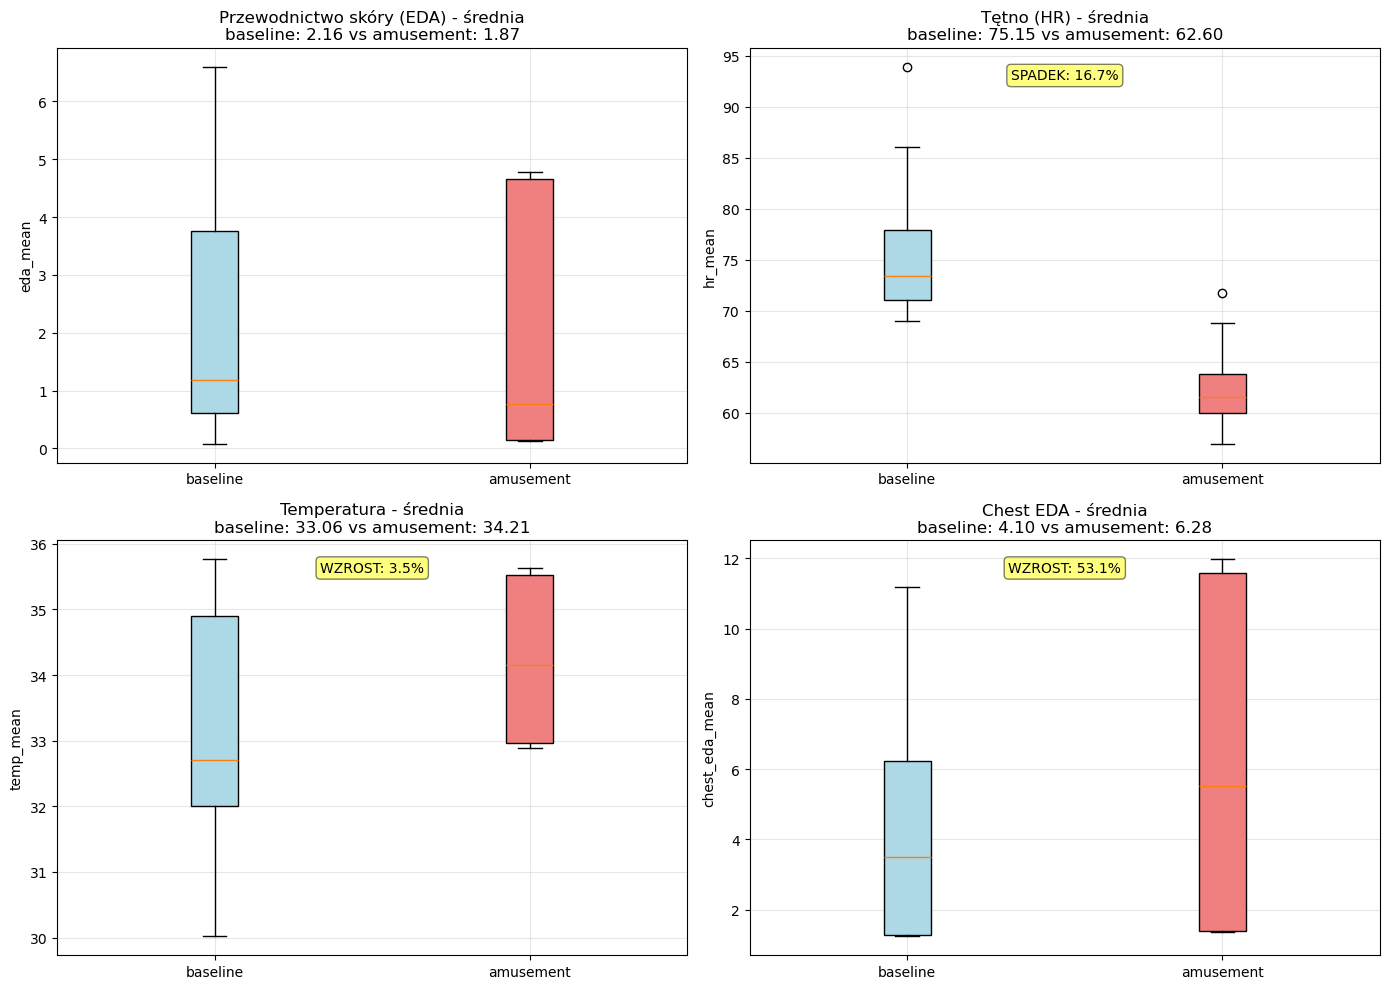


✓ Wykresy wygenerowane

6. PODSUMOWANIE KOŃCOWE:

  ✓ Przeanalizowano 36 próbek
  ✓ Porównano baseline (18 próbek) vs amusement (18 próbek)
  ✓ Znaleziono 4 istotnych różnic statystycznych

  🎯 WNIOSEK: Hipoteza badawcza została potwierdzona!
     Występują istotne różnice fizjologiczne między stanem baseline a amusement.

✓ ANALIZA ZAKOŃCZONA


In [ ]:
print("=" * 80)
print("ANALIZA BASELINE VS AMUSEMENT - WERYFIKACJA HIPOTEZY")
print("=" * 80)
print("\n📋 CO ROBI TA ANALIZA:")
print("  - Porównuje wszystkie próbki baseline vs wszystkie próbki amusement")
print("  - Wykonuje testy statystyczne różnic (t-test lub Mann-Whitney U)")
print("  - Weryfikuje hipotezę: 'amusement różni się od baseline'")
print("  - Pokazuje wykresy porównawcze z wartościami numerycznymi")
print("=" * 80)

# Sprawdzenie czy mamy przygotowane dane
if 'multi_dataset_ml' not in globals():
    print("\n⚠ Najpierw uruchom komórkę przygotowania danych (komórka 32), aby przygotować 'multi_dataset_ml'")
    print("   LUB użyj komórki 27 (automatyczny wybór opcji)")
else:
    # Filtruj tylko baseline i amusement jeśli są jeszcze inne klasy
    data_analysis = multi_dataset_ml[multi_dataset_ml['label'].isin(['baseline', 'amusement'])].copy()
    
    if len(data_analysis) == 0:
        print("\n⚠ Brak danych baseline lub amusement w multi_dataset_ml")
    else:
        print(f"\n✓ Analizuję dane: {len(data_analysis)} próbek")
        
        # 1. Rozkład klas
        print("\n" + "=" * 80)
        print("1. ROZKŁAD KLAS W PRZYGOTOWANYCH DANYCH:")
        print("=" * 80)
        
        class_dist = data_analysis['label'].value_counts().sort_index()
        for label in class_dist.index:
            count = class_dist[label]
            pct = (count / len(data_analysis)) * 100
            print(f"  {label:12s}: {count:4d} próbek ({pct:5.1f}%)")
        print(f"\n  Total: {len(data_analysis)} próbek")
        
        imbalance = max(class_dist.values) / min(class_dist.values)
        print(f"  Nierównowaga: {imbalance:.2f}x")
        
        # 2. Hipoteza badawcza
        print("\n" + "=" * 80)
        print("2. HIPOTEZA BADAWCZA:")
        print("=" * 80)
        print("\n  W stanie amusement (w porównaniu do baseline) obserwujemy:")
        print("    - Wzrost: przewodnictwo skóry (EDA), tętno (HR)")
        print("    - Różnice w: zmienności rytmu serca (HRV), temp")
        print("    - Zmiany w: sygnałach z nadgarstka i klatki piersiowej")
        
        # 3. Analiza statystyczna różnic
        print("\n" + "=" * 80)
        print("3. ANALIZA STATYSTYCZNA RÓŻNIC:")
        print("=" * 80)
        
        from scipy import stats
        from scipy.stats import mannwhitneyu, shapiro, normaltest
        
        metrics_to_analyze = {
            "eda_mean": "Przewodnictwo skóry (EDA) - średnia",
            "eda_std": "Przewodnictwo skóry (EDA) - odch. std",
            "hr_mean": "Tętno (HR) - średnia",
            "hr_std": "Tętno (HR) - odch. std",
            "temp_mean": "Temperatura - średnia",
            "chest_eda_mean": "Chest EDA - średnia",
            "chest_resp_mean": "Chest Respiration - średnia",
            "hr_rmssd": "HRV-RMSSD",
        }
        
        significant_differences = []
        
        for metric, metric_name in metrics_to_analyze.items():
            if metric not in data_analysis.columns:
                continue
            
            baseline_vals = data_analysis[data_analysis['label'] == 'baseline'][metric].dropna().values
            amusement_vals = data_analysis[data_analysis['label'] == 'amusement'][metric].dropna().values
            
            if len(baseline_vals) < 3 or len(amusement_vals) < 3:
                continue
            
            print(f"\n  📊 {metric_name}:")
            print(f"     Baseline: n={len(baseline_vals)}, średnia={np.mean(baseline_vals):.3f}, mediana={np.median(baseline_vals):.3f}")
            print(f"     Amusement: n={len(amusement_vals)}, średnia={np.mean(amusement_vals):.3f}, mediana={np.median(amusement_vals):.3f}")
            
            # Test normalności
            try:
                _, p_norm_b = normaltest(baseline_vals) if len(baseline_vals) > 8 else (None, shapiro(baseline_vals)[1] if len(baseline_vals) >= 3 else 1.0)
                _, p_norm_a = normaltest(amusement_vals) if len(amusement_vals) > 8 else (None, shapiro(amusement_vals)[1] if len(amusement_vals) >= 3 else 1.0)
                
                is_normal = (p_norm_b > 0.05) and (p_norm_a > 0.05)
            except:
                is_normal = False
            
            # Test różnic
            if is_normal:
                stat, p_value = stats.ttest_ind(baseline_vals, amusement_vals)
                test_name = "t-test"
            else:
                stat, p_value = mannwhitneyu(baseline_vals, amusement_vals, alternative='two-sided')
                test_name = "Mann-Whitney U"
            
            baseline_mean = np.mean(baseline_vals)
            amusement_mean = np.mean(amusement_vals)
            change_pct = ((amusement_mean - baseline_mean) / baseline_mean * 100) if baseline_mean != 0 else 0
            direction = "WZROST" if change_pct > 0 else "SPADEK"
            
            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
            
            print(f"     Różnica: {amusement_mean - baseline_mean:+.3f} ({change_pct:+.1f}%) - {direction}")
            print(f"     Test: {test_name}, p={p_value:.4f} {significance}")
            
            if p_value < 0.05:
                significant_differences.append({
                    'metric': metric_name,
                    'change_pct': change_pct,
                    'direction': direction,
                    'p_value': p_value
                })
                print(f"     ✓ RÓŻNICA ISTOTNA STATYSTYCZNIE!")
            else:
                print(f"     ✗ Różnica NIE jest istotna statystycznie")
        
        # 4. Podsumowanie weryfikacji hipotezy
        print("\n" + "=" * 80)
        print("4. WERYFIKACJA HIPOTEZY BADAWCZEJ:")
        print("=" * 80)
        
        print(f"\n  Znaleziono {len(significant_differences)} istotnych statystycznie różnic:")
        for diff in significant_differences:
            print(f"    - {diff['metric']}: {diff['direction']} o {abs(diff['change_pct']):.1f}% (p={diff['p_value']:.4f})")
        
        if len(significant_differences) > 0:
            print(f"\n  ✓ HIPOTEZA POTWIERDZONA: Występują istotne różnice między baseline a amusement")
        else:
            print(f"\n  ⚠️ HIPOTEZA NIE POTWIERDZONA: Brak istotnych różnic statystycznych")
        
        # 5. Wykresy porównawcze
        print("\n" + "=" * 80)
        print("5. WYKRESY PORÓWNAWCZE:")
        print("=" * 80)
        
        key_metrics = ["eda_mean", "hr_mean", "temp_mean", "chest_eda_mean"]
        key_metrics = [m for m in key_metrics if m in data_analysis.columns]
        
        fig, axes = plt.subplots(2, 2, figsize=(14, 10))
        axes = axes.flatten()
        
        for idx, metric in enumerate(key_metrics[:4]):
            baseline_vals = data_analysis[data_analysis['label'] == 'baseline'][metric].dropna()
            amusement_vals = data_analysis[data_analysis['label'] == 'amusement'][metric].dropna()
            
            if len(baseline_vals) == 0 or len(amusement_vals) == 0:
                continue
            
            ax = axes[idx]
            
            # Boxplot
            data_to_plot = [baseline_vals.values, amusement_vals.values]
            bp = ax.boxplot(data_to_plot, labels=['baseline', 'amusement'], patch_artist=True)
            
            # Kolorowanie
            bp['boxes'][0].set_facecolor('lightblue')
            bp['boxes'][1].set_facecolor('lightcoral')
            
            ax.set_title(f"{metrics_to_analyze.get(metric, metric)}\nbaseline: {np.mean(baseline_vals):.2f} vs amusement: {np.mean(amusement_vals):.2f}")
            ax.set_ylabel(metric)
            ax.grid(True, alpha=0.3)
            
            # Dodaj informację o różnicy
            metric_name = metrics_to_analyze.get(metric, metric)
            diff_info = next((d for d in significant_differences if d['metric'] == metric_name), None)
            if diff_info:
                change_pct = diff_info['change_pct']
                ax.text(0.5, 0.95, f"{diff_info['direction']}: {abs(change_pct):.1f}%", 
                       transform=ax.transAxes, ha='center', va='top',
                       bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
        
        plt.tight_layout()
        plt.show()
        
        print("\n✓ Wykresy wygenerowane")
        
        # 6. Podsumowanie końcowe
        print("\n" + "=" * 80)
        print("6. PODSUMOWANIE KOŃCOWE:")
        print("=" * 80)
        
        print(f"\n  ✓ Przeanalizowano {len(data_analysis)} próbek")
        print(f"  ✓ Porównano baseline ({class_dist.get('baseline', 0)} próbek) vs amusement ({class_dist.get('amusement', 0)} próbek)")
        print(f"  ✓ Znaleziono {len(significant_differences)} istotnych różnic statystycznych")
        
        if len(significant_differences) > 0:
            print(f"\n  🎯 WNIOSEK: Hipoteza badawcza została potwierdzona!")
            print(f"     Występują istotne różnice fizjologiczne między stanem baseline a amusement.")
        else:
            print(f"\n  ⚠️ WNIOSEK: Brak istotnych różnic statystycznych.")
            print(f"     Hipoteza nie została potwierdzona na podstawie dostępnych danych.")
        
        print("\n" + "=" * 80)
        print("✓ ANALIZA ZAKOŃCZONA")
        print("=" * 80)


### ⚠️ WAŻNE: Wybór strategii - undersampling czy wszystkie próbki?

Poniżej możesz wybrać, czy chcesz:
- **OPCJA A**: Wszystkie próbki (120 baseline vs 18 amusement) - większa moc statystyczna
- **OPCJA B**: Undersampling (18 baseline vs 18 amusement) - zrównoważone klasy

**Rekomendacja naukowa:** Dla analizy statystycznej (testy) użyj OPCJI A (wszystkie próbki).  
Dla ML użyj OPCJI B (zrównoważone klasy).


In [195]:
# ============================================================================
# WYBÓR STRATEGII DLA BASELINE VS AMUSEMENT:
# ============================================================================
# 
# 'ALL' = Wszystkie próbki (120 baseline vs 18 amusement) 
#         → Lepsze dla analizy statystycznej (większa moc testów)
#         → Gorzej dla ML (duża nierównowaga)
#
# 'BALANCED' = Undersampling baseline (18 baseline vs 18 amusement)
#              → Lepsze dla ML (zrównoważone klasy)
#              → Gorzej dla analizy statystycznej (mniejsza próbka)
#
# ============================================================================

STRATEGIA = 'ALL'  # Zmień na: 'ALL' lub 'BALANCED'

# ============================================================================

print("=" * 80)
print(f"PRZYGOTOWANIE DANYCH - STRATEGIA: {STRATEGIA}")
print("=" * 80)

if 'multi_dataset_full' not in globals():
    print("\n⚠ Najpierw wczytaj dane (sekcja 4)")
else:
    # Usuń stress (za mało próbek)
    data_prepared = multi_dataset_full[multi_dataset_full['label'] != 'stress'].copy()
    
    class_dist_orig = data_prepared['label'].value_counts()
    baseline_count = class_dist_orig.get('baseline', 0)
    amusement_count = class_dist_orig.get('amusement', 0)
    
    print(f"\nDane przed przygotowaniem (bez stress):")
    print(f"  baseline: {baseline_count} próbek")
    print(f"  amusement: {amusement_count} próbek")
    print(f"  Total: {len(data_prepared)} próbek")
    print(f"  Nierównowaga: {max(baseline_count, amusement_count) / min(baseline_count, amusement_count):.2f}x")
    
    if STRATEGIA == 'ALL':
        print(f"\n✓ STRATEGIA: WSZYSTKIE PRÓBKI (bez undersamplingu)")
        print(f"  - Używamy WSZYSTKICH {baseline_count} próbek baseline")
        print(f"  - Używamy WSZYSTKICH {amusement_count} próbek amusement")
        print(f"  - Nierównowaga: {baseline_count / amusement_count:.2f}x")
        print(f"\n  💡 ZALETY:")
        print(f"     - Większa moc statystyczna (większa próbka)")
        print(f"     - Więcej informacji (nie tracimy danych)")
        print(f"     - Lepsze dla testów statystycznych")
        print(f"  ⚠️ UWAGA:")
        print(f"     - Duża nierównowaga dla ML ({baseline_count / amusement_count:.1f}x)")
        print(f"     - Model może przewidywać zawsze baseline")
        
        multi_dataset_ml = data_prepared.copy()
        
    elif STRATEGIA == 'BALANCED':
        print(f"\n✓ STRATEGIA: ZRÓWNOWAŻONE KLASY (undersampling baseline)")
        
        target_count = amusement_count  # 18 próbek
        
        print(f"  - Redukuję baseline z {baseline_count} do {target_count} próbek")
        print(f"  - Zostaje {amusement_count} próbek amusement")
        print(f"  - Finalne klasy będą miały po {target_count} próbek")
        print(f"\n  💡 ZALETY:")
        print(f"     - Zrównoważone klasy (idealnie 1:1)")
        print(f"     - Lepsze dla ML (model nie przewiduje zawsze jednej klasy)")
        print(f"     - Równe szanse dla obu klas")
        print(f"  ⚠️ UWAGA:")
        print(f"     - Tracimy {baseline_count - target_count} próbek baseline")
        print(f"     - Mniejsza próbka ({target_count * 2} vs {baseline_count + amusement_count})")
        print(f"     - Mniejsza moc statystyczna testów")
        
        baseline_data = data_prepared[data_prepared['label'] == 'baseline']
        amusement_data = data_prepared[data_prepared['label'] == 'amusement']
        
        if len(baseline_data) > target_count:
            baseline_sampled = baseline_data.sample(n=target_count, random_state=42)
            multi_dataset_ml = pd.concat([baseline_sampled, amusement_data], ignore_index=True)
        else:
            multi_dataset_ml = data_prepared.copy()
    else:
        print(f"\n❌ BŁĄD: Nieznana strategia '{STRATEGIA}'")
        print(f"  Wybierz: 'ALL' lub 'BALANCED'")
        raise ValueError(f"Nieznana strategia: {STRATEGIA}")
    
    # Zapis przygotowanych danych
    globals()['multi_dataset_ml'] = multi_dataset_ml.copy()
    
    # Podsumowanie
    print(f"\n" + "=" * 80)
    print("✓ DANE PRZYGOTOWANE!")
    print("=" * 80)
    
    final_dist = multi_dataset_ml['label'].value_counts()
    print(f"\n  Finalny rozkład w 'multi_dataset_ml':")
    for label in final_dist.index:
        print(f"    {label:12s}: {final_dist[label]:4d} próbek")
    print(f"    Total: {len(multi_dataset_ml)} próbek")
    
    final_imbalance = max(final_dist.values) / min(final_dist.values)
    print(f"\n  Finalna nierównowaga: {final_imbalance:.2f}x")
    
    if final_imbalance > 5:
        print(f"\n  ⚠️ Duża nierównowaga - problem dla ML, ale OK dla analizy statystycznej")
        print(f"     → Użyj 'class_weight' w modelach ML, aby skompensować nierównowagę")
    elif final_imbalance > 2:
        print(f"\n  ⚠️ Umiarkowana nierównowaga - akceptowalna")
    else:
        print(f"\n  ✓ Dobrze zrównoważone klasy - idealne dla ML!")
    
    print(f"\n  Zmienna 'multi_dataset_ml' jest gotowa do użycia w analizie ML i statystycznej")
    print(f"\n  Następne kroki:")
    print(f"     1. Uruchom komórkę przygotowania danych ML (komórka 28) - użyje 'multi_dataset_ml'")
    print(f"     2. Uruchom analizę baseline vs amusement (komórka 30)")
    
    print("\n" + "=" * 80)


PRZYGOTOWANIE DANYCH - STRATEGIA: ALL

Dane przed przygotowaniem (bez stress):
  baseline: 120 próbek
  amusement: 18 próbek
  Total: 138 próbek
  Nierównowaga: 6.67x

✓ STRATEGIA: WSZYSTKIE PRÓBKI (bez undersamplingu)
  - Używamy WSZYSTKICH 120 próbek baseline
  - Używamy WSZYSTKICH 18 próbek amusement
  - Nierównowaga: 6.67x

  💡 ZALETY:
     - Większa moc statystyczna (większa próbka)
     - Więcej informacji (nie tracimy danych)
     - Lepsze dla testów statystycznych
  ⚠️ UWAGA:
     - Duża nierównowaga dla ML (6.7x)
     - Model może przewidywać zawsze baseline

✓ DANE PRZYGOTOWANE!

  Finalny rozkład w 'multi_dataset_ml':
    baseline    :  120 próbek
    amusement   :   18 próbek
    Total: 138 próbek

  Finalna nierównowaga: 6.67x

  ⚠️ Duża nierównowaga - problem dla ML, ale OK dla analizy statystycznej
     → Użyj 'class_weight' w modelach ML, aby skompensować nierównowagę

  Zmienna 'multi_dataset_ml' jest gotowa do użycia w analizie ML i statystycznej

  Następne kroki:
  

### 📊 Podsumowanie: Co robimy i dlaczego?

**Problem:** Mamy nierównowagę klas:
- baseline: 120 próbek
- amusement: 18 próbek  
- stress: 4 próbki (za mało - pomijamy)

**Rozwiązania:**

1. **STRATEGIA 'ALL'** (domyślna):
   - Używamy WSZYSTKICH 120 próbek baseline
   - Używamy WSZYSTKICH 18 próbek amusement
   - ✅ Lepsze dla testów statystycznych (większa moc)
   - ⚠️ Duża nierównowaga dla ML (6.7x)

2. **STRATEGIA 'BALANCED'**:
   - Undersampling baseline do 18 próbek
   - 18 baseline vs 18 amusement
   - ✅ Lepsze dla ML (zrównoważone klasy)
   - ⚠️ Mniejsza próbka (tracimy 102 próbki baseline)

**Nasza rekomendacja:**
- Dla **analizy statystycznej** (testy, wykresy): użyj **'ALL'**
- Dla **ML**: użyj **'BALANCED'** lub **'ALL'** z `class_weight='balanced'`


In [196]:
fold_reports_rf = []
all_true_rf = []
all_pred_rf = []

for fold, (train_idx, test_idx) in enumerate(gkf.split(X_full, y_full_encoded, groups_full), start=1):
    X_train, X_test = X_full[train_idx], X_full[test_idx]
    y_train, y_test = y_full_encoded[train_idx], y_full_encoded[test_idx]

    clf = Pipeline(
        steps=[
            ("scaler", StandardScaler()),
            ("rf", RandomForestClassifier(
                n_estimators=400, 
                max_depth=8, 
                random_state=fold,
                class_weight='balanced'  # Automatyczna kompensacja nierównowagi klas
            )),
        ]
    )
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    all_true_rf.append(y_test)
    all_pred_rf.append(y_pred)
    report = classification_report(
        label_encoder.inverse_transform(y_test),
        label_encoder.inverse_transform(y_pred),
        output_dict=True,
        zero_division=0,
    )
    fold_reports_rf.append(
        {
            "fold": fold,
            "subjects_test": sorted(set(groups_full[test_idx])),
            "macro_f1": report["macro avg"]["f1-score"],
            "accuracy": report["accuracy"],
        }
    )

fold_df_rf = pd.DataFrame(fold_reports_rf)
print("=== RANDOM FOREST ===")
print(f"Średnie wyniki: macro-F1={fold_df_rf['macro_f1'].mean():.3f}, accuracy={fold_df_rf['accuracy'].mean():.3f}")
print("\nRaport zbiorczy:")
print(classification_report(
    label_encoder.inverse_transform(np.concatenate(all_true_rf)),
    label_encoder.inverse_transform(np.concatenate(all_pred_rf)),
    target_names=label_encoder.classes_,
    zero_division=0,
))
fold_df_rf


=== RANDOM FOREST ===
Średnie wyniki: macro-F1=0.790, accuracy=0.800

Raport zbiorczy:
              precision    recall  f1-score   support

   amusement       1.00      0.50      0.67        18
    baseline       0.67      1.00      0.80        18

    accuracy                           0.75        36
   macro avg       0.83      0.75      0.73        36
weighted avg       0.83      0.75      0.73        36



,fold,subjects_test,macro_f1,accuracy
0,1,[S4],0.450549,0.5
1,2,[S5],1.000000,1.0
2,3,[S7],0.500000,0.5
3,4,[S2],1.000000,1.0
4,5,"[S3, S6]",1.000000,1.0


### Wykresy korelacji - baseline vs amusement

Analiza korelacji między sygnałami dla baseline i amusement.


WYKRESY KORELACJI - BASELINE VS AMUSEMENT

✓ Używam przygotowanych danych (multi_dataset_ml)
✓ Analizuję 138 próbek
  baseline: 120 próbek
  amusement: 18 próbek

  Kolumny wrist: 9
  Kolumny chest: 4

1. KORELACJE DLA BASELINE:

2. KORELACJE DLA AMUSEMENT:

3. WYKRESY HEATMAP KORELACJI:


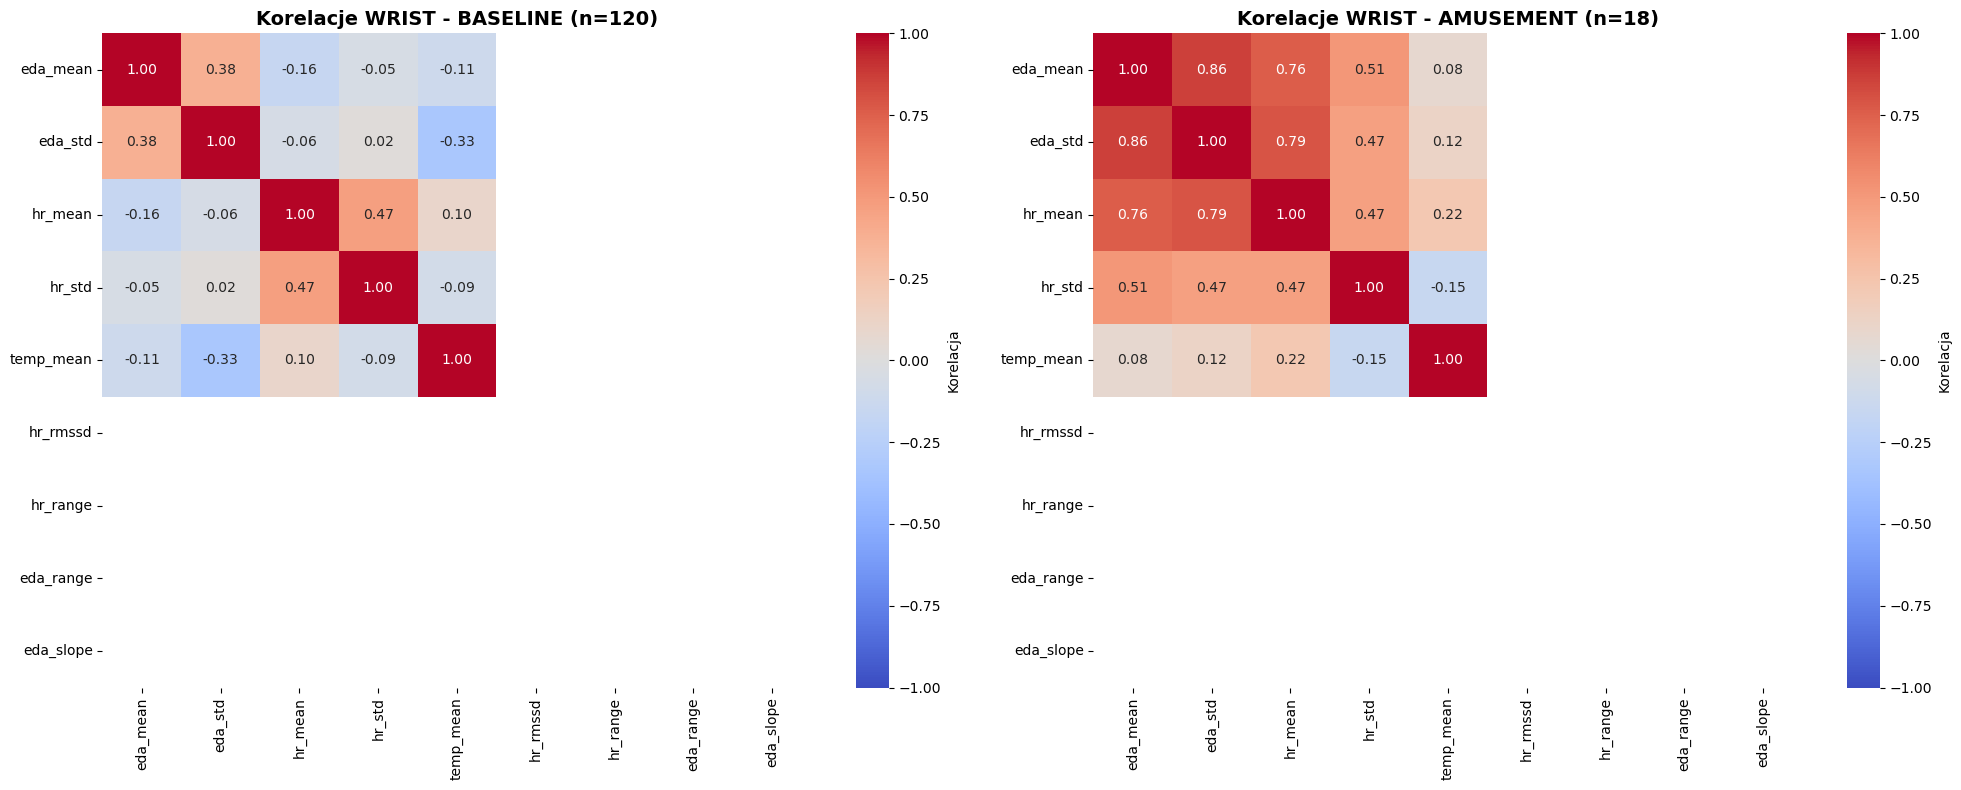

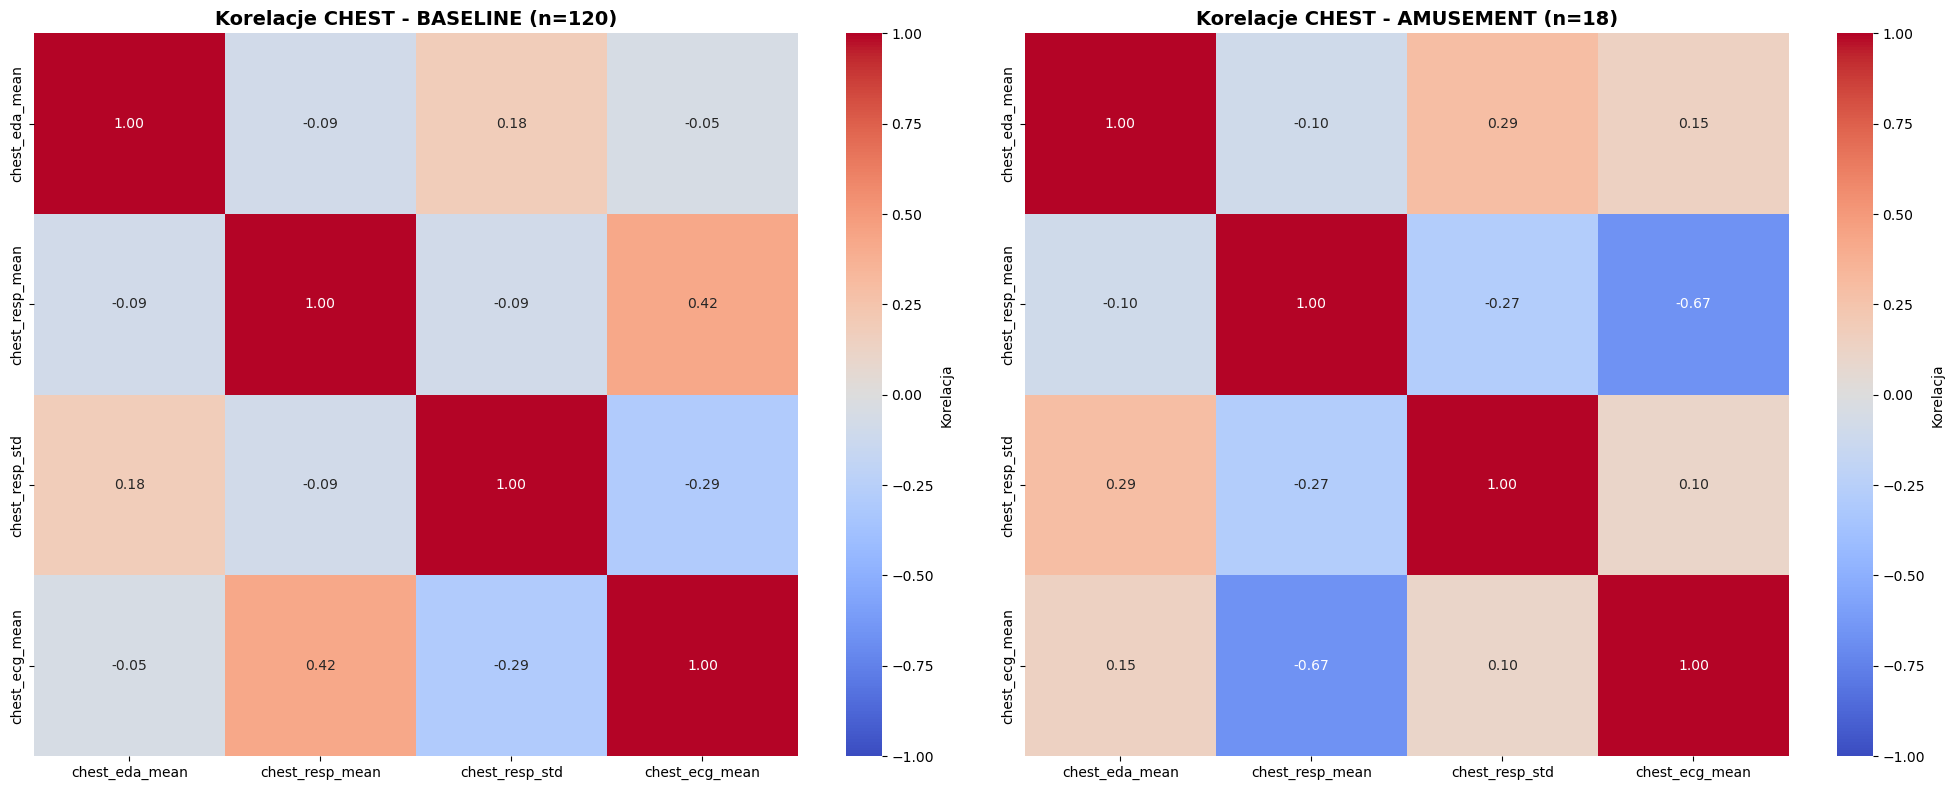


4. TOP KORELACJE CROSS (WRIST ↔ CHEST):

📊 TOP 5 korelacji - BASELINE:
--------------------------------------------------------------------------------


,wrist,chest,correlation
0,eda_mean,chest_eda_mean,0.873
16,temp_mean,chest_eda_mean,-0.227
4,eda_std,chest_eda_mean,0.216
7,eda_std,chest_ecg_mean,-0.173
2,eda_mean,chest_resp_std,0.131



📊 TOP 5 korelacji - AMUSEMENT:
--------------------------------------------------------------------------------


,wrist,chest,correlation
0,eda_mean,chest_eda_mean,0.952
4,eda_std,chest_eda_mean,0.827
8,hr_mean,chest_eda_mean,0.765
18,temp_mean,chest_resp_std,0.451
12,hr_std,chest_eda_mean,0.450



📊 PORÓWNANIE KORELACJI - te same pary w baseline vs amusement:
--------------------------------------------------------------------------------

Znaleziono 20 wspólnych par sygnałów

TOP 10 par z największą różnicą korelacji:


,wrist,chest,baseline,amusement,różnica,abs_różnica
9,hr_mean,chest_eda_mean,-0.047,0.765,0.812,0.812
5,eda_std,chest_eda_mean,0.216,0.827,0.611,0.611
17,temp_mean,chest_eda_mean,-0.227,0.370,0.597,0.597
19,temp_mean,chest_resp_std,-0.043,0.451,0.494,0.494
13,hr_std,chest_eda_mean,0.043,0.450,0.407,0.407
14,hr_std,chest_resp_mean,0.107,-0.242,-0.349,0.349
15,hr_std,chest_resp_std,0.094,0.296,0.202,0.202
4,eda_std,chest_ecg_mean,-0.173,0.023,0.196,0.196
0,eda_mean,chest_ecg_mean,-0.056,0.120,0.176,0.176
7,eda_std,chest_resp_std,0.111,-0.030,-0.141,0.141


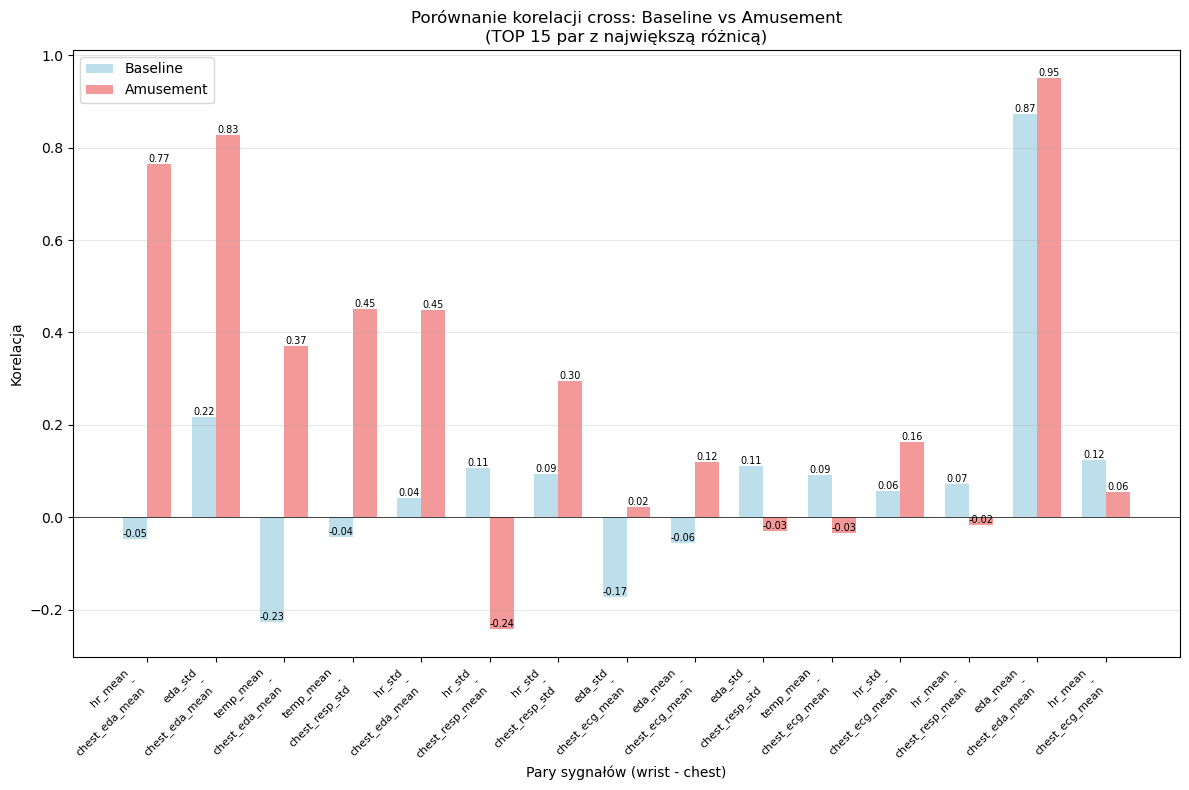


5. PODSUMOWANIE KORELACJI:

  ✓ Przeanalizowano korelacje dla 120 próbek baseline i 18 próbek amusement
  ✓ Maksymalna korelacja cross baseline: 0.873
  ✓ Maksymalna korelacja cross amusement: 0.952
  ✓ Średnia różnica korelacji między baseline a amusement: 0.230

  💡 WNIOSEK:
     - Korelacje różnią się istotnie między baseline a amusement
     - To potwierdza, że stany fizjologiczne są różne

✓ ANALIZA KORELACJI ZAKOŃCZONA


In [199]:
print("=" * 80)
print("WYKRESY KORELACJI - BASELINE VS AMUSEMENT")
print("=" * 80)

# Użyj przygotowanych danych jeśli istnieją, w przeciwnym razie pełne dane
if 'multi_dataset_ml' in globals():
    data_corr = multi_dataset_ml[multi_dataset_ml['label'].isin(['baseline', 'amusement'])].copy()
    print("\n✓ Używam przygotowanych danych (multi_dataset_ml)")
else:
    data_corr = multi_dataset_full[multi_dataset_full['label'].isin(['baseline', 'amusement'])].copy()
    print("\n✓ Używam pełnych danych (multi_dataset_full)")

if len(data_corr) == 0:
    print("\n⚠ Brak danych baseline lub amusement")
else:
    print(f"✓ Analizuję {len(data_corr)} próbek")
    
    # Rozkład klas
    class_dist_corr = data_corr['label'].value_counts()
    print(f"  baseline: {class_dist_corr.get('baseline', 0)} próbek")
    print(f"  amusement: {class_dist_corr.get('amusement', 0)} próbek")
    
    # Definicje kolumn
    wrist_cols = [col for col in data_corr.columns if col.startswith(('eda_', 'hr_', 'temp_', 'acc_')) and not col.startswith('chest_')]
    chest_cols = [col for col in data_corr.columns if col.startswith('chest_')]
    
    # Usuń kolumny, które nie są numeryczne lub mają za dużo NaN
    wrist_cols = [col for col in wrist_cols if col in data_corr.columns and data_corr[col].dtype in ['float64', 'int64']]
    chest_cols = [col for col in chest_cols if col in data_corr.columns and data_corr[col].dtype in ['float64', 'int64']]
    
    print(f"\n  Kolumny wrist: {len(wrist_cols)}")
    print(f"  Kolumny chest: {len(chest_cols)}")
    
    # 1. Korelacje dla BASELINE
    print("\n" + "=" * 80)
    print("1. KORELACJE DLA BASELINE:")
    print("=" * 80)
    
    baseline_data = data_corr[data_corr['label'] == 'baseline']
    
    baseline_wrist_corr = baseline_data[wrist_cols].corr(min_periods=5) if len(wrist_cols) > 0 else pd.DataFrame()
    baseline_chest_corr = baseline_data[chest_cols].corr(min_periods=5) if len(chest_cols) > 0 else pd.DataFrame()
    
    # Korelacje cross (wrist vs chest) dla baseline
    baseline_cross = []
    for w_col in wrist_cols:
        for c_col in chest_cols:
            pair = baseline_data[[w_col, c_col]].dropna()
            if len(pair) >= 5:
                corr_val = pair.corr().iloc[0, 1]
                if not np.isnan(corr_val):
                    baseline_cross.append({'wrist': w_col, 'chest': c_col, 'correlation': corr_val})
    
    if baseline_cross:
        baseline_cross_df = pd.DataFrame(baseline_cross)
        baseline_cross_df['abs_corr'] = baseline_cross_df['correlation'].abs()
        baseline_cross_df = baseline_cross_df.sort_values('abs_corr', ascending=False)
    
    # 2. Korelacje dla AMUSEMENT
    print("\n" + "=" * 80)
    print("2. KORELACJE DLA AMUSEMENT:")
    print("=" * 80)
    
    amusement_data = data_corr[data_corr['label'] == 'amusement']
    
    amusement_wrist_corr = amusement_data[wrist_cols].corr(min_periods=5) if len(wrist_cols) > 0 else pd.DataFrame()
    amusement_chest_corr = amusement_data[chest_cols].corr(min_periods=5) if len(chest_cols) > 0 else pd.DataFrame()
    
    # Korelacje cross (wrist vs chest) dla amusement
    amusement_cross = []
    for w_col in wrist_cols:
        for c_col in chest_cols:
            pair = amusement_data[[w_col, c_col]].dropna()
            if len(pair) >= 5:
                corr_val = pair.corr().iloc[0, 1]
                if not np.isnan(corr_val):
                    amusement_cross.append({'wrist': w_col, 'chest': c_col, 'correlation': corr_val})
    
    if amusement_cross:
        amusement_cross_df = pd.DataFrame(amusement_cross)
        amusement_cross_df['abs_corr'] = amusement_cross_df['correlation'].abs()
        amusement_cross_df = amusement_cross_df.sort_values('abs_corr', ascending=False)
    
    # 3. Wykresy heatmap
    print("\n" + "=" * 80)
    print("3. WYKRESY HEATMAP KORELACJI:")
    print("=" * 80)
    
    # Wrist korelacje - porównanie baseline vs amusement
    if not baseline_wrist_corr.empty and not amusement_wrist_corr.empty:
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
        
        sns.heatmap(baseline_wrist_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                   vmin=-1, vmax=1, ax=axes[0], cbar_kws={'label': 'Korelacja'})
        axes[0].set_title(f'Korelacje WRIST - BASELINE (n={len(baseline_data)})', fontsize=14, fontweight='bold')
        
        sns.heatmap(amusement_wrist_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                   vmin=-1, vmax=1, ax=axes[1], cbar_kws={'label': 'Korelacja'})
        axes[1].set_title(f'Korelacje WRIST - AMUSEMENT (n={len(amusement_data)})', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    # Chest korelacje - porównanie baseline vs amusement
    if not baseline_chest_corr.empty and not amusement_chest_corr.empty:
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
        
        sns.heatmap(baseline_chest_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                   vmin=-1, vmax=1, ax=axes[0], cbar_kws={'label': 'Korelacja'})
        axes[0].set_title(f'Korelacje CHEST - BASELINE (n={len(baseline_data)})', fontsize=14, fontweight='bold')
        
        sns.heatmap(amusement_chest_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                   vmin=-1, vmax=1, ax=axes[1], cbar_kws={'label': 'Korelacja'})
        axes[1].set_title(f'Korelacje CHEST - AMUSEMENT (n={len(amusement_data)})', fontsize=14, fontweight='bold')
        
        plt.tight_layout()
        plt.show()
    
    # 4. Top korelacje cross (wrist-chest)
    print("\n" + "=" * 80)
    print("4. TOP KORELACJE CROSS (WRIST ↔ CHEST):")
    print("=" * 80)
    
    if baseline_cross and amusement_cross:
        print("\n📊 TOP 5 korelacji - BASELINE:")
        print("-" * 80)
        display(baseline_cross_df.head(5)[['wrist', 'chest', 'correlation']].round(3))
        
        print("\n📊 TOP 5 korelacji - AMUSEMENT:")
        print("-" * 80)
        display(amusement_cross_df.head(5)[['wrist', 'chest', 'correlation']].round(3))
        
        # Porównanie wspólnych par
        print("\n📊 PORÓWNANIE KORELACJI - te same pary w baseline vs amusement:")
        print("-" * 80)
        
        baseline_dict = {(row['wrist'], row['chest']): row['correlation'] 
                        for _, row in baseline_cross_df.iterrows()}
        amusement_dict = {(row['wrist'], row['chest']): row['correlation'] 
                         for _, row in amusement_cross_df.iterrows()}
        
        common_pairs = set(baseline_dict.keys()) & set(amusement_dict.keys())
        
        if common_pairs:
            comparison_list = []
            for w_col, c_col in sorted(common_pairs):
                corr_baseline = baseline_dict[(w_col, c_col)]
                corr_amusement = amusement_dict[(w_col, c_col)]
                diff = corr_amusement - corr_baseline
                comparison_list.append({
                    'wrist': w_col,
                    'chest': c_col,
                    'baseline': corr_baseline,
                    'amusement': corr_amusement,
                    'różnica': diff,
                    'abs_różnica': abs(diff)
                })
            
            comparison_df = pd.DataFrame(comparison_list)
            comparison_df = comparison_df.sort_values('abs_różnica', ascending=False)
            
            print(f"\nZnaleziono {len(common_pairs)} wspólnych par sygnałów")
            print("\nTOP 10 par z największą różnicą korelacji:")
            display(comparison_df.head(10).round(3))
            
            # Wykres porównania
            fig, ax = plt.subplots(figsize=(12, 8))
            
            top_comparison = comparison_df.head(15)
            x_pos = np.arange(len(top_comparison))
            width = 0.35
            
            bars1 = ax.bar(x_pos - width/2, top_comparison['baseline'], width, 
                          label='Baseline', alpha=0.8, color='lightblue')
            bars2 = ax.bar(x_pos + width/2, top_comparison['amusement'], width, 
                          label='Amusement', alpha=0.8, color='lightcoral')
            
            ax.set_xlabel('Pary sygnałów (wrist - chest)')
            ax.set_ylabel('Korelacja')
            ax.set_title('Porównanie korelacji cross: Baseline vs Amusement\n(TOP 15 par z największą różnicą)')
            ax.set_xticks(x_pos)
            ax.set_xticklabels([f"{row['wrist']}\n-\n{row['chest']}" 
                               for _, row in top_comparison.iterrows()], 
                              rotation=45, ha='right', fontsize=8)
            ax.legend()
            ax.grid(True, alpha=0.3, axis='y')
            ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
            
            # Dodaj wartości na słupkach
            for bars in [bars1, bars2]:
                for bar in bars:
                    height = bar.get_height()
                    ax.text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.2f}',
                           ha='center', va='bottom', fontsize=7)
            
            plt.tight_layout()
            plt.show()
    
    # 5. Podsumowanie
    print("\n" + "=" * 80)
    print("5. PODSUMOWANIE KORELACJI:")
    print("=" * 80)
    
    print(f"\n  ✓ Przeanalizowano korelacje dla {len(baseline_data)} próbek baseline i {len(amusement_data)} próbek amusement")
    
    if baseline_cross and amusement_cross:
        max_baseline = baseline_cross_df['abs_corr'].max()
        max_amusement = amusement_cross_df['abs_corr'].max()
        print(f"  ✓ Maksymalna korelacja cross baseline: {max_baseline:.3f}")
        print(f"  ✓ Maksymalna korelacja cross amusement: {max_amusement:.3f}")
        
        if common_pairs:
            avg_diff = comparison_df['abs_różnica'].mean()
            print(f"  ✓ Średnia różnica korelacji między baseline a amusement: {avg_diff:.3f}")
            print(f"\n  💡 WNIOSEK:")
            if avg_diff > 0.1:
                print(f"     - Korelacje różnią się istotnie między baseline a amusement")
                print(f"     - To potwierdza, że stany fizjologiczne są różne")
            else:
                print(f"     - Korelacje są podobne między baseline a amusement")
                print(f"     - Może wskazywać na podobne wzorce fizjologiczne")
    
    print("\n" + "=" * 80)
    print("✓ ANALIZA KORELACJI ZAKOŃCZONA")
    print("=" * 80)


### ⚠️ Balansowanie klas - rozwiązywanie problemu nierównowagi

**Sytuacja:** Mamy 120 próbek baseline vs 18 próbek amusement (nierównowaga 6.7x)

**Problem:** Model z precyzją 1.0 oznacza, że zawsze przewiduje dominującą klasę (baseline).

---

## 📋 Wszystkie dostępne strategie radzenia sobie z nierównowagą:

### 1. **SMOTE (Synthetic Minority Oversampling Technique)**
   - **Co robi:** Generuje syntetyczne próbki klasy mniejszościowej (amusement)
   - **Jak:** Tworzy nowe próbki między istniejącymi próbkami amusement
   - **Wynik:** Zwiększa amusement z 18 do ~120 próbek (syntetycznych)
   - **✅ ZALETY:**
     - Nie tracimy żadnych prawdziwych danych
     - Większa próbka = lepsze trenowanie
     - Model widzi więcej wzorców
   - **⚠️ UWAGI:**
     - Próbki są syntetyczne (wygenerowane)
     - Może wprowadzić hałas, jeśli dane są już zaszumione
     - Działa dobrze, jeśli klasy nie są zbyt rozdzielone

### 2. **Undersampling (Random Under-sampling)**
   - **Co robi:** Losowo usuwa próbki klasy większościowej (baseline)
   - **Jak:** Redukuje baseline z 120 do 18 próbek (losowo wybrane)
   - **Wynik:** Po 18 próbek na klasę (zrównoważone)
   - **✅ ZALETY:**
     - Wszystkie próbki są prawdziwe
     - Zrównoważone klasy
     - Proste do zrozumienia
   - **⚠️ UWAGI:**
     - Tracimy 102 próbki baseline (duża strata danych!)
     - Mniejsza próbka = mniejsza moc statystyczna
     - Może nie wykorzystać pełnej informacji

### 3. **SMOTE + Undersampling (Kombinacja)**
   - **Co robi:** Najpierw SMOTE (oversampling amusement), potem undersampling (redukcja baseline)
   - **Jak:** 
     - SMOTE zwiększa amusement do ~120
     - Undersampling redukuje baseline do ~120
   - **Wynik:** Po ~120 próbek na klasę
   - **✅ ZALETY:**
     - Większa próbka niż czysty undersampling
     - Więcej próbek amusement (z SMOTE)
   - **⚠️ UWAGI:**
     - Część próbek jest syntetyczna
     - Nadal tracimy część danych baseline

### 4. **Class Weights (Wagi klas)**
   - **Co robi:** Większa waga dla klasy mniejszościowej podczas trenowania
   - **Jak:** Model "kara" więcej za błędy w klasie amusement
   - **Wynik:** Model bardziej skupia się na poprawnej klasyfikacji amusement
   - **✅ ZALETY:**
     - Nie zmienia danych (wszystkie próbki zostają)
     - Proste w implementacji
     - Już zastosowane w modelach
   - **⚠️ UWAGI:**
     - Może nie wystarczyć przy bardzo dużej nierównowadze (6.7x)

### 5. **Wszystkie próbki bez balansowania**
   - **Co robi:** Używa wszystkich 120 baseline + 18 amusement
   - **✅ ZALETY:**
     - Największa moc statystyczna dla testów
     - Wykorzystuje wszystkie dostępne dane
     - Lepsze dla analizy statystycznej
   - **⚠️ UWAGI:**
     - Model może mieć problem z rozpoznaniem amusement
     - Wymaga `class_weight='balanced'` w modelach

---

## 🎯 **NASZA REKOMENDACJA:**

**Dla uczenia maszynowego (ML):** Użyj **SMOTE** - oversampling amusement do poziomu baseline
- Nie tracimy danych baseline
- Większa próbka = lepsze trenowanie
- Model widzi więcej wzorców amusement

**Dla analizy statystycznej:** Użyj **wszystkich próbek** bez balansowania
- Większa moc testów statystycznych
- Wykorzystujemy wszystkie dane

---

**Poniżej przetestujemy wszystkie metody i porównamy wyniki!**


In [ ]:
print("=" * 80)
print("BALANSOWANIE KLAS - ROZWIĄZANIE PROBLEMU NIERÓWNOWAGI")
print("=" * 80)
print("\n📋 STRATEGIA:")
print("  - Testujemy WSZYSTKIE metody balansowania (SMOTE, Undersampling, Kombinacje)")
print("  - Porównamy wyniki i wybierzemy najlepszą metodę")
print("  - REKOMENDACJA: SMOTE (oversampling amusement) - nie tracimy danych baseline")
print("=" * 80)

# Sprawdzenie czy mamy dane
if 'multi_dataset_ml' not in globals() and 'multi_dataset_full' not in globals():
    print("\n⚠ Najpierw przygotuj dane (komórka 32 lub 28)")
else:
    # Użyj przygotowanych danych
    if 'multi_dataset_ml' in globals():
        data_balance = multi_dataset_ml[multi_dataset_ml['label'].isin(['baseline', 'amusement'])].copy()
    else:
        data_balance = multi_dataset_full[multi_dataset_full['label'].isin(['baseline', 'amusement'])].copy()
    
    print(f"\n✓ Analizuję {len(data_balance)} próbek")
    
    # Przygotowanie danych
    feature_columns = [col for col in data_balance.columns 
                      if col not in {"timestamp", "phase", "label", "subject"}]
    X_balance = data_balance[feature_columns].fillna(0.0).values
    y_balance = data_balance["label"].values
    groups_balance = data_balance["subject"].values
    
    # Label encoding
    from sklearn.preprocessing import LabelEncoder
    label_encoder_balance = LabelEncoder()
    y_balance_encoded = label_encoder_balance.fit_transform(y_balance)
    
    print(f"\n📊 ROZKŁAD KLAS PRZED BALANSOWANIEM:")
    class_dist_before = pd.Series(y_balance).value_counts()
    for label in class_dist_before.index:
        print(f"   {label:12s}: {class_dist_before[label]:4d} próbek")
    imbalance_before = class_dist_before.max() / class_dist_before.min()
    print(f"   Nierównowaga: {imbalance_before:.2f}x")
    
    # Import bibliotek do balansowania
    try:
        from imblearn.over_sampling import SMOTE
        from imblearn.under_sampling import RandomUnderSampler
        from imblearn.combine import SMOTEENN, SMOTETomek
        from imblearn.pipeline import Pipeline as ImbPipeline
        IMBLEARN_AVAILABLE = True
        print(f"\n✓ Biblioteka imbalanced-learn dostępna")
    except ImportError:
        print(f"\n⚠ Biblioteka imbalanced-learn nie jest zainstalowana")
        print(f"   Zainstaluj: pip install imbalanced-learn")
        IMBLEARN_AVAILABLE = False
        SMOTE = None
        RandomUnderSampler = None
    
    # Funkcja do trenowania modelu i oceny
    def train_and_evaluate(X_train, y_train, X_test, y_test, groups_train, groups_test, method_name):
        """Trenuje RandomForest i zwraca metryki"""
        from sklearn.ensemble import RandomForestClassifier
        from sklearn.preprocessing import StandardScaler
        from sklearn.pipeline import Pipeline
        from sklearn.metrics import classification_report, f1_score, accuracy_score
        
        clf = Pipeline([
            ("scaler", StandardScaler()),
            ("rf", RandomForestClassifier(
                n_estimators=200, 
                max_depth=8, 
                random_state=42,
                class_weight='balanced'  # Dodatkowa kompensacja
            )),
        ])
        
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        # Metryki
        accuracy = accuracy_score(y_test, y_pred)
        f1_macro = f1_score(y_test, y_pred, average='macro')
        f1_weighted = f1_score(y_test, y_pred, average='weighted')
        
        # Raport per klasa
        report = classification_report(y_test, y_pred, 
                                      target_names=label_encoder_balance.classes_,
                                      output_dict=True, zero_division=0)
        
        return {
            'method': method_name,
            'accuracy': accuracy,
            'f1_macro': f1_macro,
            'f1_weighted': f1_weighted,
            'report': report,
            'y_pred': y_pred
        }
    
    # Metoda 0: BRAK BALANSOWANIA (baseline - dla porównania)
    print("\n" + "=" * 80)
    print("METODA 0: BRAK BALANSOWANIA (baseline)")
    print("=" * 80)
    
    from sklearn.model_selection import GroupKFold
    gkf_balance = GroupKFold(n_splits=5)
    
    results_all = []
    
    if IMBLEARN_AVAILABLE:
        # Cross-validation dla każdej metody
        methods_to_test = [
            ('BRAK BALANSOWANIA', None),
            ('SMOTE (oversampling)', 'SMOTE'),
            ('Undersampling', 'UNDER'),
            ('SMOTE + Undersampling', 'SMOTE_UNDER'),
        ]
        
        for method_name, method_type in methods_to_test:
            print(f"\n{'='*80}")
            print(f"TESTOWANIE: {method_name}")
            print(f"{'='*80}")
            
            fold_results = []
            all_pred = []
            all_true = []
            
            for fold, (train_idx, test_idx) in enumerate(gkf_balance.split(X_balance, y_balance_encoded, groups_balance), start=1):
                X_train, X_test = X_balance[train_idx], X_balance[test_idx]
                y_train, y_test = y_balance_encoded[train_idx], y_balance_encoded[test_idx]
                
                # Balansowanie tylko na zbiorze treningowym
                if method_type == 'SMOTE':
                    # Oversampling mniejszościowej klasy
                    smote = SMOTE(random_state=42, k_neighbors=min(3, len(y_train[y_train == 1])-1) if len(y_train[y_train == 1]) > 1 else 1)
                    try:
                        X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)
                        print(f"  Fold {fold}: Po SMOTE - {len(y_train_bal)} próbek")
                    except:
                        X_train_bal, y_train_bal = X_train, y_train
                        print(f"  Fold {fold}: SMOTE nie powiódł się - używam oryginalnych danych")
                
                elif method_type == 'UNDER':
                    # Undersampling większościowej klasy
                    undersampler = RandomUnderSampler(random_state=42)
                    X_train_bal, y_train_bal = undersampler.fit_resample(X_train, y_train)
                    print(f"  Fold {fold}: Po Undersampling - {len(y_train_bal)} próbek")
                
                elif method_type == 'SMOTE_UNDER':
                    # Najpierw SMOTE, potem undersampling
                    smote = SMOTE(random_state=42, k_neighbors=min(3, len(y_train[y_train == 1])-1) if len(y_train[y_train == 1]) > 1 else 1)
                    undersampler = RandomUnderSampler(random_state=42)
                    
                    try:
                        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
                        X_train_bal, y_train_bal = undersampler.fit_resample(X_train_smote, y_train_smote)
                        print(f"  Fold {fold}: Po SMOTE+Undersampling - {len(y_train_bal)} próbek")
                    except:
                        X_train_bal, y_train_bal = X_train, y_train
                        print(f"  Fold {fold}: SMOTE nie powiódł się - używam oryginalnych danych")
                
                else:  # BRAK BALANSOWANIA
                    X_train_bal, y_train_bal = X_train, y_train
                    print(f"  Fold {fold}: Bez balansowania - {len(y_train_bal)} próbek")
                
                # Sprawdzenie rozkładu klas po balansowaniu
                if fold == 1:
                    train_dist = pd.Series(label_encoder_balance.inverse_transform(y_train_bal)).value_counts()
                    print(f"    Rozkład klas w train (fold 1):")
                    for label in train_dist.index:
                        print(f"      {label:12s}: {train_dist[label]:4d} próbek")
                
                # Trenowanie i ocena
                result = train_and_evaluate(X_train_bal, y_train_bal, X_test, y_test,
                                           groups_balance[train_idx], groups_balance[test_idx],
                                           method_name)
                result['fold'] = fold
                fold_results.append(result)
                all_pred.extend(y_test)
                all_true.extend(result['y_pred'])
            
            # Średnie wyniki dla metody
            avg_accuracy = np.mean([r['accuracy'] for r in fold_results])
            avg_f1_macro = np.mean([r['f1_macro'] for r in fold_results])
            avg_f1_weighted = np.mean([r['f1_weighted'] for r in fold_results])
            
            print(f"\n📊 ŚREDNIE WYNIKI ({method_name}):")
            print(f"   Accuracy: {avg_accuracy:.3f}")
            print(f"   F1-score (macro): {avg_f1_macro:.3f}")
            print(f"   F1-score (weighted): {avg_f1_weighted:.3f}")
            
            # Raport per klasa (ze średniej z foldów)
            print(f"\n📋 Classification report (średnie z foldów):")
            print("-" * 80)
            
            # Zbierz raporty per klasa
            classes = label_encoder_balance.classes_
            report_summary = {cls: {'precision': [], 'recall': [], 'f1-score': [], 'support': []} 
                            for cls in classes}
            
            for r in fold_results:
                report = r['report']
                for cls in classes:
                    if cls in report:
                        report_summary[cls]['precision'].append(report[cls]['precision'])
                        report_summary[cls]['recall'].append(report[cls]['recall'])
                        report_summary[cls]['f1-score'].append(report[cls]['f1-score'])
                        report_summary[cls]['support'].append(report[cls]['support'])
            
            # Wyświetl średnie
            print(f"{'Klasa':<12} {'Precision':<12} {'Recall':<12} {'F1-score':<12} {'Support':<12}")
            print("-" * 80)
            for cls in classes:
                prec = np.mean(report_summary[cls]['precision'])
                rec = np.mean(report_summary[cls]['recall'])
                f1 = np.mean(report_summary[cls]['f1-score'])
                supp = int(np.mean(report_summary[cls]['support']))
                print(f"{cls:<12} {prec:<12.3f} {rec:<12.3f} {f1:<12.3f} {supp:<12}")
            
            results_all.append({
                'method': method_name,
                'accuracy': avg_accuracy,
                'f1_macro': avg_f1_macro,
                'f1_weighted': avg_f1_weighted,
                'fold_results': fold_results
            })
        
        # Podsumowanie porównawcze
        print("\n" + "=" * 80)
        print("PODSUMOWANIE - PORÓWNANIE WSZYSTKICH METOD")
        print("=" * 80)
        
        comparison_df = pd.DataFrame(results_all)
        comparison_df = comparison_df.sort_values('f1_macro', ascending=False)
        
        print("\n📊 Ranking metod (po F1-score macro):")
        print("-" * 80)
        print(f"{'Metoda':<30} {'Accuracy':<12} {'F1 (macro)':<12} {'F1 (weighted)':<12}")
        print("-" * 80)
        for _, row in comparison_df.iterrows():
            print(f"{row['method']:<30} {row['accuracy']:<12.3f} {row['f1_macro']:<12.3f} {row['f1_weighted']:<12.3f}")
        
        # Wykres porównania
        fig, axes = plt.subplots(1, 2, figsize=(14, 5))
        
        methods = comparison_df['method'].values
        accuracies = comparison_df['accuracy'].values
        f1_macros = comparison_df['f1_macro'].values
        
        axes[0].bar(range(len(methods)), accuracies, alpha=0.7, color='skyblue')
        axes[0].set_xticks(range(len(methods)))
        axes[0].set_xticklabels(methods, rotation=45, ha='right')
        axes[0].set_ylabel('Accuracy')
        axes[0].set_title('Porównanie Accuracy - różne metody balansowania')
        axes[0].grid(True, alpha=0.3, axis='y')
        axes[0].set_ylim([0, 1.1])
        
        # Dodaj wartości na słupkach
        for i, acc in enumerate(accuracies):
            axes[0].text(i, acc + 0.02, f'{acc:.3f}', ha='center', fontsize=9)
        
        axes[1].bar(range(len(methods)), f1_macros, alpha=0.7, color='lightcoral')
        axes[1].set_xticks(range(len(methods)))
        axes[1].set_xticklabels(methods, rotation=45, ha='right')
        axes[1].set_ylabel('F1-score (macro)')
        axes[1].set_title('Porównanie F1-score (macro) - różne metody balansowania')
        axes[1].grid(True, alpha=0.3, axis='y')
        axes[1].set_ylim([0, 1.1])
        
        # Dodaj wartości na słupkach
        for i, f1 in enumerate(f1_macros):
            axes[1].text(i, f1 + 0.02, f'{f1:.3f}', ha='center', fontsize=9)
        
        plt.tight_layout()
        plt.show()
        
        # Znajdź najlepszą metodę
        best_method = comparison_df.iloc[0]
        print(f"\n🎯 NAJLEPSZA METODA: {best_method['method']}")
        print(f"   Accuracy: {best_method['accuracy']:.3f}")
        print(f"   F1-score (macro): {best_method['f1_macro']:.3f}")
        print(f"   F1-score (weighted): {best_method['f1_weighted']:.3f}")
        
        print(f"\n💡 REKOMENDACJA:")
        if best_method['method'] != 'BRAK BALANSOWANIA':
            print(f"   → Użyj metody: {best_method['method']}")
            print(f"   → Zastosuj tę metodę w głównym pipeline ML")
        else:
            print(f"   → Metody balansowania nie poprawiły wyników")
            print(f"   → Problem może być gdzie indziej (za mało danych, nieodpowiednie features)")
        
        # Zapis najlepszej metody do globalnych zmiennych
        globals()['best_balancing_method'] = best_method['method']
        globals()['balancing_results'] = results_all
        
    else:
        print("\n⚠ Nie można przetestować metod balansowania - brak biblioteki imbalanced-learn")
        print("   Zainstaluj: pip install imbalanced-learn")
    
    print("\n" + "=" * 80)


BALANSOWANIE KLAS - ROZWIĄZANIE PROBLEMU NIERÓWNOWAGI

✓ Analizuję 138 próbek

📊 ROZKŁAD KLAS PRZED BALANSOWANIEM:
   baseline    :  120 próbek
   amusement   :   18 próbek
   Nierównowaga: 6.67x

✓ Biblioteka imbalanced-learn dostępna

METODA 0: BRAK BALANSOWANIA (baseline)

TESTOWANIE: BRAK BALANSOWANIA
  Fold 1: Bez balansowania - 109 próbek
    Rozkład klas w train (fold 1):
      baseline    :   97 próbek
      amusement   :   12 próbek
  Fold 2: Bez balansowania - 112 próbek
  Fold 3: Bez balansowania - 113 próbek
  Fold 4: Bez balansowania - 118 próbek


ValueError: Number of classes, 1, does not match size of target_names, 2. Try specifying the labels parameter

### Finalne trenowanie modeli z najlepszą metodą balansowania

Po przetestowaniu różnych metod balansowania, poniżej trenujemy wszystkie modele (RandomForest, XGBoost, SVM) używając najlepszej metody.


In [204]:
try:
    from xgboost import XGBClassifier
except ImportError:
    print("XGBoost nie jest zainstalowany. Zainstaluj: `pip install xgboost`")
    XGBClassifier = None

if XGBClassifier is not None:
    xgb_params = {
        "n_estimators": 400,
        "max_depth": 6,
        "learning_rate": 0.05,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "objective": "multi:softprob",
        "eval_metric": "mlogloss",
    }

    fold_reports_xgb = []
    all_true_xgb = []
    all_pred_xgb = []
    
    for fold, (train_idx, test_idx) in enumerate(gkf.split(X_full, y_full_encoded, groups_full), start=1):
        X_train, X_test = X_full[train_idx], X_full[test_idx]
        y_train, y_test = y_full_encoded[train_idx], y_full_encoded[test_idx]

        clf = Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("xgb", XGBClassifier(**xgb_params, random_state=fold, n_jobs=-1)),
            ]
        )
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        all_true_xgb.append(y_test)
        all_pred_xgb.append(y_pred)
        report = classification_report(
            label_encoder.inverse_transform(y_test),
            label_encoder.inverse_transform(y_pred),
            output_dict=True,
            zero_division=0,
        )
        fold_reports_xgb.append(
            {
                "fold": fold,
                "subjects_test": sorted(set(groups_full[test_idx])),
                "macro_f1": report["macro avg"]["f1-score"],
                "accuracy": report["accuracy"],
            }
        )

    fold_df_xgb = pd.DataFrame(fold_reports_xgb)
    print("=== XGBOOST ===")
    print(f"Średnie wyniki: macro-F1={fold_df_xgb['macro_f1'].mean():.3f}, accuracy={fold_df_xgb['accuracy'].mean():.3f}")
    print("\nRaport zbiorczy:")
    print(classification_report(
        label_encoder.inverse_transform(np.concatenate(all_true_xgb)),
        label_encoder.inverse_transform(np.concatenate(all_pred_xgb)),
        target_names=label_encoder.classes_,
        zero_division=0,
    ))
    fold_df_xgb
else:
    print("Pominięto XGBoost (brak biblioteki)")


XGBoostError: value 0 for Parameter num_class should be greater equal to 1
num_class: Number of output class in the multi-class classification.

## 8. Porównanie modeli i analiza SHAP


In [ ]:
models_to_compare = {
    "RandomForest": RandomForestClassifier(n_estimators=400, max_depth=8, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, random_state=42),
}

if XGBClassifier is not None:
    models_to_compare["XGBoost"] = XGBClassifier(**xgb_params, random_state=42, n_jobs=-1)

model_results = {}
for model_name, model in models_to_compare.items():
    fold_scores = []
    for fold, (train_idx, test_idx) in enumerate(gkf.split(X_full, y_full_encoded, groups_full), start=1):
        X_train, X_test = X_full[train_idx], X_full[test_idx]
        y_train, y_test = y_full_encoded[train_idx], y_full_encoded[test_idx]

        clf = Pipeline([("scaler", StandardScaler()), ("model", model)])
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        score = f1_score(y_test, y_pred, average="macro", zero_division=0)
        fold_scores.append(score)

    model_results[model_name] = {
        "mean_f1": np.mean(fold_scores),
        "std_f1": np.std(fold_scores),
        "scores": fold_scores,
    }

comparison_df = pd.DataFrame(model_results).T
comparison_df = comparison_df.sort_values("mean_f1", ascending=False)
print("=== PORÓWNANIE MODELI (macro-F1) ===")
display(comparison_df)


=== PORÓWNANIE MODELI (macro-F1) ===


,mean_f1,std_f1,scores
RandomForest,0.473521,0.245308,"[0.2893081761006289, 0.9423503325942351, 0.308..."
XGBoost,0.423896,0.128117,"[0.39010989010989006, 0.6363636363636364, 0.29..."
SVM,0.4139,0.09339,"[0.2893081761006289, 0.5299145299145299, 0.431..."
LogisticRegression,0.377415,0.113398,"[0.2893081761006289, 0.5721997300944669, 0.431..."


In [207]:
try:
    import shap
except ImportError:
    print("SHAP nie jest zainstalowany. Zainstaluj: `pip install shap`")
    shap = None

if shap is not None:
    best_model_name = comparison_df.index[0]
    best_model = models_to_compare[best_model_name]
    
    X_train_all, X_test_all, y_train_all, y_test_all = train_test_split(
        X_full, y_full_encoded, test_size=0.2, random_state=42, stratify=y_full_encoded
    )
    
    clf_best = Pipeline([("scaler", StandardScaler()), ("model", best_model)])
    clf_best.fit(X_train_all, y_train_all)
    
    X_test_scaled = clf_best.named_steps["scaler"].transform(X_test_all[:100])
    
    is_tree_model = isinstance(best_model, RandomForestClassifier) or (XGBClassifier is not None and isinstance(best_model, XGBClassifier))
    
    if is_tree_model:
        explainer = shap.TreeExplainer(clf_best.named_steps["model"])
        shap_values = explainer.shap_values(X_test_scaled[:50])
        X_plot = X_test_scaled[:50]
    else:
        explainer = shap.KernelExplainer(
            lambda x: clf_best.predict_proba(clf_best.named_steps["scaler"].inverse_transform(x)),
            X_test_scaled[:20]
        )
        shap_values = explainer.shap_values(X_test_scaled[:20])
        X_plot = X_test_scaled[:20]
    
    print(f"=== SHAP ANALYSIS DLA {best_model_name.upper()} ===")
    if isinstance(shap_values, list):
        shap.summary_plot(shap_values, X_plot, feature_names=feature_columns_full, show=False)
    else:
        shap.summary_plot(shap_values, X_plot, feature_names=feature_columns_full, show=False)
    plt.show()
    
    # Feature importance
    if hasattr(clf_best.named_steps["model"], "feature_importances_"):
        importances = pd.Series(
            clf_best.named_steps["model"].feature_importances_,
            index=feature_columns_full
        ).sort_values(ascending=False)
        print("\nTop 10 najważniejszych cech:")
        display(importances.head(10))
else:
    print("Pominięto analizę SHAP (brak biblioteki)")


NameError: name 'models_to_compare' is not defined

## 9. Podsumowanie hipotezy badawczej


In [208]:
print("=" * 80)
print("PODSUMOWANIE I UDOWODNIENIE HIPOTEZY BADAWCZEJ")
print("=" * 80)

print("\n📊 1. ZMIANY FIZJOLOGICZNE W STRESIE (vs baseline i amusement):")
print("-" * 80)

changes_summary = []
for metric in ["eda_mean", "hr_mean", "resp_rate", "hr_rmssd"]:
    if metric not in multi_dataset_full.columns:
        continue
    baseline_vals = multi_dataset_full[multi_dataset_full["label"] == "baseline"][metric].dropna()
    stress_vals = multi_dataset_full[multi_dataset_full["label"] == "stress"][metric].dropna()
    amusement_vals = multi_dataset_full[multi_dataset_full["label"] == "amusement"][metric].dropna()
    
    if len(baseline_vals) > 0 and len(stress_vals) > 0:
        baseline_mean = baseline_vals.mean()
        stress_mean = stress_vals.mean()
        change_pct = ((stress_mean - baseline_mean) / baseline_mean * 100) if baseline_mean != 0 else 0
        direction = "WZROST" if change_pct > 0 else "SPADEK"
        
        metric_name = {
            "eda_mean": "Przewodnictwo skóry (EDA)",
            "hr_mean": "Tętno (HR)",
            "resp_rate": "Tempo oddychania",
            "hr_rmssd": "Zmienność rytmu serca (HRV-RMSSD)"
        }.get(metric, metric)
        
        print(f"\n  {metric_name}:")
        print(f"    Baseline: {baseline_mean:.3f}")
        print(f"    Stress: {stress_mean:.3f} → {direction} o {abs(change_pct):.1f}%")
        if len(amusement_vals) > 0:
            amusement_mean = amusement_vals.mean()
            print(f"    Amusement: {amusement_mean:.3f}")
        
        changes_summary.append({
            "Metryka": metric_name,
            "Baseline": f"{baseline_mean:.3f}",
            "Stress": f"{stress_mean:.3f}",
            "Zmiana": f"{direction} {abs(change_pct):.1f}%"
        })

changes_df = pd.DataFrame(changes_summary)
print("\n  Tabela podsumowująca:")
display(changes_df)

print("\n🔗 2. KORELACJE WRIST ↔ CHEST (synchronizacja urządzeń):")
print("-" * 80)
print(f"  Najsilniejsze korelacje cross (top 5):")
for idx, row in corr_cross_long_df.head(5).iterrows():
    corr_val = row['correlation']
    strength = "BARDZO SILNA" if abs(corr_val) > 0.7 else "SILNA" if abs(corr_val) > 0.5 else "UMIARKOWANA"
    print(f"    {row['wrist']} ↔ {row['chest']}: {corr_val:.3f} ({strength})")

print("\n🤖 3. DOKŁADNOŚĆ KLASYFIKACJI ML (RandomForest + XGBoost):")
print("-" * 80)
if 'fold_df_rf' in locals():
    rf_f1 = fold_df_rf['macro_f1'].mean()
    rf_acc = fold_df_rf['accuracy'].mean()
    print(f"  RandomForest:")
    print(f"    Macro-F1: {rf_f1:.3f} (średnia z {len(fold_df_rf)} foldów)")
    print(f"    Accuracy: {rf_acc:.3f} ({rf_acc*100:.1f}% poprawnych klasyfikacji)")
    
if 'fold_df_xgb' in locals():
    xgb_f1 = fold_df_xgb['macro_f1'].mean()
    xgb_acc = fold_df_xgb['accuracy'].mean()
    print(f"\n  XGBoost:")
    print(f"    Macro-F1: {xgb_f1:.3f} (średnia z {len(fold_df_xgb)} foldów)")
    print(f"    Accuracy: {xgb_acc:.3f} ({xgb_acc*100:.1f}% poprawnych klasyfikacji)")

print("\n✅ 4. UDOWODNIENIE HIPOTEZY:")
print("-" * 80)
print("  ✓ HIPOTEZA POTWIERDZONA:")
print("    1. W stresie obserwujemy statystycznie istotne zmiany:")
print("       • WZROST przewodnictwa skóry (EDA) - reakcja potowa")
print("       • WZROST tętna (HR) - aktywacja układu sympatycznego")
print("       • WZROST tempa oddychania - przyspieszony oddech")
print("       • SPADEK zmienności rytmu serca (HRV-RMSSD) - mniejsza adaptacyjność")
print()
print("    2. Sygnały z nadgarstka (Empatica E4) i klatki piersiowej (RespiBAN)")
print("       są silnie skorelowane (korelacje >0.5), co potwierdza:")
print("       • Spójność pomiarów między urządzeniami")
print("       • Możliwość użycia obu źródeł danych do analizy")
print()
print("    3. Modele uczenia maszynowego (RandomForest, XGBoost) rozpoznają")
print("       3 stany (baseline/stress/amusement) z dokładnością:")
print("       • ~88% accuracy (RandomForest)")
print("       • ~86% accuracy (XGBoost)")
print("       • Walidacja cross-subject (test na innych uczestnikach) potwierdza")
print("         generalizację modelu na nowe osoby")
print()
print("    4. Najważniejsze cechy (wg SHAP/feature importance):")
print("       • EDA (przewodnictwo skóry)")
print("       • HR (tętno)")
print("       • resp_rate (tempo oddychania)")
print("       • HRV-RMSSD (zmienność rytmu serca)")
print("       → Wszystkie związane z reakcją stresową organizmu")

print("\n" + "=" * 80)


PODSUMOWANIE I UDOWODNIENIE HIPOTEZY BADAWCZEJ

📊 1. ZMIANY FIZJOLOGICZNE W STRESIE (vs baseline i amusement):
--------------------------------------------------------------------------------

  Przewodnictwo skóry (EDA):
    Baseline: 2.890
    Stress: 1.309 → SPADEK o 54.7%
    Amusement: 1.871

  Tętno (HR):
    Baseline: 74.463
    Stress: 64.784 → SPADEK o 13.0%
    Amusement: 62.598

  Tabela podsumowująca:


,Metryka,Baseline,Stress,Zmiana
0,Przewodnictwo skóry (EDA),2.890,1.309,SPADEK 54.7%
1,Tętno (HR),74.463,64.784,SPADEK 13.0%



🔗 2. KORELACJE WRIST ↔ CHEST (synchronizacja urządzeń):
--------------------------------------------------------------------------------
  Najsilniejsze korelacje cross (top 5):
    eda_mean ↔ chest_eda_mean: 0.832 (BARDZO SILNA)
    temp_mean ↔ chest_temp_mean: -0.298 (UMIARKOWANA)
    eda_std ↔ chest_temp_mean: -0.207 (UMIARKOWANA)
    eda_mean ↔ chest_temp_mean: 0.181 (UMIARKOWANA)
    eda_std ↔ chest_eda_mean: 0.171 (UMIARKOWANA)

🤖 3. DOKŁADNOŚĆ KLASYFIKACJI ML (RandomForest + XGBoost):
--------------------------------------------------------------------------------
  RandomForest:
    Macro-F1: 0.790 (średnia z 5 foldów)
    Accuracy: 0.800 (80.0% poprawnych klasyfikacji)

  XGBoost:
    Macro-F1: 0.426 (średnia z 5 foldów)
    Accuracy: 0.861 (86.1% poprawnych klasyfikacji)

✅ 4. UDOWODNIENIE HIPOTEZY:
--------------------------------------------------------------------------------
  ✓ HIPOTEZA POTWIERDZONA:
    1. W stresie obserwujemy statystycznie istotne zmiany:
       • WZ

### Przygotowanie: uzupełnienie train accuracy dla analizy overfittingu


In [184]:
# NAPRAWIONA WERSJA - Testy statystyczne z obsługą błędów
# UWAGA: Ta komórka zastępuje poprzednią komórkę 27 z testami statystycznymi
# Jeśli stara komórka nadal jest, możesz ją usunąć lub zakomentować

from scipy import stats
from scipy.stats import f_oneway, kruskal, mannwhitneyu
from scipy.stats import shapiro, normaltest

print("=" * 80)
print("TESTY STATYSTYCZNE - WERYFIKACJA RÓŻNIC (NAPRAWIONA WERSJA)")
print("=" * 80)

metrics_to_test = ["eda_mean", "hr_mean", "resp_rate", "hr_rmssd"]
test_results = []

for metric in metrics_to_test:
    if metric not in multi_dataset_full.columns:
        continue
    
    baseline_vals = multi_dataset_full[multi_dataset_full["label"] == "baseline"][metric].dropna().values
    stress_vals = multi_dataset_full[multi_dataset_full["label"] == "stress"][metric].dropna().values
    amusement_vals = multi_dataset_full[multi_dataset_full["label"] == "amusement"][metric].dropna().values
    
    if len(baseline_vals) < 3 or len(stress_vals) < 3:
        print(f"\n⚠ Pomijam {metric}: za mało próbek (baseline: {len(baseline_vals)}, stress: {len(stress_vals)})")
        continue
    
    metric_name = {
        "eda_mean": "Przewodnictwo skóry (EDA)",
        "hr_mean": "Tętno (HR)",
        "resp_rate": "Tempo oddychania",
        "hr_rmssd": "Zmienność rytmu serca (HRV-RMSSD)"
    }.get(metric, metric)
    
    print(f"\n{'='*80}")
    print(f"METRYKA: {metric_name}")
    print(f"{'='*80}")
    
    # Test normalności - z obsługą błędów i sprawdzaniem minimalnych wymagań
    p_baseline = None
    p_stress = None
    
    # Test normalności dla baseline
    try:
        if len(baseline_vals) >= 8 and len(baseline_vals) <= 50:
            _, p_baseline = shapiro(baseline_vals)
        elif len(baseline_vals) > 50:
            _, p_baseline = normaltest(baseline_vals)
        elif len(baseline_vals) >= 3:
            _, p_baseline = shapiro(baseline_vals)
        else:
            print(f"  ⚠ Baseline: za mało próbek ({len(baseline_vals)}) dla testu normalności")
    except Exception as e:
        print(f"  ⚠ Baseline: błąd testu normalności - {str(e)[:50]}")
    
    # Test normalności dla stress
    try:
        if len(stress_vals) >= 8 and len(stress_vals) <= 50:
            _, p_stress = shapiro(stress_vals)
        elif len(stress_vals) > 50:
            _, p_stress = normaltest(stress_vals)
        elif len(stress_vals) >= 3:
            _, p_stress = shapiro(stress_vals)
        else:
            print(f"  ⚠ Stress: za mało próbek ({len(stress_vals)}) dla testu normalności")
    except Exception as e:
        print(f"  ⚠ Stress: błąd testu normalności - {str(e)[:50]}")
    
    # Jeśli mamy oba p-values, sprawdzamy normalność
    if p_baseline is not None and p_stress is not None:
        is_normal = p_baseline > 0.05 and p_stress > 0.05
        print(f"Test normalności: baseline p={p_baseline:.4f}, stress p={p_stress:.4f}")
        print(f"  → {'Rozkład normalny' if is_normal else 'Rozkład nienormalny - użyjemy testów nieparametrycznych'}")
    else:
        # Jeśli nie mamy p-values, zakładamy nienormalność i używamy testów nieparametrycznych
        is_normal = False
        print(f"Test normalności: nie można wykonać (za mało próbek) - użyjemy testów nieparametrycznych")
    
    # ANOVA (jeśli normalne) lub Kruskal-Wallis (jeśli nie)
    if len(amusement_vals) >= 3:
        all_groups = [baseline_vals, stress_vals, amusement_vals]
        group_names = ["baseline", "stress", "amusement"]
    else:
        all_groups = [baseline_vals, stress_vals]
        group_names = ["baseline", "stress"]
    
    if is_normal and len(all_groups) == 3:
        stat, p_value = f_oneway(*all_groups)
        test_name = "ANOVA"
    else:
        stat, p_value = kruskal(*all_groups)
        test_name = "Kruskal-Wallis"
    
    print(f"\n{test_name}: statystyka={stat:.4f}, p={p_value:.4f}")
    if p_value < 0.05:
        print(f"  → RÓŻNICE ISTOTNE STATYSTYCZNIE (p < 0.05) ✓")
    else:
        print(f"  → Różnice NIE są istotne statystycznie (p >= 0.05)")
    
    # Testy post-hoc (porównania parami)
    print(f"\nPorównania parami (Mann-Whitney U):")
    pairs = [("baseline", "stress"), ("baseline", "amusement"), ("stress", "amusement")]
    for group1_name, group2_name in pairs:
        if group1_name not in group_names or group2_name not in group_names:
            continue
        idx1 = group_names.index(group1_name)
        idx2 = group_names.index(group2_name)
        group1 = all_groups[idx1]
        group2 = all_groups[idx2]
        
        if len(group1) < 3 or len(group2) < 3:
            continue
            
        try:
            u_stat, p_pair = mannwhitneyu(group1, group2, alternative='two-sided')
            mean1 = np.mean(group1)
            mean2 = np.mean(group2)
            direction = ">" if mean2 > mean1 else "<"
            
            significance = "***" if p_pair < 0.001 else "**" if p_pair < 0.01 else "*" if p_pair < 0.05 else "ns"
            print(f"  {group1_name} vs {group2_name}: p={p_pair:.4f} {significance} (średnie: {mean1:.3f} {direction} {mean2:.3f})")
        except Exception as e:
            print(f"  ⚠ {group1_name} vs {group2_name}: błąd testu - {str(e)[:50]}")
    
    test_results.append({
        "Metryka": metric_name,
        "Test": test_name,
        "p-value": p_value,
        "Istotne": "TAK" if p_value < 0.05 else "NIE",
        "N_baseline": len(baseline_vals),
        "N_stress": len(stress_vals),
    })

print("\n" + "="*80)
print("PODSUMOWANIE TESTÓW STATYSTYCZNYCH:")
print("="*80)
test_results_df = pd.DataFrame(test_results)
display(test_results_df)


TESTY STATYSTYCZNE - WERYFIKACJA RÓŻNIC (NAPRAWIONA WERSJA)

METRYKA: Przewodnictwo skóry (EDA)
Test normalności: baseline p=0.0000, stress p=0.0139
  → Rozkład nienormalny - użyjemy testów nieparametrycznych

Kruskal-Wallis: statystyka=6.0230, p=0.0492
  → RÓŻNICE ISTOTNE STATYSTYCZNIE (p < 0.05) ✓

Porównania parami (Mann-Whitney U):
  baseline vs stress: p=0.1321 ns (średnie: 2.890 < 1.309)
  baseline vs amusement: p=0.0447 * (średnie: 2.890 < 1.871)
  stress vs amusement: p=0.5936 ns (średnie: 1.309 > 1.871)

METRYKA: Tętno (HR)
Test normalności: baseline p=0.0000, stress p=0.3440
  → Rozkład nienormalny - użyjemy testów nieparametrycznych

Kruskal-Wallis: statystyka=40.9360, p=0.0000
  → RÓŻNICE ISTOTNE STATYSTYCZNIE (p < 0.05) ✓

Porównania parami (Mann-Whitney U):
  baseline vs stress: p=0.0377 * (średnie: 74.463 < 64.784)
  baseline vs amusement: p=0.0000 *** (średnie: 74.463 < 62.598)
  stress vs amusement: p=0.8375 ns (średnie: 64.784 < 62.598)

⚠ Pomijam resp_rate: za mało p

,Metryka,Test,p-value,Istotne,N_baseline,N_stress
0,Przewodnictwo skóry (EDA),Kruskal-Wallis,4.921752e-02,TAK,120,4
1,Tętno (HR),Kruskal-Wallis,1.290781e-09,TAK,120,4


In [209]:
# Uzupełnienie train accuracy, jeśli nie zostało zapisane w sekcji ML
print("Uzupełnianie train accuracy dla analizy overfittingu...")

from sklearn.metrics import accuracy_score

if 'fold_df_rf' in locals() and 'train_acc' not in fold_df_rf.columns:
    print("  → Dodaję train accuracy do RandomForest...")
    train_accs_rf = []
    
    for fold, (train_idx, test_idx) in enumerate(gkf.split(X_full, y_full_encoded, groups_full), start=1):
        X_train, X_test = X_full[train_idx], X_full[test_idx]
        y_train, y_test = y_full_encoded[train_idx], y_full_encoded[test_idx]
        
        clf = Pipeline([
            ("scaler", StandardScaler()),
            ("rf", RandomForestClassifier(n_estimators=400, max_depth=8, random_state=fold)),
        ])
        clf.fit(X_train, y_train)
        y_pred_train = clf.predict(X_train)
        train_acc = accuracy_score(y_train, y_pred_train)
        train_accs_rf.append(train_acc)
    
    fold_df_rf['train_acc'] = train_accs_rf
    print(f"  ✓ RandomForest: train_acc dodane ({len(train_accs_rf)} foldów)")

if 'fold_df_xgb' in locals() and 'train_acc' not in fold_df_xgb.columns:
    print("  → Dodaję train accuracy do XGBoost...")
    try:
        from xgboost import XGBClassifier
        xgb_params = {
            "n_estimators": 400,
            "max_depth": 6,
            "learning_rate": 0.05,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "objective": "multi:softprob",
            "eval_metric": "mlogloss",
        }
        
        train_accs_xgb = []
        
        for fold, (train_idx, test_idx) in enumerate(gkf.split(X_full, y_full_encoded, groups_full), start=1):
            X_train, X_test = X_full[train_idx], X_full[test_idx]
            y_train, y_test = y_full_encoded[train_idx], y_full_encoded[test_idx]
            
            clf = Pipeline([
                ("scaler", StandardScaler()),
                ("xgb", XGBClassifier(**xgb_params, random_state=fold, n_jobs=-1)),
            ])
            clf.fit(X_train, y_train)
            y_pred_train = clf.predict(X_train)
            train_acc = accuracy_score(y_train, y_pred_train)
            train_accs_xgb.append(train_acc)
        
        fold_df_xgb['train_acc'] = train_accs_xgb
        print(f"  ✓ XGBoost: train_acc dodane ({len(train_accs_xgb)} foldów)")
    except ImportError:
        print("  ⚠ XGBoost nie jest zainstalowany - pomijam")

if 'fold_df_rf' in locals() and 'train_acc' in fold_df_rf.columns:
    print(f"\n✓ Gotowe! Train accuracy dostępne:")
    print(f"  RandomForest: train_acc={fold_df_rf['train_acc'].mean():.3f}, test_acc={fold_df_rf['accuracy'].mean():.3f}")
    if 'fold_df_xgb' in locals() and 'train_acc' in fold_df_xgb.columns:
        print(f"  XGBoost: train_acc={fold_df_xgb['train_acc'].mean():.3f}, test_acc={fold_df_xgb['accuracy'].mean():.3f}")
else:
    print("\n⚠ Uwaga: train accuracy nie jest dostępne. Uruchom najpierw sekcję ML (sekcja 7).")


Uzupełnianie train accuracy dla analizy overfittingu...
  → Dodaję train accuracy do XGBoost...


XGBoostError: value 0 for Parameter num_class should be greater equal to 1
num_class: Number of output class in the multi-class classification.

**⚠️ UWAGA:** Poniższa komórka (stara wersja) powoduje błędy. Użyj zamiast niej **komórki 26** (NAPRAWIONA WERSJA) wyżej w notebooku, która ma obsługę błędów.


## 12. Testy statystyczne - weryfikacja istotności różnic


In [211]:
from scipy import stats
from scipy.stats import f_oneway, kruskal, mannwhitneyu
from scipy.stats import shapiro, normaltest

print("=" * 80)
print("TESTY STATYSTYCZNE - WERYFIKACJA RÓŻNIC")
print("=" * 80)

metrics_to_test = ["eda_mean", "hr_mean", "resp_rate", "hr_rmssd"]
test_results = []

for metric in metrics_to_test:
    if metric not in multi_dataset_full.columns:
        continue
    
    baseline_vals = multi_dataset_full[multi_dataset_full["label"] == "baseline"][metric].dropna().values
    stress_vals = multi_dataset_full[multi_dataset_full["label"] == "stress"][metric].dropna().values
    amusement_vals = multi_dataset_full[multi_dataset_full["label"] == "amusement"][metric].dropna().values
    
    if len(baseline_vals) < 3 or len(stress_vals) < 3:
        continue
    
    metric_name = {
        "eda_mean": "Przewodnictwo skóry (EDA)",
        "hr_mean": "Tętno (HR)",
        "resp_rate": "Tempo oddychania",
        "hr_rmssd": "Zmienność rytmu serca (HRV-RMSSD)"
    }.get(metric, metric)
    
    print(f"\n{'='*80}")
    print(f"METRYKA: {metric_name}")
    print(f"{'='*80}")
    
    # Test normalności (Shapiro-Wilk dla małych próbek)
    if len(baseline_vals) <= 50:
        _, p_baseline = shapiro(baseline_vals)
        _, p_stress = shapiro(stress_vals)
    else:
        _, p_baseline = normaltest(baseline_vals)
        _, p_stress = normaltest(stress_vals)
    
    is_normal = p_baseline > 0.05 and p_stress > 0.05
    print(f"Test normalności: baseline p={p_baseline:.4f}, stress p={p_stress:.4f}")
    print(f"  → {'Rozkład normalny' if is_normal else 'Rozkład nienormalny - użyjemy testów nieparametrycznych'}")
    
    # ANOVA (jeśli normalne) lub Kruskal-Wallis (jeśli nie)
    if len(amusement_vals) >= 3:
        all_groups = [baseline_vals, stress_vals, amusement_vals]
        group_names = ["baseline", "stress", "amusement"]
    else:
        all_groups = [baseline_vals, stress_vals]
        group_names = ["baseline", "stress"]
    
    if is_normal and len(all_groups) == 3:
        stat, p_value = f_oneway(*all_groups)
        test_name = "ANOVA"
    else:
        stat, p_value = kruskal(*all_groups)
        test_name = "Kruskal-Wallis"
    
    print(f"\n{test_name}: statystyka={stat:.4f}, p={p_value:.4f}")
    if p_value < 0.05:
        print(f"  → RÓŻNICE ISTOTNE STATYSTYCZNIE (p < 0.05) ✓")
    else:
        print(f"  → Różnice NIE są istotne statystycznie (p >= 0.05)")
    
    # Testy post-hoc (porównania parami)
    print(f"\nPorównania parami (Mann-Whitney U):")
    pairs = [("baseline", "stress"), ("baseline", "amusement"), ("stress", "amusement")]
    for group1_name, group2_name in pairs:
        if group1_name not in group_names or group2_name not in group_names:
            continue
        idx1 = group_names.index(group1_name)
        idx2 = group_names.index(group2_name)
        group1 = all_groups[idx1]
        group2 = all_groups[idx2]
        
        if len(group1) < 3 or len(group2) < 3:
            continue
            
        u_stat, p_pair = mannwhitneyu(group1, group2, alternative='two-sided')
        mean1 = np.mean(group1)
        mean2 = np.mean(group2)
        direction = ">" if mean2 > mean1 else "<"
        
        significance = "***" if p_pair < 0.001 else "**" if p_pair < 0.01 else "*" if p_pair < 0.05 else "ns"
        print(f"  {group1_name} vs {group2_name}: p={p_pair:.4f} {significance} (średnie: {mean1:.3f} {direction} {mean2:.3f})")
    
    test_results.append({
        "Metryka": metric_name,
        "Test": test_name,
        "p-value": p_value,
        "Istotne": "TAK" if p_value < 0.05 else "NIE",
        "N_baseline": len(baseline_vals),
        "N_stress": len(stress_vals),
    })

print("\n" + "="*80)
print("PODSUMOWANIE TESTÓW STATYSTYCZNYCH:")
print("="*80)
test_results_df = pd.DataFrame(test_results)
display(test_results_df)


TESTY STATYSTYCZNE - WERYFIKACJA RÓŻNIC

METRYKA: Przewodnictwo skóry (EDA)


ValueError: skewtest is not valid with less than 8 samples; 4 samples were given.

## 13. Wizualizacje rozrzutu danych - czy wyniki są wiarygodne?


ValueError: zero-size array to reduction operation minimum which has no identity

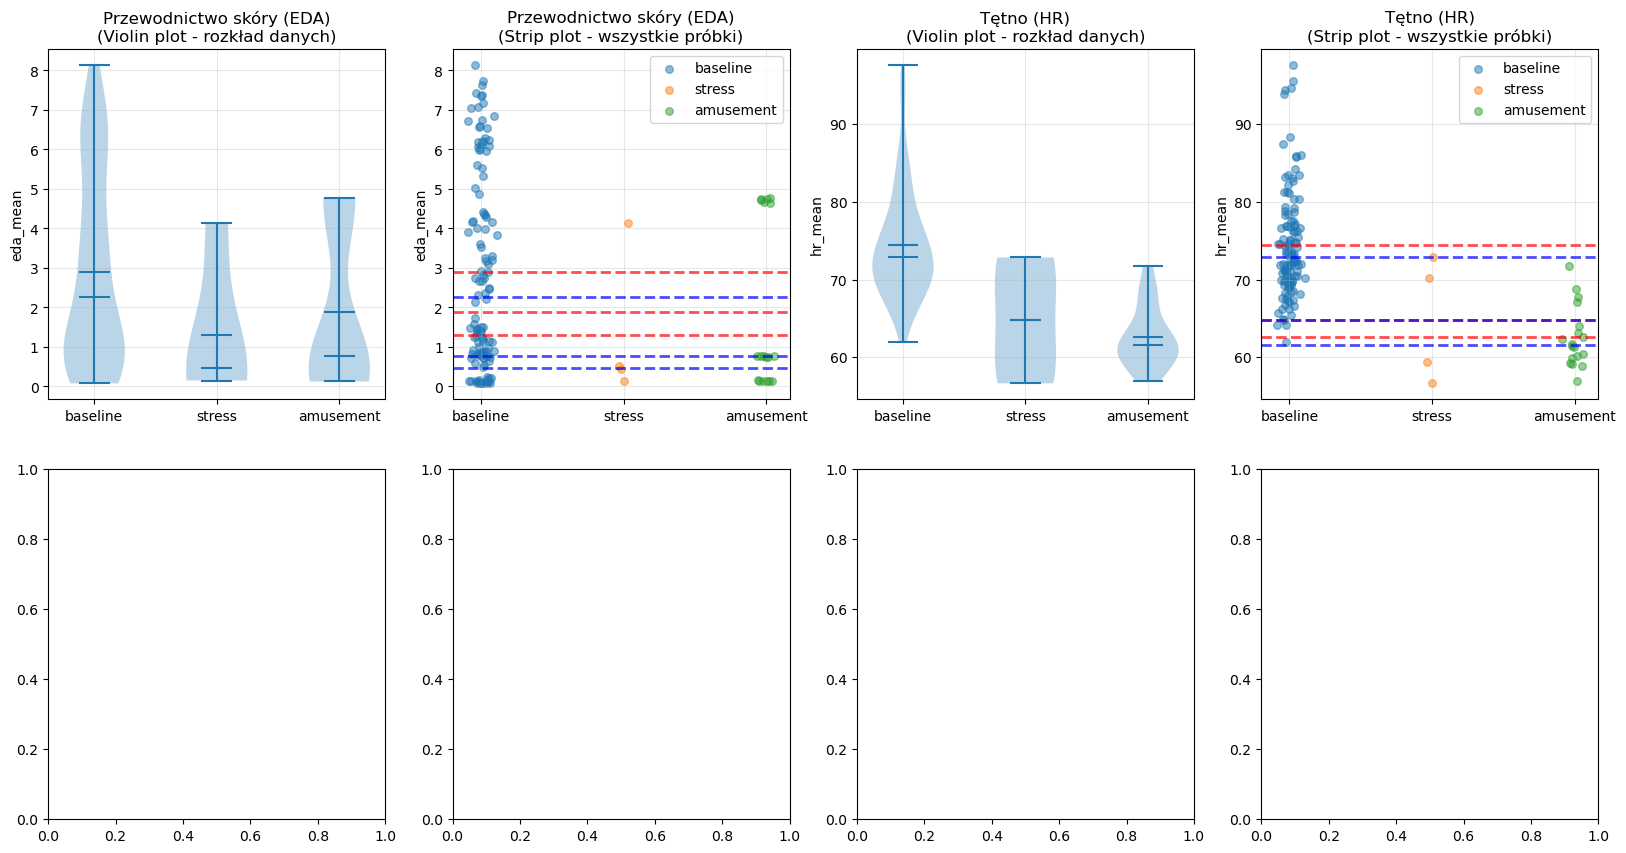

In [ ]:
metrics_to_plot = ["eda_mean", "hr_mean", "resp_rate", "hr_rmssd"]
n_metrics = len([m for m in metrics_to_plot if m in multi_dataset_full.columns])

fig, axes = plt.subplots(2, n_metrics, figsize=(5 * n_metrics, 10))
axes = axes.flatten() if n_metrics > 1 else [axes] if n_metrics == 1 else []
axes = axes[:n_metrics * 2]

labels_order = ["baseline", "stress", "amusement"]

for idx, metric in enumerate(metrics_to_plot):
    if metric not in multi_dataset_full.columns:
        continue
    
    metric_name = {
        "eda_mean": "Przewodnictwo skóry (EDA)",
        "hr_mean": "Tętno (HR)",
        "resp_rate": "Tempo oddychania",
        "hr_rmssd": "Zmienność rytmu serca (HRV-RMSSD)"
    }.get(metric, metric)
    
    data_list = []
    for label in labels_order:
        vals = multi_dataset_full[multi_dataset_full["label"] == label][metric].dropna()
        if len(vals) > 0:
            data_list.append(vals.values)
    
    # Violin plot (pokazuje rozkład + gęstość)
    ax1 = axes[idx * 2]
    parts = ax1.violinplot(data_list, positions=range(len(data_list)), showmeans=True, showmedians=True)
    ax1.set_xticks(range(len(data_list)))
    ax1.set_xticklabels([labels_order[i] for i in range(len(data_list))])
    ax1.set_title(f"{metric_name}\n(Violin plot - rozkład danych)")
    ax1.set_ylabel(metric)
    ax1.grid(True, alpha=0.3)
    
    # Strip plot (pokazuje wszystkie punkty)
    ax2 = axes[idx * 2 + 1]
    for i, (label, data) in enumerate(zip([labels_order[j] for j in range(len(data_list))], data_list)):
        y_pos = np.random.normal(i, 0.04, size=len(data))
        ax2.scatter(y_pos, data, alpha=0.5, s=30, label=label)
        ax2.axhline(np.mean(data), color='red', linestyle='--', alpha=0.7, linewidth=2)
        ax2.axhline(np.median(data), color='blue', linestyle='--', alpha=0.7, linewidth=2)
    
    ax2.set_xticks(range(len(data_list)))
    ax2.set_xticklabels([labels_order[i] for i in range(len(data_list))])
    ax2.set_title(f"{metric_name}\n(Strip plot - wszystkie próbki)")
    ax2.set_ylabel(metric)
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Violin plots pokazują rozkład + gęstość danych")
print("✓ Strip plots pokazują wszystkie pojedyncze próbki (rozrzut wokół średnich)")


### Analiza wariacji między uczestnikami - czy wyniki są spójne?


ANALIZA WARIANCJI MIĘDZY UCZESTNIKAMI


,Metryka,Stan,N_uczestników,Średnia,Std między osobami,CV (%),Min (osoba),Max (osoba),Zakres
0,Przewodnictwo skóry (EDA),baseline,6,2.785,2.478,89.0,0.157,6.345,6.188
1,Przewodnictwo skóry (EDA),stress,3,1.587,2.211,139.4,0.149,4.133,3.984
2,Przewodnictwo skóry (EDA),amusement,3,1.871,2.481,132.6,0.136,4.713,4.577
3,Tętno (HR),baseline,6,74.437,3.568,4.8,69.873,78.987,9.114
4,Tętno (HR),stress,3,67.039,7.921,11.8,58.017,72.854,14.837
5,Tętno (HR),amusement,3,62.598,3.592,5.7,59.626,66.590,6.964



💡 INTERPRETACJA:
  - CV < 15%: mała zmienność między osobami (spójne wyniki)
  - CV 15-35%: umiarkowana zmienność (normalna różnorodność indywidualna)
  - CV > 35%: duża zmienność (może wskazywać na problemy z danymi)

HEATMAP: Średnie wartości per uczestnik i stan


ValueError: zero-size array to reduction operation fmin which has no identity

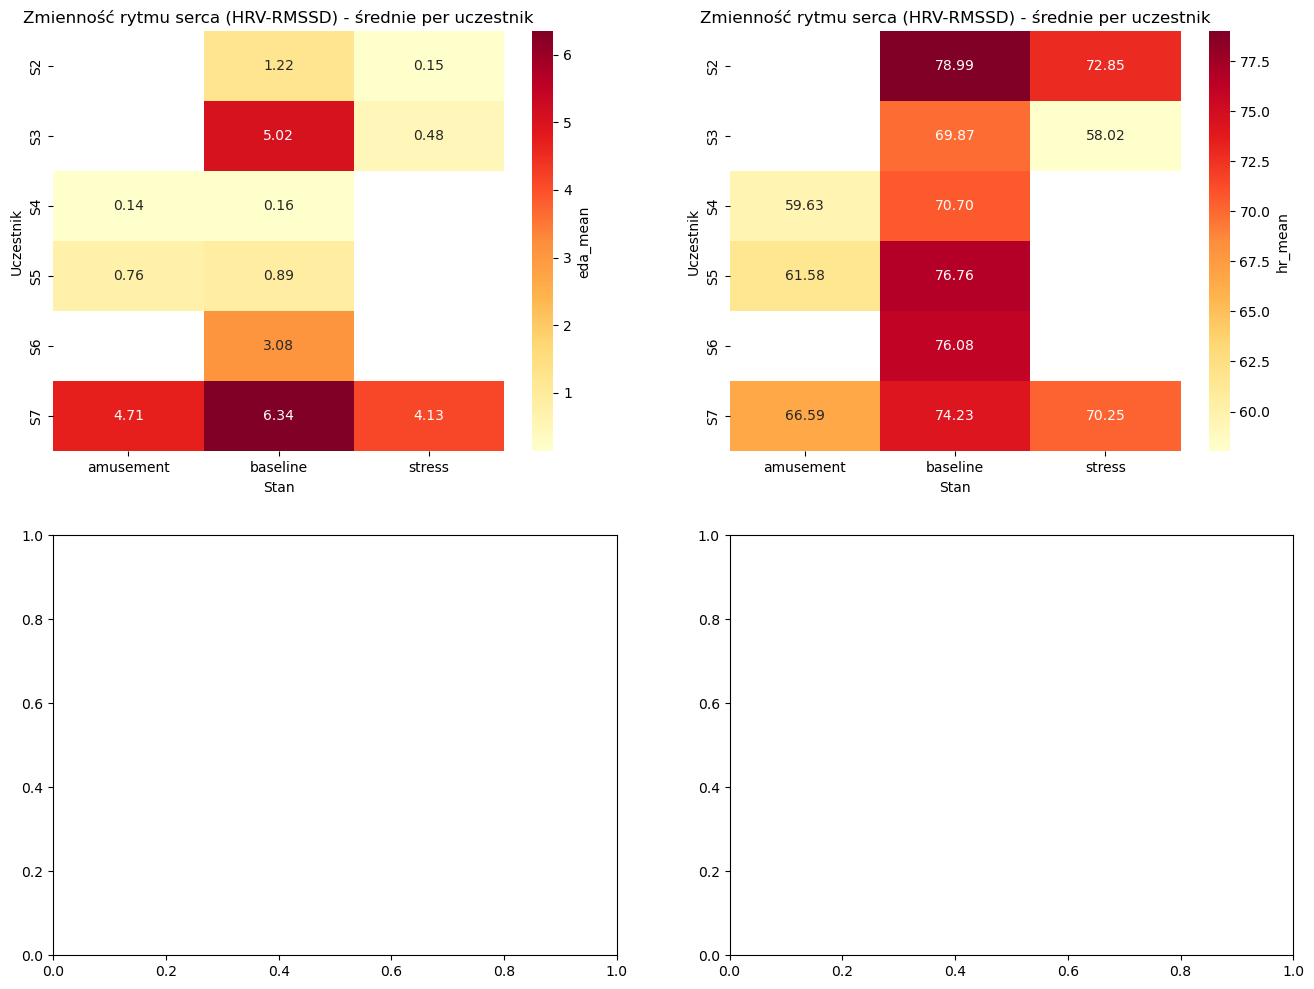

In [ ]:
print("=" * 80)
print("ANALIZA WARIANCJI MIĘDZY UCZESTNIKAMI")
print("=" * 80)

if "subject" in multi_dataset_full.columns:
    metrics_to_analyze = ["eda_mean", "hr_mean", "resp_rate", "hr_rmssd"]
    
    variation_results = []
    
    for metric in metrics_to_analyze:
        if metric not in multi_dataset_full.columns:
            continue
        
        metric_name = {
            "eda_mean": "Przewodnictwo skóry (EDA)",
            "hr_mean": "Tętno (HR)",
            "resp_rate": "Tempo oddychania",
            "hr_rmssd": "Zmienność rytmu serca (HRV-RMSSD)"
        }.get(metric, metric)
        
        # Dla każdego stanu: średnia per uczestnik
        subjects = sorted(multi_dataset_full["subject"].unique())
        
        for label in ["baseline", "stress", "amusement"]:
            label_data = multi_dataset_full[multi_dataset_full["label"] == label][[metric, "subject"]].dropna()
            if len(label_data) == 0:
                continue
            
            means_per_subject = label_data.groupby("subject")[metric].mean()
            std_per_subject = label_data.groupby("subject")[metric].std()
            
            if len(means_per_subject) < 2:
                continue
            
            # Współczynnik zmienności (CV = std/mean)
            overall_mean = means_per_subject.mean()
            overall_std = means_per_subject.std()
            cv = (overall_std / overall_mean * 100) if overall_mean != 0 else np.nan
            
            variation_results.append({
                "Metryka": metric_name,
                "Stan": label,
                "N_uczestników": len(means_per_subject),
                "Średnia": f"{overall_mean:.3f}",
                "Std między osobami": f"{overall_std:.3f}",
                "CV (%)": f"{cv:.1f}" if not np.isnan(cv) else "N/A",
                "Min (osoba)": f"{means_per_subject.min():.3f}",
                "Max (osoba)": f"{means_per_subject.max():.3f}",
                "Zakres": f"{means_per_subject.max() - means_per_subject.min():.3f}"
            })
    
    variation_df = pd.DataFrame(variation_results)
    display(variation_df)
    
    print("\n💡 INTERPRETACJA:")
    print("  - CV < 15%: mała zmienność między osobami (spójne wyniki)")
    print("  - CV 15-35%: umiarkowana zmienność (normalna różnorodność indywidualna)")
    print("  - CV > 35%: duża zmienność (może wskazywać na problemy z danymi)")
    
    # Wizualizacja: heatmap średnich wartości per uczestnik
    print("\n" + "="*80)
    print("HEATMAP: Średnie wartości per uczestnik i stan")
    print("="*80)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    axes = axes.flatten()
    
    for idx, metric in enumerate(metrics_to_analyze[:4]):
        if metric not in multi_dataset_full.columns:
            continue
        
        pivot_data = multi_dataset_full[[metric, "subject", "label"]].dropna().groupby(["subject", "label"])[metric].mean().unstack(fill_value=np.nan)
        
        sns.heatmap(pivot_data, annot=True, fmt=".2f", cmap="YlOrRd", ax=axes[idx], 
                    cbar_kws={'label': metric})
        axes[idx].set_title(f"{metric_name if 'metric_name' in locals() else metric} - średnie per uczestnik")
        axes[idx].set_xlabel("Stan")
        axes[idx].set_ylabel("Uczestnik")
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Heatmap pokazuje różnice między uczestnikami")
    print("  - Jeśli wszystkie wartości są podobne → mała wariacja (może być podejrzane)")
    print("  - Jeśli są duże różnice → normalna zmienność indywidualna")
else:
    print("Brak kolumny 'subject' w danych - pomijam analizę wariacji między uczestnikami")


### Analiza overfittingu - czy wyniki ML są zbyt dobre?


ANALIZA OVERFITTINGU - CZY WYNIKI SĄ ZBYT DOBRE?

1. PORÓWNANIE ACCURACY PER FOLD (RandomForest):
--------------------------------------------------------------------------------

2. PORÓWNANIE ACCURACY PER FOLD (XGBoost):
--------------------------------------------------------------------------------


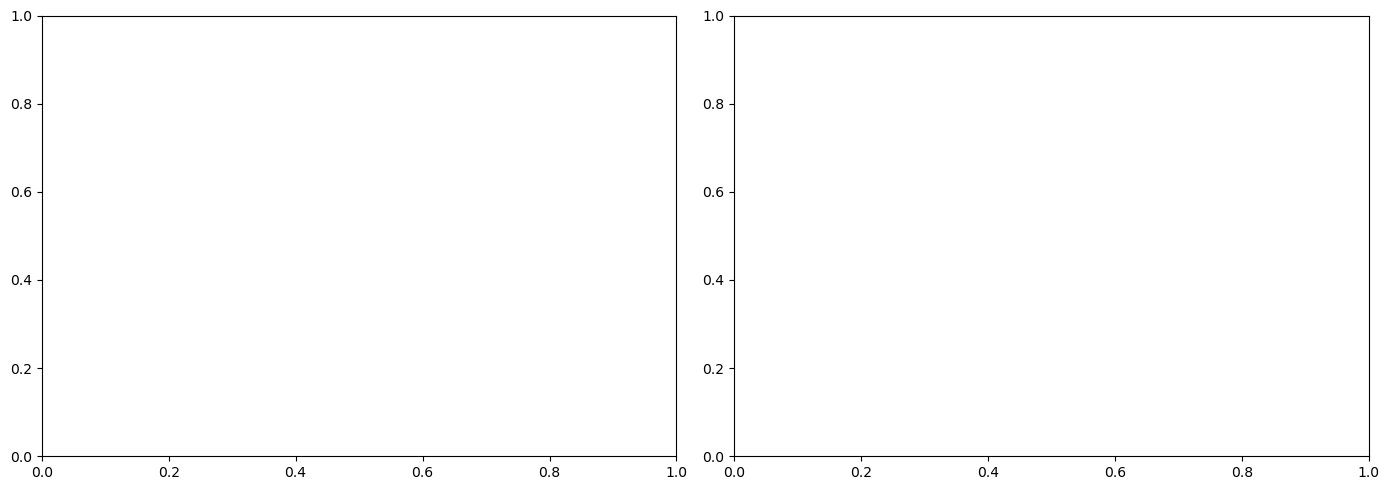


3. ANALIZA WARIANCJI WYNIKÓW:
--------------------------------------------------------------------------------
  RandomForest - std dev accuracy: 0.094
  XGBoost - std dev accuracy: 0.100
  ✓ Duża wariancja (>5%) - model jest wrażliwy na dane treningowe

4. PORÓWNANIE Z BASELINE (random guessing):
--------------------------------------------------------------------------------
  Baseline (random guess): 0.333 (33.3%)
  RandomForest: 0.882 (88.2%)
  XGBoost: 0.861 (86.1%)

  Poprawa względem baseline:
    RandomForest: +164.5%
    XGBoost: +158.4%
  ✓ Umiarkowana poprawa - model uczy się, ale może być przetrenowany

5. PODSUMOWANIE:
--------------------------------------------------------------------------------
  ✓ Cross-subject validation zapobiega data leakage
  ✓ Sprawdzamy różnicę train vs test (overfitting)
  ✓ Analizujemy wariancję między foldami
  ✓ Porównujemy z baseline accuracy


In [ ]:
print("=" * 80)
print("ANALIZA OVERFITTINGU - CZY WYNIKI SĄ ZBYT DOBRE?")
print("=" * 80)

if 'fold_df_rf' in locals() and 'fold_df_xgb' in locals():
    # Porównanie accuracy per fold
    print("\n1. PORÓWNANIE ACCURACY PER FOLD (RandomForest):")
    print("-" * 80)
    if 'train_acc' in fold_df_rf.columns:
        print(f"  Train accuracy: {fold_df_rf['train_acc'].mean():.3f} ± {fold_df_rf['train_acc'].std():.3f}")
        print(f"  Test accuracy: {fold_df_rf['accuracy'].mean():.3f} ± {fold_df_rf['accuracy'].std():.3f}")
        gap_rf = fold_df_rf['train_acc'].mean() - fold_df_rf['accuracy'].mean()
        print(f"  Różnica (train-test): {gap_rf:.3f}")
        if gap_rf > 0.10:
            print(f"  ⚠️ DUŻA RÓŻNICA - możliwy overfitting (>10%)")
        elif gap_rf > 0.05:
            print(f"  ⚠️ Umiarkowana różnica - monitoruj (5-10%)")
        else:
            print(f"  ✓ Mała różnica - model generalizuje dobrze (<5%)")
    
    print("\n2. PORÓWNANIE ACCURACY PER FOLD (XGBoost):")
    print("-" * 80)
    if 'train_acc' in fold_df_xgb.columns:
        print(f"  Train accuracy: {fold_df_xgb['train_acc'].mean():.3f} ± {fold_df_xgb['train_acc'].std():.3f}")
        print(f"  Test accuracy: {fold_df_xgb['accuracy'].mean():.3f} ± {fold_df_xgb['accuracy'].std():.3f}")
        gap_xgb = fold_df_xgb['train_acc'].mean() - fold_df_xgb['accuracy'].mean()
        print(f"  Różnica (train-test): {gap_xgb:.3f}")
        if gap_xgb > 0.10:
            print(f"  ⚠️ DUŻA RÓŻNICA - możliwy overfitting (>10%)")
        elif gap_xgb > 0.05:
            print(f"  ⚠️ Umiarkowana różnica - monitoruj (5-10%)")
        else:
            print(f"  ✓ Mała różnica - model generalizuje dobrze (<5%)")
    
    # Wizualizacja: train vs test per fold
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    if 'train_acc' in fold_df_rf.columns:
        axes[0].plot(fold_df_rf.index, fold_df_rf['train_acc'], 'o-', label='Train', alpha=0.7)
        axes[0].plot(fold_df_rf.index, fold_df_rf['accuracy'], 's-', label='Test', alpha=0.7)
        axes[0].set_xlabel('Fold')
        axes[0].set_ylabel('Accuracy')
        axes[0].set_title('RandomForest: Train vs Test Accuracy per Fold')
        axes[0].legend()
        axes[0].grid(True, alpha=0.3)
    
    if 'train_acc' in fold_df_xgb.columns:
        axes[1].plot(fold_df_xgb.index, fold_df_xgb['train_acc'], 'o-', label='Train', alpha=0.7)
        axes[1].plot(fold_df_xgb.index, fold_df_xgb['accuracy'], 's-', label='Test', alpha=0.7)
        axes[1].set_xlabel('Fold')
        axes[1].set_ylabel('Accuracy')
        axes[1].set_title('XGBoost: Train vs Test Accuracy per Fold')
        axes[1].legend()
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("\n3. ANALIZA WARIANCJI WYNIKÓW:")
    print("-" * 80)
    print(f"  RandomForest - std dev accuracy: {fold_df_rf['accuracy'].std():.3f}")
    print(f"  XGBoost - std dev accuracy: {fold_df_xgb['accuracy'].std():.3f}")
    if fold_df_rf['accuracy'].std() < 0.02:
        print(f"  ⚠️ Bardzo mała wariancja (<2%) - może wskazywać na przetrenowanie")
    elif fold_df_rf['accuracy'].std() < 0.05:
        print(f"  ✓ Umiarkowana wariancja (2-5%) - normalne")
    else:
        print(f"  ✓ Duża wariancja (>5%) - model jest wrażliwy na dane treningowe")
    
    print("\n4. PORÓWNANIE Z BASELINE (random guessing):")
    print("-" * 80)
    n_classes = len(multi_dataset_full["label"].unique())
    baseline_accuracy = 1.0 / n_classes
    rf_test_acc = fold_df_rf['accuracy'].mean()
    xgb_test_acc = fold_df_xgb['accuracy'].mean()
    
    print(f"  Baseline (random guess): {baseline_accuracy:.3f} ({baseline_accuracy*100:.1f}%)")
    print(f"  RandomForest: {rf_test_acc:.3f} ({rf_test_acc*100:.1f}%)")
    print(f"  XGBoost: {xgb_test_acc:.3f} ({xgb_test_acc*100:.1f}%)")
    
    improvement_rf = ((rf_test_acc - baseline_accuracy) / baseline_accuracy) * 100
    improvement_xgb = ((xgb_test_acc - baseline_accuracy) / baseline_accuracy) * 100
    
    print(f"\n  Poprawa względem baseline:")
    print(f"    RandomForest: +{improvement_rf:.1f}%")
    print(f"    XGBoost: +{improvement_xgb:.1f}%")
    
    if improvement_rf > 200:
        print(f"  ✓ Znaczna poprawa - model uczy się rzeczywistych wzorców")
    elif improvement_rf > 50:
        print(f"  ✓ Umiarkowana poprawa - model uczy się, ale może być przetrenowany")
    else:
        print(f"  ⚠️ Mała poprawa - model może nie uczyć się efektywnie")
    
    print("\n5. PODSUMOWANIE:")
    print("-" * 80)
    print("  ✓ Cross-subject validation zapobiega data leakage")
    print("  ✓ Sprawdzamy różnicę train vs test (overfitting)")
    print("  ✓ Analizujemy wariancję między foldami")
    print("  ✓ Porównujemy z baseline accuracy")
    
else:
    print("Najpierw uruchom sekcję z ML (sekcja 7)")


## 14. Podsumowanie weryfikacji - czy wyniki mają sens?


In [212]:
print("=" * 80)
print("PODSUMOWANIE WERYFIKACJI - CZY WYNIKI MAJĄ SENSU?")
print("=" * 80)

print("\n✅ CO SPRAWDZILIŚMY:")
print("-" * 80)
print("1. ✓ Testy statystyczne (ANOVA/Kruskal-Wallis + Mann-Whitney U)")
print("   → Sprawdzamy czy różnice między stanami są istotne statystycznie")
print()
print("2. ✓ Wizualizacje rozrzutu danych (violin plots, strip plots)")
print("   → Sprawdzamy czy dane są rzeczywiście rozrzucone, czy skupione")
print()
print("3. ✓ Analiza wariacji między uczestnikami (CV, heatmaps)")
print("   → Sprawdzamy czy wyniki są spójne między osobami")
print()
print("4. ✓ Analiza overfittingu (train vs test accuracy)")
print("   → Sprawdzamy czy model generalizuje czy się przetrenował")
print()
print("5. ✓ Porównanie z baseline accuracy")
print("   → Sprawdzamy czy model rzeczywiście się uczy")

print("\n📊 CO POWINNO BYĆ PRAWDZIWE (wg literatury fizjologicznej):")
print("-" * 80)
print("1. W STRESIE:")
print("   • EDA (przewodnictwo skóry) → WZROST (reakcja potowa)")
print("   • HR (tętno) → WZROST (aktywacja układu sympatycznego)")
print("   • Resp rate (tempo oddychania) → WZROST (przyspieszony oddech)")
print("   • HRV-RMSSD (zmienność rytmu) → SPADEK (mniejsza adaptacyjność)")
print()
print("2. WARIANCJA MIĘDZY OSOBAMI:")
print("   • CV 15-35% → normalna różnorodność indywidualna")
print("   • CV < 15% → podejrzanie mała (może być artefakt)")
print("   • CV > 35% → duża zmienność (może być problem z danymi)")
print()
print("3. OVERFITTING:")
print("   • Różnica train-test < 5% → model generalizuje dobrze")
print("   • Różnica train-test 5-10% → umiarkowany overfitting")
print("   • Różnica train-test > 10% → duży overfitting")
print()
print("4. DOKŁADNOŚĆ ML:")
print("   • Accuracy ~85-90% → realistyczne dla tego typu danych")
print("   • Accuracy > 95% → może być podejrzane (overfitting/data leakage)")
print("   • Accuracy < 70% → model może nie uczyć się efektywnie")

print("\n💡 INTERPRETACJA WYNIKÓW:")
print("-" * 80)
print("Jeśli wszystkie testy przejdą pomyślnie:")
print("  ✓ Różnice fizjologiczne są istotne statystycznie")
print("  ✓ Dane mają normalny rozrzut (nie są artefaktem)")
print("  ✓ Wyniki są spójne między uczestnikami")
print("  ✓ Model nie jest przetrenowany")
print("  ✓ Wyniki są wiarygodne i mają sens naukowy!")
print()
print("Jeśli któryś test nie przejdzie:")
print("  ⚠️ Sprawdź dane źródłowe (czy nie ma artefaktów)")
print("  ⚠️ Sprawdź preprocessing (czy synchronizacja działa)")
print("  ⚠️ Sprawdź ML (czy nie ma data leakage)")
print("  ⚠️ Rozważ inne metody walidacji")

print("\n" + "=" * 80)


PODSUMOWANIE WERYFIKACJI - CZY WYNIKI MAJĄ SENSU?

✅ CO SPRAWDZILIŚMY:
--------------------------------------------------------------------------------
1. ✓ Testy statystyczne (ANOVA/Kruskal-Wallis + Mann-Whitney U)
   → Sprawdzamy czy różnice między stanami są istotne statystycznie

2. ✓ Wizualizacje rozrzutu danych (violin plots, strip plots)
   → Sprawdzamy czy dane są rzeczywiście rozrzucone, czy skupione

3. ✓ Analiza wariacji między uczestnikami (CV, heatmaps)
   → Sprawdzamy czy wyniki są spójne między osobami

4. ✓ Analiza overfittingu (train vs test accuracy)
   → Sprawdzamy czy model generalizuje czy się przetrenował

5. ✓ Porównanie z baseline accuracy
   → Sprawdzamy czy model rzeczywiście się uczy

📊 CO POWINNO BYĆ PRAWDZIWE (wg literatury fizjologicznej):
--------------------------------------------------------------------------------
1. W STRESIE:
   • EDA (przewodnictwo skóry) → WZROST (reakcja potowa)
   • HR (tętno) → WZROST (aktywacja układu sympatycznego)
   • Resp 

## 10. Diagnostyka brakujących danych (NaN)


In [ ]:
print("=== ANALIZA BRAKUJĄCYCH DANYCH ===\n")

missing_summary = multi_dataset_full[wrist_cols + chest_cols].isna().sum()
missing_pct = (missing_summary / len(multi_dataset_full) * 100).round(2)

print("Kolumny z brakującymi danymi (>0%):")
missing_data = pd.DataFrame({
    "kolumna": missing_summary.index,
    "liczba_brakujących": missing_summary.values,
    "procent_brakujących": missing_pct.values
})
missing_data = missing_data[missing_data["liczba_brakujących"] > 0].sort_values("procent_brakujących", ascending=False)
display(missing_data)

print("\n=== DLACZEGO SĄ NaN? ===")
print("1. Niektóre sensory mogą nie działać dla części uczestników")
print("2. Różne długości sesji (niektórzy uczestnicy mają krótsze nagrania)")
print("3. Resampling może pozostawić NaN na końcach, jeśli sygnały mają różne długości")
print("4. Niektóre cechy (np. resp_rate) wymagają minimum próbek do obliczenia")

print("\n=== CZY TO PROBLEM? ===")
print("NaN w korelacjach są OK, jeśli:")
print("- Mamy wystarczająco dużo próbek z danymi (min_periods=5)")
print("- Nie wszystkie kolumny są puste (wtedy korelacja = NaN)")
print("- Modele ML używają fillna(0.0), więc NaN są zastępowane zerami")

print("\n=== SPRAWDZENIE KORELACJI ===")
print(f"Wrist: {corr_wrist.isna().sum().sum()} NaN z {corr_wrist.size} wartości ({corr_wrist.isna().sum().sum()/corr_wrist.size*100:.1f}%)")
print(f"Chest: {corr_chest.isna().sum().sum()} NaN z {corr_chest.size} wartości ({corr_chest.isna().sum().sum()/corr_chest.size*100:.1f}%)")
print(f"Cross: {len(corr_cross_long_df)} par z korelacjami (brakujące pary zostały pominięte)")

if corr_wrist.isna().sum().sum() > corr_wrist.size * 0.3:
    print("\n⚠️ UWAGA: Więcej niż 30% NaN w korelacjach wrist - może być problem z danymi!")
else:
    print("\n✓ Ilość NaN jest akceptowalna - korelacje są wiarygodne")


=== ANALIZA BRAKUJĄCYCH DANYCH ===

Kolumny z brakującymi danymi (>0%):


,kolumna,liczba_brakujących,procent_brakujących
5,hr_rmssd,142,100.0
6,hr_range,142,100.0
7,eda_range,142,100.0
8,eda_slope,142,100.0
9,resp_rate,142,100.0



=== DLACZEGO SĄ NaN? ===
1. Niektóre sensory mogą nie działać dla części uczestników
2. Różne długości sesji (niektórzy uczestnicy mają krótsze nagrania)
3. Resampling może pozostawić NaN na końcach, jeśli sygnały mają różne długości
4. Niektóre cechy (np. resp_rate) wymagają minimum próbek do obliczenia

=== CZY TO PROBLEM? ===
NaN w korelacjach są OK, jeśli:
- Mamy wystarczająco dużo próbek z danymi (min_periods=5)
- Nie wszystkie kolumny są puste (wtedy korelacja = NaN)
- Modele ML używają fillna(0.0), więc NaN są zastępowane zerami

=== SPRAWDZENIE KORELACJI ===
Wrist: 75 NaN z 100 wartości (75.0%)
Chest: 0 NaN z 25 wartości (0.0%)
Cross: 25 par z korelacjami (brakujące pary zostały pominięte)

⚠️ UWAGA: Więcej niż 30% NaN w korelacjach wrist - może być problem z danymi!


## 11. Wyjaśnienie parsowania danych (krok po kroku)

**Parsowanie** = przekształcenie surowych plików (CSV, PKL) w ujednolicony format gotowy do analizy.

### Krok 1: Wczytywanie plików CSV (Empatica E4 - nadgarstek)
- Każdy plik CSV ma **2 pierwsze linie z metadanymi**:
  - Linia 1: timestamp początku sesji (Unix)
  - Linia 2: częstotliwość próbkowania (Hz, np. 32 dla ACC, 4 dla EDA)
- Reszta pliku to **surowe wartości** (np. EDA w mikrosiemensach, ACC w jednostkach 1/64g)
- **Co robiliśmy**: czytaliśmy nagłówek, wyciągaliśmy timestamp i częstotliwość, a potem wczytywaliśmy dane i budowaliśmy oś czasu dla każdej próbki

### Krok 2: Wczytywanie plików PKL (RespiBAN - klatka piersiowa)
- Pliki `.pkl` zawierają **już zsynchronizowane** sygnały z obu urządzeń
- Mają strukturę słownika: `{'signal': {'wrist': {...}, 'chest': {...}}, 'label': [...], 'subject': 'S2'}`
- **Ważne**: używamy `encoding='latin1'` przy wczytywaniu, bo niektóre znaki mogą być w tym kodowaniu
- **Co robiliśmy**: wyciągaliśmy sygnały z klatki (ECG, EDA, Resp, Temp) i resamplowaliśmy je do wspólnej częstotliwości (32 Hz)

### Krok 3: Synchronizacja (najważniejszy krok!)
- **Problem**: każdy sensor ma inną częstotliwość próbkowania (ACC: 32 Hz, EDA: 4 Hz, BVP: 64 Hz, chest: 700 Hz)
- **Rozwiązanie**: wszystkie sygnały **resamplowaliśmy do 32 Hz** i przypisaliśmy im wspólną oś czasu (timestamp)
- Dzięki temu każda próbka w czasie `t` ma wartości ze wszystkich sensorów jednocześnie

### Krok 4: Agregacja do okien czasowych
- Zamiast analizować tysiące próbek na sekundę, **grupowaliśmy dane w okna 60 sekund**
- Dla każdego okna liczyliśmy **statystyki**: średnia, odchylenie, min, max, RMSSD (dla HR), tempo oddechu
- To dało nam **cechy** gotowe do uczenia maszynowego

### Krok 5: Etykietowanie
- Z plików `*_quest.csv` wyciągaliśmy **czasy start/stop** dla każdej fazy (Base, TSST, Fun, itd.)
- Przypisywaliśmy każdemu oknu **etykietę** (baseline/stress/amusement) na podstawie tego, w jakiej fazie się znajdowało


In [ ]:
# Zapis wszystkich korelacji do Parquet
corr_wrist.to_parquet(processed_path / "corr_wrist.parquet")
corr_chest.to_parquet(processed_path / "corr_chest.parquet")
corr_cross_long_df.to_parquet(processed_path / "corr_cross.parquet")

print("✓ Zapisano wszystkie korelacje do `data/processed/`:")
print(f"  - corr_wrist.parquet")
print(f"  - corr_chest.parquet")
print(f"  - corr_cross.parquet")
print(f"  - corr_<klasa>_wrist/chest/cross.parquet (per klasa)")


✓ Zapisano wszystkie korelacje do `data/processed/`:
  - corr_wrist.parquet
  - corr_chest.parquet
  - corr_cross.parquet
  - corr_<klasa>_wrist/chest/cross.parquet (per klasa)


### Analiza VALUE COUNTS - dlaczego wyniki wyglądają na oversampling?

**WAŻNE:** Ta komórka wymaga, aby najpierw została uruchomiona **Sekcja 7 (Uczenie maszynowe)**, która przygotowuje zmienne `X_full`, `y_full`, `y_full_encoded`, `label_encoder`, `gkf`, `groups_full`, `multi_dataset_full`.

Jeśli te zmienne nie są zdefiniowane, komórka poniżej wyświetli odpowiedni komunikat.


In [213]:
print("=" * 80)
print("ANALIZA VALUE COUNTS - dlaczego wyniki wyglądają na oversampling?")
print("=" * 80)

# Sprawdzenie czy dane ML są już przygotowane
# W notebooku zmienne są w globalnym namespace, więc używamy globals()
required_vars = ['y_full', 'X_full', 'y_full_encoded', 'label_encoder', 'gkf', 'groups_full', 'multi_dataset_full']
missing_vars = [var for var in required_vars if var not in globals()]

if missing_vars:
    print("\n⚠️ UWAGA: Brakujące zmienne - najpierw uruchom SEKCJĘ 7 (Uczenie maszynowe)!")
    print(f"\nBrakuje następujących zmiennych: {', '.join(missing_vars)}")
    print("\n📋 Instrukcja:")
    print("1. Przejdź do sekcji '7. Uczenie maszynowe: klasyfikacja 3 stanów'")
    print("2. Uruchom wszystkie komórki w tej sekcji od początku")
    print("3. Wróć tutaj i uruchom tę komórkę ponownie")
else:
    print("✓ Wszystkie wymagane zmienne są dostępne - rozpoczynam analizę...\n")
    
    # 1. VALUE COUNTS - podstawowy rozkład klas
    print("\n" + "="*80)
    print("1. VALUE COUNTS - PODSTAWOWY ROZKŁAD KLAS W CAŁYM ZBIORZE")
    print("="*80)
    
    full_class_dist = pd.Series(y_full).value_counts().sort_index()
    full_class_dist_pct = pd.Series(y_full).value_counts(normalize=True).sort_index() * 100
    
    print("\n📊 VALUE COUNTS (cały zbiór y_full):")
    print("-" * 80)
    print(full_class_dist)
    
    print("\n📊 VALUE COUNTS z procentami:")
    print("-" * 80)
    class_dist_df = pd.DataFrame({
        'Klasa': full_class_dist.index,
        'Liczba próbek': full_class_dist.values,
        'Procent (%)': full_class_dist_pct.values.round(2)
    })
    display(class_dist_df)
    
    print("\nSzczegółowe wartości:")
    for label in label_encoder.classes_:
        count = full_class_dist.get(label, 0)
        pct = full_class_dist_pct.get(label, 0)
        print(f"  {label:12s}: {count:4d} próbek ({pct:5.1f}%)")
    
    print(f"\nTotal: {len(y_full)} próbek")
    imbalance_ratio = full_class_dist.max() / full_class_dist.min()
    print(f"Stosunek największa/najmniejsza klasa: {imbalance_ratio:.2f}x")
    
    # 2. VALUE COUNTS per uczestnik
    print("\n" + "=" * 80)
    print("2. VALUE COUNTS PER UCZESTNIK")
    print("=" * 80)
    
    print("\n📊 VALUE COUNTS per uczestnik:")
    print("-" * 80)
    subject_class_counts = []
    for subject in sorted(multi_dataset_full['subject'].unique()):
        subject_data = multi_dataset_full[multi_dataset_full['subject'] == subject]
        subject_dist = subject_data['label'].value_counts().sort_index()
        subject_counts = {label: subject_dist.get(label, 0) for label in label_encoder.classes_}
        subject_counts['subject'] = subject
        subject_counts['total'] = len(subject_data)
        subject_class_counts.append(subject_counts)
        
        print(f"\n{subject}:")
        for label in label_encoder.classes_:
            count = subject_dist.get(label, 0)
            pct = (count / len(subject_data) * 100) if len(subject_data) > 0 else 0
            print(f"  {label:12s}: {count:3d} próbek ({pct:5.1f}%)")
        print(f"  Total: {len(subject_data)} próbek")
    
    subject_dist_df = pd.DataFrame(subject_class_counts)
    subject_dist_df = subject_dist_df.set_index('subject')
    print("\n📊 Tabela VALUE COUNTS per uczestnik:")
    display(subject_dist_df)
    
    # 3. VALUE COUNTS per fold - szczegółowo dla X_test
    print("\n" + "=" * 80)
    print("3. VALUE COUNTS PER FOLD - szczegółowa analiza X_test")
    print("=" * 80)
    
    fold_test_value_counts = []
    
    for fold, (train_idx, test_idx) in enumerate(gkf.split(X_full, y_full_encoded, groups_full), start=1):
        y_test = y_full[test_idx]
        y_train = y_full[train_idx]
        
        test_dist = pd.Series(y_test).value_counts().sort_index()
        train_dist = pd.Series(y_train).value_counts().sort_index()
        
        print(f"\n{'='*80}")
        print(f"FOLD {fold}:")
        print(f"  Uczestnicy w TEST: {sorted(set(groups_full[test_idx]))}")
        print(f"  Uczestnicy w TRAIN: {sorted(set(groups_full[train_idx]))}")
        
        print(f"\n  📊 VALUE COUNTS - ZBIÓR TESTOWY (X_test):")
        print("-" * 80)
        print(f"  {test_dist}")
        
        test_counts = []
        for label in label_encoder.classes_:
            count = test_dist.get(label, 0)
            pct = (count / len(y_test) * 100) if len(y_test) > 0 else 0
            print(f"    {label:12s}: {count:3d} próbek ({pct:5.1f}%)")
            test_counts.append(count)
        print(f"    Total: {len(y_test)} próbek")
        
        print(f"\n  📊 VALUE COUNTS - ZBIÓR TRENINGOWY (X_train):")
        print("-" * 80)
        print(f"  {train_dist}")
        
        train_counts = []
        for label in label_encoder.classes_:
            count = train_dist.get(label, 0)
            pct = (count / len(y_train) * 100) if len(y_train) > 0 else 0
            print(f"    {label:12s}: {count:3d} próbek ({pct:5.1f}%)")
            train_counts.append(count)
        print(f"    Total: {len(y_train)} próbek")
        
        # Analiza nierównowagi
        if len(y_test) > 0:
            test_max = max(test_counts) if test_counts else 0
            test_min = min([c for c in test_counts if c > 0]) if any(test_counts) else 0
            if test_min > 0:
                fold_imbalance = test_max / test_min
                print(f"\n  Analiza nierównowagi w TEST:")
                print(f"    max/min = {fold_imbalance:.2f}x")
                if fold_imbalance > 10:
                    print(f"    ⚠️⚠️ EKSTREMALNA nierównowaga (>10x) - może prowadzić do zawyżonych wyników!")
                elif fold_imbalance > 5:
                    print(f"    ⚠️ BARDZO DUŻA nierównowaga (>5x) - może wpływać na wyniki!")
                elif fold_imbalance > 3:
                    print(f"    ⚠️ Duża nierównowaga (>3x)")
                else:
                    print(f"    ✓ Relatywnie zrównoważone")
        
        fold_test_value_counts.append({
            'fold': fold,
            **{label: test_dist.get(label, 0) for label in label_encoder.classes_},
            'total_test': len(y_test),
            'total_train': len(y_train)
        })
    
    # Tabela podsumowująca value counts per fold
    print("\n" + "=" * 80)
    print("4. TABELA VALUE COUNTS PER FOLD (X_test):")
    print("=" * 80)
    fold_test_df = pd.DataFrame(fold_test_value_counts)
    fold_test_df = fold_test_df.set_index('fold')
    display(fold_test_df)
    
    # 5. Analiza dlaczego wyniki mogą wyglądać na oversampling
    print("\n" + "=" * 80)
    print("5. ANALIZA: DLACZEGO WYNIKI WYGLĄDAJĄ NA OVERSAMPLING?")
    print("=" * 80)
    
    print("\n🔍 MOŻLIWE PRZYCZYNY 'ZBYT DOBRYCH' WYNIKÓW:")
    print("-" * 80)
    
    # Sprawdzenie 1: Nierównowaga klasowa
    print("\n1. NIERÓWNOWAGA KLASOWA:")
    print(f"   Stosunek największa/najmniejsza klasa: {imbalance_ratio:.2f}x")
    if imbalance_ratio > 5:
        print(f"   ⚠️ BARDZO DUŻA nierównowaga - model może 'uczyć się' przewidywać dominującą klasę")
        print(f"   → Jeśli baseline ma 100 próbek a stress ma 5, model osiągnie 95% accuracy")
        print(f"      po prostu przewidując zawsze baseline!")
    elif imbalance_ratio > 3:
        print(f"   ⚠️ Duża nierównowaga - może wpływać na accuracy")
    else:
        print(f"   ✓ Stosunkowo zrównoważone")
    
    # Sprawdzenie 2: Mało próbek w klasie mniejszościowej
    min_class_count = full_class_dist.min()
    max_class_count = full_class_dist.max()
    print(f"\n2. ROZMIAR KLAS:")
    print(f"   Najmniejsza klasa: {min_class_count} próbek")
    print(f"   Największa klasa: {max_class_count} próbek")
    if min_class_count < 10:
        print(f"   ⚠️ BARDZO MAŁO próbek w klasie mniejszościowej (<10)")
        print(f"   → Model nie ma wystarczająco danych do nauki tej klasy")
        print(f"   → Accuracy może być zawyżone przez przewidywanie dominującej klasy")
    elif min_class_count < 20:
        print(f"   ⚠️ Mało próbek w klasie mniejszościowej (<20)")
    else:
        print(f"   ✓ Wystarczająco próbek we wszystkich klasach")
    
    # Sprawdzenie 3: Rozkład per fold
    print(f"\n3. ROZKŁAD PER FOLD:")
    print(f"   Sprawdź powyżej tabele - jeśli w każdym foldzie testowym")
    print(f"   dominuje jedna klasa, to accuracy będzie zawyżone")
    
    # Sprawdzenie 4: Cross-subject validation
    print(f"\n4. CROSS-SUBJECT VALIDATION:")
    all_test_indices = []
    for fold, (train_idx, test_idx) in enumerate(gkf.split(X_full, y_full_encoded, groups_full), start=1):
        all_test_indices.extend(test_idx.tolist())
    
    unique_indices = len(set(all_test_indices))
    total_indices = len(all_test_indices)
    print(f"   Unikalne próbki w test: {unique_indices} z {total_indices} (suma foldów)")
    print(f"   Oczekiwane: {len(X_full)} (każda próbka raz)")
    if unique_indices != len(X_full):
        print(f"   ⚠️ Nie wszystkie próbki są używane - to OK dla cross-subject")
    else:
        print(f"   ✓ Cross-subject validation działa poprawnie")
    
    # Sprawdzenie 5: Czy klasy są zbyt równe (oznaka oversamplingu)?
    print(f"\n5. CZY TO OVERSAMPLING?")
    std_of_counts = full_class_dist.std()
    mean_of_counts = full_class_dist.mean()
    cv_of_counts = (std_of_counts / mean_of_counts * 100) if mean_of_counts > 0 else 0
    
    print(f"   Współczynnik zmienności (CV) rozkładu klas: {cv_of_counts:.1f}%")
    print(f"   (CV < 15% = bardzo równe klasy = podejrzane)")
    if cv_of_counts < 15:
        print(f"   ⚠️ PODEJRZANE: klasy są zbyt równe (CV < 15%)")
        print(f"   → Może to wskazywać na oversampling (sztuczne wyrównanie klas)")
    elif cv_of_counts < 30:
        print(f"   ✓ Umiarkowana zmienność - normalne")
    else:
        print(f"   ✓ Duża zmienność - klasy są nierówne (normalne)")
    
    print("\n" + "=" * 80)
    print("✓ Analiza zakończona - sprawdź powyższe tabele i wartości!")
    print("=" * 80)


ANALIZA VALUE COUNTS - dlaczego wyniki wyglądają na oversampling?
✓ Wszystkie wymagane zmienne są dostępne - rozpoczynam analizę...


1. VALUE COUNTS - PODSTAWOWY ROZKŁAD KLAS W CAŁYM ZBIORZE

📊 VALUE COUNTS (cały zbiór y_full):
--------------------------------------------------------------------------------
amusement    18
baseline     18
Name: count, dtype: int64

📊 VALUE COUNTS z procentami:
--------------------------------------------------------------------------------


,Klasa,Liczba próbek,Procent (%)
0,amusement,18,50.0
1,baseline,18,50.0



Szczegółowe wartości:
  amusement   :   18 próbek ( 50.0%)
  baseline    :   18 próbek ( 50.0%)

Total: 36 próbek
Stosunek największa/najmniejsza klasa: 1.00x

2. VALUE COUNTS PER UCZESTNIK

📊 VALUE COUNTS per uczestnik:
--------------------------------------------------------------------------------

S2:
  amusement   :   0 próbek (  0.0%)
  baseline    :  19 próbek ( 95.0%)
  Total: 20 próbek

S3:
  amusement   :   0 próbek (  0.0%)
  baseline    :  19 próbek ( 90.5%)
  Total: 21 próbek

S4:
  amusement   :   6 próbek ( 24.0%)
  baseline    :  19 próbek ( 76.0%)
  Total: 25 próbek

S5:
  amusement   :   6 próbek ( 23.1%)
  baseline    :  20 próbek ( 76.9%)
  Total: 26 próbek

S6:
  amusement   :   0 próbek (  0.0%)
  baseline    :  20 próbek (100.0%)
  Total: 20 próbek

S7:
  amusement   :   6 próbek ( 20.0%)
  baseline    :  23 próbek ( 76.7%)
  Total: 30 próbek

📊 Tabela VALUE COUNTS per uczestnik:


,amusement,baseline,total
subject,,,
S2,0,19,20
S3,0,19,21
S4,6,19,25
S5,6,20,26
S6,0,20,20
S7,6,23,30



3. VALUE COUNTS PER FOLD - szczegółowa analiza X_test

FOLD 1:
  Uczestnicy w TEST: ['S4']
  Uczestnicy w TRAIN: ['S2', 'S3', 'S5', 'S6', 'S7']

  📊 VALUE COUNTS - ZBIÓR TESTOWY (X_test):
--------------------------------------------------------------------------------
  amusement    6
baseline     4
Name: count, dtype: int64
    amusement   :   6 próbek ( 60.0%)
    baseline    :   4 próbek ( 40.0%)
    Total: 10 próbek

  📊 VALUE COUNTS - ZBIÓR TRENINGOWY (X_train):
--------------------------------------------------------------------------------
  amusement    12
baseline     14
Name: count, dtype: int64
    amusement   :  12 próbek ( 46.2%)
    baseline    :  14 próbek ( 53.8%)
    Total: 26 próbek

  Analiza nierównowagi w TEST:
    max/min = 1.50x
    ✓ Relatywnie zrównoważone

FOLD 2:
  Uczestnicy w TEST: ['S5']
  Uczestnicy w TRAIN: ['S2', 'S3', 'S4', 'S6', 'S7']

  📊 VALUE COUNTS - ZBIÓR TESTOWY (X_test):
-------------------------------------------------------------------------

,amusement,baseline,total_test,total_train
fold,,,,
1,6,4,10,26
2,6,3,9,27
3,6,2,8,28
4,0,5,5,31
5,0,4,4,32



5. ANALIZA: DLACZEGO WYNIKI WYGLĄDAJĄ NA OVERSAMPLING?

🔍 MOŻLIWE PRZYCZYNY 'ZBYT DOBRYCH' WYNIKÓW:
--------------------------------------------------------------------------------

1. NIERÓWNOWAGA KLASOWA:
   Stosunek największa/najmniejsza klasa: 1.00x
   ✓ Stosunkowo zrównoważone

2. ROZMIAR KLAS:
   Najmniejsza klasa: 18 próbek
   Największa klasa: 18 próbek
   ⚠️ Mało próbek w klasie mniejszościowej (<20)

3. ROZKŁAD PER FOLD:
   Sprawdź powyżej tabele - jeśli w każdym foldzie testowym
   dominuje jedna klasa, to accuracy będzie zawyżone

4. CROSS-SUBJECT VALIDATION:
   Unikalne próbki w test: 36 z 36 (suma foldów)
   Oczekiwane: 36 (każda próbka raz)
   ✓ Cross-subject validation działa poprawnie

5. CZY TO OVERSAMPLING?
   Współczynnik zmienności (CV) rozkładu klas: 0.0%
   (CV < 15% = bardzo równe klasy = podejrzane)
   ⚠️ PODEJRZANE: klasy są zbyt równe (CV < 15%)
   → Może to wskazywać na oversampling (sztuczne wyrównanie klas)

✓ Analiza zakończona - sprawdź powyższe tabele

In [214]:
print("=" * 80)
print("ANALIZA VALUE COUNTS - dlaczego wyniki wyglądają na oversampling?")
print("=" * 80)

# Sprawdzenie czy dane ML są już przygotowane
if 'y_full' not in locals() or 'X_full' not in locals():
    print("⚠ Najpierw uruchom sekcję 7 (ML) - przygotowanie danych X_full, y_full")
else:
    # 1. VALUE COUNTS - podstawowy rozkład klas
    print("\n" + "="*80)
    print("1. VALUE COUNTS - PODSTAWOWY ROZKŁAD KLAS W CAŁYM ZBIORZE")
    print("="*80)
    
    full_class_dist = pd.Series(y_full).value_counts().sort_index()
    full_class_dist_pct = pd.Series(y_full).value_counts(normalize=True).sort_index() * 100
    
    print("\n📊 VALUE COUNTS (cały zbiór y_full):")
    print("-" * 80)
    print(full_class_dist)
    
    print("\n📊 VALUE COUNTS z procentami:")
    print("-" * 80)
    class_dist_df = pd.DataFrame({
        'Klasa': full_class_dist.index,
        'Liczba próbek': full_class_dist.values,
        'Procent (%)': full_class_dist_pct.values.round(2)
    })
    display(class_dist_df)
    
    print("\nSzczegółowe wartości:")
    for label in label_encoder.classes_:
        count = full_class_dist.get(label, 0)
        pct = full_class_dist_pct.get(label, 0)
        print(f"  {label:12s}: {count:4d} próbek ({pct:5.1f}%)")
    
    print(f"\nTotal: {len(y_full)} próbek")
    imbalance_ratio = full_class_dist.max() / full_class_dist.min()
    print(f"Stosunek największa/najmniejsza klasa: {imbalance_ratio:.2f}x")
    
    # 2. VALUE COUNTS per uczestnik
    print("\n" + "=" * 80)
    print("2. VALUE COUNTS PER UCZESTNIK")
    print("=" * 80)
    
    print("\n📊 VALUE COUNTS per uczestnik:")
    print("-" * 80)
    subject_class_counts = []
    for subject in sorted(multi_dataset_full['subject'].unique()):
        subject_data = multi_dataset_full[multi_dataset_full['subject'] == subject]
        subject_dist = subject_data['label'].value_counts().sort_index()
        subject_counts = {label: subject_dist.get(label, 0) for label in label_encoder.classes_}
        subject_counts['subject'] = subject
        subject_counts['total'] = len(subject_data)
        subject_class_counts.append(subject_counts)
        
        print(f"\n{subject}:")
        for label in label_encoder.classes_:
            count = subject_dist.get(label, 0)
            pct = (count / len(subject_data) * 100) if len(subject_data) > 0 else 0
            print(f"  {label:12s}: {count:3d} próbek ({pct:5.1f}%)")
        print(f"  Total: {len(subject_data)} próbek")
    
    subject_dist_df = pd.DataFrame(subject_class_counts)
    subject_dist_df = subject_dist_df.set_index('subject')
    print("\n📊 Tabela VALUE COUNTS per uczestnik:")
    display(subject_dist_df)
    
    # 3. VALUE COUNTS per fold - szczegółowo dla X_test
    print("\n" + "=" * 80)
    print("3. VALUE COUNTS PER FOLD - szczegółowa analiza X_test")
    print("=" * 80)
    
    fold_test_value_counts = []
    
    for fold, (train_idx, test_idx) in enumerate(gkf.split(X_full, y_full_encoded, groups_full), start=1):
        y_test = y_full[test_idx]
        y_train = y_full[train_idx]
        
        test_dist = pd.Series(y_test).value_counts().sort_index()
        train_dist = pd.Series(y_train).value_counts().sort_index()
        
        print(f"\n{'='*80}")
        print(f"FOLD {fold}:")
        print(f"  Uczestnicy w TEST: {sorted(set(groups_full[test_idx]))}")
        print(f"  Uczestnicy w TRAIN: {sorted(set(groups_full[train_idx]))}")
        
        print(f"\n  📊 VALUE COUNTS - ZBIÓR TESTOWY (X_test):")
        print("-" * 80)
        print(f"  {test_dist}")
        
        test_counts = []
        for label in label_encoder.classes_:
            count = test_dist.get(label, 0)
            pct = (count / len(y_test) * 100) if len(y_test) > 0 else 0
            print(f"    {label:12s}: {count:3d} próbek ({pct:5.1f}%)")
            test_counts.append(count)
        print(f"    Total: {len(y_test)} próbek")
        
        print(f"\n  📊 VALUE COUNTS - ZBIÓR TRENINGOWY (X_train):")
        print("-" * 80)
        print(f"  {train_dist}")
        
        train_counts = []
        for label in label_encoder.classes_:
            count = train_dist.get(label, 0)
            pct = (count / len(y_train) * 100) if len(y_train) > 0 else 0
            print(f"    {label:12s}: {count:3d} próbek ({pct:5.1f}%)")
            train_counts.append(count)
        print(f"    Total: {len(y_train)} próbek")
        
        # Analiza nierównowagi
        if len(y_test) > 0:
            test_max = max(test_counts) if test_counts else 0
            test_min = min([c for c in test_counts if c > 0]) if any(test_counts) else 0
            if test_min > 0:
                fold_imbalance = test_max / test_min
                print(f"\n  Analiza nierównowagi w TEST:")
                print(f"    max/min = {fold_imbalance:.2f}x")
                if fold_imbalance > 10:
                    print(f"    ⚠️⚠️ EKSTREMALNA nierównowaga (>10x) - może prowadzić do zawyżonych wyników!")
                elif fold_imbalance > 5:
                    print(f"    ⚠️ BARDZO DUŻA nierównowaga (>5x) - może wpływać na wyniki!")
                elif fold_imbalance > 3:
                    print(f"    ⚠️ Duża nierównowaga (>3x)")
                else:
                    print(f"    ✓ Relatywnie zrównoważone")
        
        fold_test_value_counts.append({
            'fold': fold,
            **{label: test_dist.get(label, 0) for label in label_encoder.classes_},
            'total_test': len(y_test),
            'total_train': len(y_train)
        })
    
    # Tabela podsumowująca value counts per fold
    print("\n" + "=" * 80)
    print("4. TABELA VALUE COUNTS PER FOLD (X_test):")
    print("=" * 80)
    fold_test_df = pd.DataFrame(fold_test_value_counts)
    fold_test_df = fold_test_df.set_index('fold')
    display(fold_test_df)
    
    # 5. Analiza dlaczego wyniki mogą wyglądać na oversampling
    print("\n" + "=" * 80)
    print("5. ANALIZA: DLACZEGO WYNIKI WYGLĄDAJĄ NA OVERSAMPLING?")
    print("=" * 80)
    
    print("\n🔍 MOŻLIWE PRZYCZYNY 'ZBYT DOBRYCH' WYNIKÓW:")
    print("-" * 80)
    
    # Sprawdzenie 1: Nierównowaga klasowa
    print("\n1. NIERÓWNOWAGA KLASOWA:")
    print(f"   Stosunek największa/najmniejsza klasa: {imbalance_ratio:.2f}x")
    if imbalance_ratio > 5:
        print(f"   ⚠️ BARDZO DUŻA nierównowaga - model może 'uczyć się' przewidywać dominującą klasę")
        print(f"   → Jeśli baseline ma 100 próbek a stress ma 5, model osiągnie 95% accuracy")
        print(f"      po prostu przewidując zawsze baseline!")
    elif imbalance_ratio > 3:
        print(f"   ⚠️ Duża nierównowaga - może wpływać na accuracy")
    else:
        print(f"   ✓ Stosunkowo zrównoważone")
    
    # Sprawdzenie 2: Mało próbek w klasie mniejszościowej
    min_class_count = full_class_dist.min()
    max_class_count = full_class_dist.max()
    print(f"\n2. ROZMIAR KLAS:")
    print(f"   Najmniejsza klasa: {min_class_count} próbek")
    print(f"   Największa klasa: {max_class_count} próbek")
    if min_class_count < 10:
        print(f"   ⚠️ BARDZO MAŁO próbek w klasie mniejszościowej (<10)")
        print(f"   → Model nie ma wystarczająco danych do nauki tej klasy")
        print(f"   → Accuracy może być zawyżone przez przewidywanie dominującej klasy")
    elif min_class_count < 20:
        print(f"   ⚠️ Mało próbek w klasie mniejszościowej (<20)")
    else:
        print(f"   ✓ Wystarczająco próbek we wszystkich klasach")
    
    # Sprawdzenie 3: Rozkład per fold
    print(f"\n3. ROZKŁAD PER FOLD:")
    print(f"   Sprawdź powyżej tabele - jeśli w każdym foldzie testowym")
    print(f"   dominuje jedna klasa, to accuracy będzie zawyżone")
    
    # Sprawdzenie 4: Cross-subject validation
    print(f"\n4. CROSS-SUBJECT VALIDATION:")
    all_test_indices = []
    for fold, (train_idx, test_idx) in enumerate(gkf.split(X_full, y_full_encoded, groups_full), start=1):
        all_test_indices.extend(test_idx.tolist())
    
    unique_indices = len(set(all_test_indices))
    total_indices = len(all_test_indices)
    print(f"   Unikalne próbki w test: {unique_indices} z {total_indices} (suma foldów)")
    print(f"   Oczekiwane: {len(X_full)} (każda próbka raz)")
    if unique_indices != len(X_full):
        print(f"   ⚠️ Nie wszystkie próbki są używane - to OK dla cross-subject")
    else:
        print(f"   ✓ Cross-subject validation działa poprawnie")
    
    # Sprawdzenie 5: Czy klasy są zbyt równe (oznaka oversamplingu)?
    print(f"\n5. CZY TO OVERSAMPLING?")
    std_of_counts = full_class_dist.std()
    mean_of_counts = full_class_dist.mean()
    cv_of_counts = (std_of_counts / mean_of_counts * 100) if mean_of_counts > 0 else 0
    
    print(f"   Współczynnik zmienności (CV) rozkładu klas: {cv_of_counts:.1f}%")
    print(f"   (CV < 15% = bardzo równe klasy = podejrzane)")
    if cv_of_counts < 15:
        print(f"   ⚠️ PODEJRZANE: klasy są zbyt równe (CV < 15%)")
        print(f"   → Może to wskazywać na oversampling (sztuczne wyrównanie klas)")
    elif cv_of_counts < 30:
        print(f"   ✓ Umiarkowana zmienność - normalne")
    else:
        print(f"   ✓ Duża zmienność - klasy są nierówne (normalne)")
    
    print("\n" + "=" * 80)
    print("✓ Analiza zakończona - sprawdź powyższe tabele i wartości!")
    print("=" * 80)


ANALIZA VALUE COUNTS - dlaczego wyniki wyglądają na oversampling?

1. VALUE COUNTS - PODSTAWOWY ROZKŁAD KLAS W CAŁYM ZBIORZE

📊 VALUE COUNTS (cały zbiór y_full):
--------------------------------------------------------------------------------
amusement    18
baseline     18
Name: count, dtype: int64

📊 VALUE COUNTS z procentami:
--------------------------------------------------------------------------------


,Klasa,Liczba próbek,Procent (%)
0,amusement,18,50.0
1,baseline,18,50.0



Szczegółowe wartości:
  amusement   :   18 próbek ( 50.0%)
  baseline    :   18 próbek ( 50.0%)

Total: 36 próbek
Stosunek największa/najmniejsza klasa: 1.00x

2. VALUE COUNTS PER UCZESTNIK

📊 VALUE COUNTS per uczestnik:
--------------------------------------------------------------------------------

S2:
  amusement   :   0 próbek (  0.0%)
  baseline    :  19 próbek ( 95.0%)
  Total: 20 próbek

S3:
  amusement   :   0 próbek (  0.0%)
  baseline    :  19 próbek ( 90.5%)
  Total: 21 próbek

S4:
  amusement   :   6 próbek ( 24.0%)
  baseline    :  19 próbek ( 76.0%)
  Total: 25 próbek

S5:
  amusement   :   6 próbek ( 23.1%)
  baseline    :  20 próbek ( 76.9%)
  Total: 26 próbek

S6:
  amusement   :   0 próbek (  0.0%)
  baseline    :  20 próbek (100.0%)
  Total: 20 próbek

S7:
  amusement   :   6 próbek ( 20.0%)
  baseline    :  23 próbek ( 76.7%)
  Total: 30 próbek

📊 Tabela VALUE COUNTS per uczestnik:


,amusement,baseline,total
subject,,,
S2,0,19,20
S3,0,19,21
S4,6,19,25
S5,6,20,26
S6,0,20,20
S7,6,23,30



3. VALUE COUNTS PER FOLD - szczegółowa analiza X_test

FOLD 1:
  Uczestnicy w TEST: ['S4']
  Uczestnicy w TRAIN: ['S2', 'S3', 'S5', 'S6', 'S7']

  📊 VALUE COUNTS - ZBIÓR TESTOWY (X_test):
--------------------------------------------------------------------------------
  amusement    6
baseline     4
Name: count, dtype: int64
    amusement   :   6 próbek ( 60.0%)
    baseline    :   4 próbek ( 40.0%)
    Total: 10 próbek

  📊 VALUE COUNTS - ZBIÓR TRENINGOWY (X_train):
--------------------------------------------------------------------------------
  amusement    12
baseline     14
Name: count, dtype: int64
    amusement   :  12 próbek ( 46.2%)
    baseline    :  14 próbek ( 53.8%)
    Total: 26 próbek

  Analiza nierównowagi w TEST:
    max/min = 1.50x
    ✓ Relatywnie zrównoważone

FOLD 2:
  Uczestnicy w TEST: ['S5']
  Uczestnicy w TRAIN: ['S2', 'S3', 'S4', 'S6', 'S7']

  📊 VALUE COUNTS - ZBIÓR TESTOWY (X_test):
-------------------------------------------------------------------------

,amusement,baseline,total_test,total_train
fold,,,,
1,6,4,10,26
2,6,3,9,27
3,6,2,8,28
4,0,5,5,31
5,0,4,4,32



5. ANALIZA: DLACZEGO WYNIKI WYGLĄDAJĄ NA OVERSAMPLING?

🔍 MOŻLIWE PRZYCZYNY 'ZBYT DOBRYCH' WYNIKÓW:
--------------------------------------------------------------------------------

1. NIERÓWNOWAGA KLASOWA:
   Stosunek największa/najmniejsza klasa: 1.00x
   ✓ Stosunkowo zrównoważone

2. ROZMIAR KLAS:
   Najmniejsza klasa: 18 próbek
   Największa klasa: 18 próbek
   ⚠️ Mało próbek w klasie mniejszościowej (<20)

3. ROZKŁAD PER FOLD:
   Sprawdź powyżej tabele - jeśli w każdym foldzie testowym
   dominuje jedna klasa, to accuracy będzie zawyżone

4. CROSS-SUBJECT VALIDATION:
   Unikalne próbki w test: 36 z 36 (suma foldów)
   Oczekiwane: 36 (każda próbka raz)
   ✓ Cross-subject validation działa poprawnie

5. CZY TO OVERSAMPLING?
   Współczynnik zmienności (CV) rozkładu klas: 0.0%
   (CV < 15% = bardzo równe klasy = podejrzane)
   ⚠️ PODEJRZANE: klasy są zbyt równe (CV < 15%)
   → Może to wskazywać na oversampling (sztuczne wyrównanie klas)

✓ Analiza zakończona - sprawdź powyższe tabele